# Imports

In [2]:
from ucimlrepo import fetch_ucirepo 

import os
import string
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import ollama

# Parameters

In [4]:
# Number of rows that LLM will process (randomly sampled) 
n_rows = 5000

# LLMs that will be used to perform processing
models = ['llama3.2:1b', 'llama3.2:3b', 'gemma3:1b', 'gemma3:4b', 'llama3.1', 'dolphin3', 'mistral', 'deepseek-llm']

# Stopping tokens in LLM response 
stop_sequences_letters = stop_sequences = list(string.ascii_letters)  

In [5]:
# Force CUDA usage
os.environ["OLLAMA_BACKEND"] = "cuda"
os.environ["OLLAMA_NUM_THREADS"] = "16"

# Load prompt templates

In [7]:
templates = {
    "Career Stage Classification": '''Instruction:
Assign a score from 1 to 10 representing the individual's career stage, where 1-3 = Early, 4-7 = Mid, and 8-10 = Late. Use the person's profile, as well as your knowledge, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}''',

    "Occupational Demand Outlook": '''Instruction:
Assign a score from 1 to 10 representing the occupational demand outlook, where 1-3 = Low, 4-7 = Moderate, and 8-10 = High. Use the person's profile, as well as your knowledge of industry trends and labor data, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}''',

    "Education ROI": '''Instruction:
Assign a score from 1 to 10 representing the education ROI (Return on Investment), where 1-3 = Low, 4-7 = Medium, and 8-10 = High. Use the person's profile, as well as your knowledge, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}''',

    "Years of Experience": '''Instruction:
Assign a score from 1 to 10 representing years of work experience, where 1-3 = Low (0-5 years), 4-7 = Moderate (6-15 years), and 8-10 = High (16+ years). Use the person's profile, as well as your knowledge, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}''',

    "Socio-economic Mobility": '''Instruction:
Assign a score from 1 to 10 representing socio-economic mobility potential, where 1-3 = Low, 4-7 = Moderate, and 8-10 = High. Use the person's profile, as well as your knowledge, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}''',

    "Job vs Education Match": '''Instruction:
Assign a score from 1 to 10 representing the alignment between job role and education level, where 1-3 = Mismatch, 4-7 = Partial Match, and 8-10 = Good Match. Use the person's profile, as well as your knowledge, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}''',

    "Job Security Rating": '''Instruction:
Assign a score from 1 to 10 representing job security for the person, where 1-3 = At Risk, 4-7 = Moderate, and 8-10 = Secure. Use the person's profile, as well as your knowledge of industry stability and occupation demand, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}''',

    "Cultural Integration Score": '''Instruction:
Assign a score from 1 to 10 representing cultural integration potential based on the person's profile, where 1-3 = Low, 4-7 = Moderate, and 8-10 = High. Use the person's profile, as well as your knowledge, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}'''
}

for template in templates:
    print(template)
    print(templates[template])
    print()

Career Stage Classification
Instruction:
Assign a score from 1 to 10 representing the individual's career stage, where 1-3 = Early, 4-7 = Mid, and 8-10 = Late. Use the person's profile, as well as your knowledge, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}

Occupational Demand Outlook
Instruction:
Assign a score from 1 to 10 representing the occupational demand outlook, where 1-3 = Low, 4-7 = Moderate, and 8-10 = High. Use the person's profile, as well as your knowledge of industry trends and labor data, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:
{data}

Education ROI
Instruction:
Assign a score from 1 to 10 representing the education ROI (Return on Investment), where 1-3 = Low, 4-7 = Medium, and 8-10 = High. Use the person's profile, as well as your knowledge, to determine the score.
Return ONLY a number between 1 and 10. Do NOT return any other text.

Profile:

# Load Data

In [9]:
# Load dataset 
data = fetch_ucirepo(id=2) 

# Conver to DF
X = data.data.features
y = data.data.targets
df = pd.concat([X, y], axis=1)

# Display basic information
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  4

In [10]:
df.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

# Required preprocessing before LLM preprocessing

### Dealing with missing data

In [13]:
# Check for missing values
print(df.isnull().sum())

# The dataset has native class for missing data: "?"
df = df.fillna('?')

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


# LLM Feature engineering

## NLG Descriptions of rows

In [16]:
template = (
    "{age}-year-old {sex} from {native-country}, {marital-status}, "
    "works as a {occupation} in the {workclass} sector. "
    "With a {education} education, "
    "they identify as {race} and are {relationship} in their household. "
    "They work {hours-per-week} hours weekly, with a capital gain this year of {capital-gain} dollars "
    "and a capital loss this year of {capital-loss} dollars."
)

# Function to format a row into a sentence
def format_row_to_sentence(row):
    return template.format(**row)

# Apply the function to each row
df["nlg"] = df.apply(format_row_to_sentence, axis=1)
df.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  \
0          2174             0              40  United-States  <=50K   
1             0             0              13  United-States  <=50K   
2             0             0              40  United-States  <=50K   
3             0             0              40  United-States  <=50K   
4             0             0              40           Cuba  <=50K   

                                                 nlg  
0  39-year-old Male from United-States, Never-mar...  
1  50-year-old Male from United-States, Married-c...  
2  38-year-old Male from United-States, Divorced,...  
3  53-year-old Male from United-States, Married-c...  
4  28-year-old Female from Cuba, Married-civ-spou...

### Need to limit sample size due to computational power constraint

In [18]:
llm_df = df.sample(n=n_rows, random_state=42) 
llm_df = llm_df.reset_index(drop=True)
llm_df.head()

age  workclass  fnlwgt     education  education-num marital-status  \
0   18    Private  423024       HS-grad              9  Never-married   
1   17    Private  178953          12th              8  Never-married   
2   25  Local-gov  348986       HS-grad              9  Never-married   
3   20    Private  218215  Some-college             10  Never-married   
4   47    Private  244025       HS-grad              9  Never-married   

          occupation    relationship                race     sex  \
0      Other-service   Not-in-family               White    Male   
1              Sales       Own-child               White  Female   
2  Handlers-cleaners  Other-relative               Black    Male   
3              Sales       Own-child               White  Female   
4  Machine-op-inspct       Unmarried  Amer-Indian-Eskimo    Male   

   capital-gain  capital-loss  hours-per-week native-country income  \
0             0             0              20  United-States  <=50K   
1             0             0              20  United-States  <=50K   
2             0             0              40  United-States  <=50K   
3             0             0              30  United-States  <=50K   
4             0             0              56    Puerto-Rico  <=50K   

                                                 nlg  
0  18-year-old Male from United-States, Never-mar...  
1  17-year-old Female from United-States, Never-m...  
2  25-year-old Male from United-States, Never-mar...  
3  20-year-old Female from United-States, Never-m...  
4  47-year-old Male from Puerto-Rico, Never-marri...

### Each each template corresponds to a new column in the dataframe

In [20]:
# Initialize new columns for each template and model combination
for model in models:
    for template in templates:
        # Create unique column names
        column_name = f"{template}_{model.replace(':', '_')}"  
        llm_df[column_name] = None

llm_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'nlg', 'Career Stage Classification_llama3.2_1b',
       'Occupational Demand Outlook_llama3.2_1b', 'Education ROI_llama3.2_1b',
       'Years of Experience_llama3.2_1b',
       'Socio-economic Mobility_llama3.2_1b',
       'Job vs Education Match_llama3.2_1b', 'Job Security Rating_llama3.2_1b',
       'Cultural Integration Score_llama3.2_1b',
       'Career Stage Classification_llama3.2_3b',
       'Occupational Demand Outlook_llama3.2_3b', 'Education ROI_llama3.2_3b',
       'Years of Experience_llama3.2_3b',
       'Socio-economic Mobility_llama3.2_3b',
       'Job vs Education Match_llama3.2_3b', 'Job Security Rating_llama3.2_3b',
       'Cultural Integration Score_llama3.2_3b',
       'Career Stage Classification_gemma3_1b',
       'Occupational Demand Out

## Actual prompting

### Qualitative loop

In [23]:
# For each model
for model in models:
    # For each row with a tqdm loading bar
    for index, row in tqdm(llm_df.iterrows(), total=llm_df.shape[0], desc=f"Processing rows with {model}"):
        # For each template
        for template in templates:
            # Format the template with the row data
            template_formatted = templates[template].format(data=row['nlg'])

            # Create the column name for this template and model
            column_name = f"{template}_{model.replace(':', '_')}"
            
            # Keep looping until we have a valid response:
            while True:
                try:
                    # Generate the response using the loaded model
                    response = ollama.generate(model=model, 
                                               prompt=template_formatted,
                                               options = {
                                                   'stop': stop_sequences_letters, # Stop when any letter is generated
                                                   'num_predict': 2 # Numbers 1 to 10 is at most 2 tokens
                                               })['response'] 

                    # Cast the string response to int by removing any non-digit characters
                    response = int(''.join(filter(str.isdigit, response)))

                    # Assert that a valid response is generated
                    assert response >= 1 and response <= 10
                    
                    # Store the response in the corresponding column
                    llm_df.at[index, column_name] = response

                    # Now that a valid sample is generated break the while loop
                    break
                except Exception as e:
                    print(e)

Processing rows with llama3.2:3b:  22%|█████████                                 | 1078/5000 [36:42<2:13:19,  2.04s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  23%|█████████▌                                | 1133/5000 [38:34<2:10:37,  2.03s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  23%|█████████▌                                | 1140/5000 [38:48<2:11:22,  2.04s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  25%|██████████▌                               | 1260/5000 [42:52<2:06:57,  2.04s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  28%|███████████▉                              | 1422/5000 [48:23<2:02:01,  2.05s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  32%|█████████████▎                            | 1579/5000 [53:43<1:56:09,  2.04s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  32%|█████████████▋                            | 1624/5000 [55:15<1:54:53,  2.04s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  34%|██████████████▎                           | 1707/5000 [58:04<1:51:38,  2.03s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  38%|███████████████▎                        | 1907/5000 [1:04:51<1:44:52,  2.03s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  40%|███████████████▊                        | 1981/5000 [1:07:22<1:42:05,  2.03s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  44%|█████████████████▋                      | 2206/5000 [1:15:00<1:35:15,  2.05s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  52%|████████████████████▊                   | 2605/5000 [1:28:33<1:21:08,  2.03s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  81%|█████████████████████████████████▉        | 4042/5000 [2:17:20<32:31,  2.04s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  89%|█████████████████████████████████████▌    | 4465/5000 [2:31:42<18:14,  2.05s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  94%|███████████████████████████████████████▍  | 4689/5000 [2:39:17<10:28,  2.02s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.2:3b:  97%|████████████████████████████████████████▊ | 4861/5000 [2:45:08<04:43,  2.04s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.1:  47%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 2343/5000 [3:40:34<3:57:13,  5.36s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.1:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 2672/5000 [4:10:08<3:30:06,  5.41s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 3380/5000 [5:13:24<2:24:16,  5.34s/it]

invalid literal for int() with base 10: ''


Processing rows with llama3.1:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4300/5000 [6:35:49<1:02:50,  5.39s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|                                                                                                                                                                                                                        | 0/5000 [00:00<?, ?it/s]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|                                                                                                                                                                                                             | 3/5000 [00:27<11:11:57,  8.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▏                                                                                                                                                                                                             | 5/5000 [00:39<9:14:01,  6.66s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▏                                                                                                                                                                                                             | 6/5000 [00:45<8:48:05,  6.34s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▎                                                                                                                                                                                                             | 7/5000 [00:50<8:35:41,  6.20s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▎                                                                                                                                                                                                             | 8/5000 [00:56<8:25:04,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▎                                                                                                                                                                                                             | 9/5000 [01:02<8:23:53,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▍                                                                                                                                                                                                            | 10/5000 [01:09<8:33:57,  6.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▍                                                                                                                                                                                                            | 11/5000 [01:15<8:45:05,  6.31s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▍                                                                                                                                                                                                            | 12/5000 [01:21<8:35:35,  6.20s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▌                                                                                                                                                                                                            | 13/5000 [01:27<8:24:54,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▌                                                                                                                                                                                                            | 15/5000 [01:39<8:15:58,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▋                                                                                                                                                                                                            | 17/5000 [01:51<8:20:30,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▋                                                                                                                                                                                                            | 18/5000 [01:57<8:16:47,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▊                                                                                                                                                                                                            | 20/5000 [02:09<8:12:08,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▊                                                                                                                                                                                                            | 21/5000 [02:15<8:08:25,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▉                                                                                                                                                                                                            | 22/5000 [02:21<8:11:46,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▉                                                                                                                                                                                                            | 23/5000 [02:27<8:10:50,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|▉                                                                                                                                                                                                            | 24/5000 [02:33<8:10:38,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   0%|█                                                                                                                                                                                                            | 25/5000 [02:39<8:14:19,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▏                                                                                                                                                                                                           | 29/5000 [03:02<8:01:08,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▏                                                                                                                                                                                                           | 30/5000 [03:08<8:00:31,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▎                                                                                                                                                                                                           | 32/5000 [03:19<7:55:42,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▎                                                                                                                                                                                                           | 33/5000 [03:25<7:55:49,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▍                                                                                                                                                                                                           | 34/5000 [03:31<7:59:30,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▍                                                                                                                                                                                                           | 35/5000 [03:36<7:59:07,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▍                                                                                                                                                                                                           | 36/5000 [03:43<8:12:50,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▌                                                                                                                                                                                                           | 37/5000 [03:49<8:11:58,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▌                                                                                                                                                                                                           | 38/5000 [03:55<8:10:58,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▌                                                                                                                                                                                                           | 39/5000 [04:01<8:10:18,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▋                                                                                                                                                                                                           | 40/5000 [04:07<8:22:36,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▋                                                                                                                                                                                                           | 41/5000 [04:13<8:24:41,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▋                                                                                                                                                                                                           | 42/5000 [04:19<8:20:05,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▊                                                                                                                                                                                                           | 43/5000 [04:25<8:23:14,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▊                                                                                                                                                                                                           | 45/5000 [04:37<8:09:46,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▉                                                                                                                                                                                                           | 46/5000 [04:43<8:09:08,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▉                                                                                                                                                                                                           | 47/5000 [04:49<8:08:47,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|█▉                                                                                                                                                                                                           | 48/5000 [04:55<8:08:32,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██                                                                                                                                                                                                           | 49/5000 [05:01<8:07:49,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██                                                                                                                                                                                                           | 50/5000 [05:06<8:04:44,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▏                                                                                                                                                                                                          | 52/5000 [05:18<8:09:22,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▏                                                                                                                                                                                                          | 54/5000 [05:30<8:00:07,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▎                                                                                                                                                                                                          | 57/5000 [05:47<7:54:53,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▍                                                                                                                                                                                                          | 60/5000 [06:04<7:52:20,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▌                                                                                                                                                                                                          | 61/5000 [06:10<7:53:23,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▌                                                                                                                                                                                                          | 63/5000 [06:22<7:55:40,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▌                                                                                                                                                                                                          | 64/5000 [06:28<7:58:17,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▋                                                                                                                                                                                                          | 66/5000 [06:40<7:59:08,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▋                                                                                                                                                                                                          | 67/5000 [06:46<8:04:16,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▊                                                                                                                                                                                                          | 68/5000 [06:51<8:03:15,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▊                                                                                                                                                                                                          | 69/5000 [06:58<8:13:47,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▊                                                                                                                                                                                                          | 70/5000 [07:04<8:07:48,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▉                                                                                                                                                                                                          | 71/5000 [07:09<8:03:27,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|██▉                                                                                                                                                                                                          | 73/5000 [07:21<8:04:11,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   1%|███                                                                                                                                                                                                          | 74/5000 [07:27<8:08:34,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███                                                                                                                                                                                                          | 75/5000 [07:33<8:04:01,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███                                                                                                                                                                                                          | 76/5000 [07:39<8:00:19,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▏                                                                                                                                                                                                         | 78/5000 [07:50<7:53:19,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▏                                                                                                                                                                                                         | 79/5000 [07:56<7:59:22,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▎                                                                                                                                                                                                         | 80/5000 [08:02<8:02:39,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▎                                                                                                                                                                                                         | 81/5000 [08:08<8:08:45,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▎                                                                                                                                                                                                         | 82/5000 [08:15<8:21:28,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▍                                                                                                                                                                                                         | 84/5000 [08:26<8:06:00,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▍                                                                                                                                                                                                         | 85/5000 [08:32<8:04:41,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▌                                                                                                                                                                                                         | 86/5000 [08:38<8:00:28,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▌                                                                                                                                                                                                         | 88/5000 [08:50<7:54:28,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▋                                                                                                                                                                                                         | 90/5000 [09:01<7:51:54,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▋                                                                                                                                                                                                         | 91/5000 [09:07<8:01:58,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▊                                                                                                                                                                                                         | 92/5000 [09:13<8:08:25,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▊                                                                                                                                                                                                         | 93/5000 [09:20<8:12:55,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▊                                                                                                                                                                                                         | 94/5000 [09:26<8:13:15,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▉                                                                                                                                                                                                         | 95/5000 [09:31<8:06:38,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▉                                                                                                                                                                                                         | 96/5000 [09:37<8:05:42,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|███▉                                                                                                                                                                                                         | 97/5000 [09:43<8:01:31,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████                                                                                                                                                                                                         | 98/5000 [09:49<7:58:31,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████                                                                                                                                                                                                        | 100/5000 [10:00<7:53:37,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████                                                                                                                                                                                                        | 101/5000 [10:06<7:52:25,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▏                                                                                                                                                                                                       | 102/5000 [10:12<7:58:46,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▎                                                                                                                                                                                                       | 105/5000 [10:29<7:50:00,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▎                                                                                                                                                                                                       | 106/5000 [10:35<7:50:04,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▎                                                                                                                                                                                                       | 107/5000 [10:42<8:26:03,  6.21s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▍                                                                                                                                                                                                       | 108/5000 [10:49<8:35:07,  6.32s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▍                                                                                                                                                                                                       | 109/5000 [10:55<8:37:32,  6.35s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▍                                                                                                                                                                                                       | 110/5000 [11:01<8:23:57,  6.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▌                                                                                                                                                                                                       | 111/5000 [11:07<8:23:22,  6.18s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▌                                                                                                                                                                                                       | 112/5000 [11:13<8:13:14,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▌                                                                                                                                                                                                       | 113/5000 [11:19<8:06:04,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▋                                                                                                                                                                                                       | 115/5000 [11:30<7:53:54,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▊                                                                                                                                                                                                       | 117/5000 [11:42<7:48:32,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▊                                                                                                                                                                                                       | 118/5000 [11:47<7:48:33,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▉                                                                                                                                                                                                       | 120/5000 [11:59<7:47:11,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▉                                                                                                                                                                                                       | 121/5000 [12:05<7:59:59,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|████▉                                                                                                                                                                                                       | 122/5000 [12:11<7:59:26,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|█████                                                                                                                                                                                                       | 124/5000 [12:23<7:56:12,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   2%|█████                                                                                                                                                                                                       | 125/5000 [12:29<7:56:14,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▏                                                                                                                                                                                                      | 126/5000 [12:35<8:02:56,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▏                                                                                                                                                                                                      | 127/5000 [12:41<8:08:59,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▏                                                                                                                                                                                                      | 128/5000 [12:47<8:05:38,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▎                                                                                                                                                                                                      | 129/5000 [12:53<7:59:25,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▎                                                                                                                                                                                                      | 130/5000 [12:58<7:57:00,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▎                                                                                                                                                                                                      | 131/5000 [13:04<7:56:13,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▍                                                                                                                                                                                                      | 132/5000 [13:10<7:59:59,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▍                                                                                                                                                                                                      | 133/5000 [13:17<8:25:57,  6.24s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▍                                                                                                                                                                                                      | 134/5000 [13:23<8:17:52,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▌                                                                                                                                                                                                      | 135/5000 [13:29<8:14:33,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▌                                                                                                                                                                                                      | 137/5000 [13:41<7:59:23,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▋                                                                                                                                                                                                      | 139/5000 [13:52<7:51:30,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▋                                                                                                                                                                                                      | 140/5000 [13:58<7:51:06,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▊                                                                                                                                                                                                      | 141/5000 [14:04<7:52:46,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▊                                                                                                                                                                                                      | 142/5000 [14:10<7:50:39,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▊                                                                                                                                                                                                      | 143/5000 [14:16<7:52:36,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▉                                                                                                                                                                                                      | 144/5000 [14:22<7:53:51,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▉                                                                                                                                                                                                      | 145/5000 [14:27<7:51:33,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▉                                                                                                                                                                                                      | 146/5000 [14:33<7:56:55,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|█████▉                                                                                                                                                                                                      | 147/5000 [14:39<7:53:12,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████                                                                                                                                                                                                      | 148/5000 [14:45<7:50:51,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████                                                                                                                                                                                                      | 149/5000 [14:51<8:06:14,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████                                                                                                                                                                                                      | 150/5000 [14:57<8:06:40,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▏                                                                                                                                                                                                     | 152/5000 [15:09<8:02:21,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▏                                                                                                                                                                                                     | 153/5000 [15:15<7:56:27,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▎                                                                                                                                                                                                     | 154/5000 [15:21<7:56:50,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▎                                                                                                                                                                                                     | 155/5000 [15:27<7:53:59,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▎                                                                                                                                                                                                     | 156/5000 [15:33<7:57:36,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▍                                                                                                                                                                                                     | 158/5000 [15:44<7:47:48,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▍                                                                                                                                                                                                     | 159/5000 [15:52<8:43:58,  6.49s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▌                                                                                                                                                                                                     | 160/5000 [15:58<8:26:05,  6.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▌                                                                                                                                                                                                     | 161/5000 [16:04<8:26:24,  6.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▌                                                                                                                                                                                                     | 162/5000 [16:11<8:33:01,  6.36s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▋                                                                                                                                                                                                     | 163/5000 [16:17<8:21:33,  6.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▊                                                                                                                                                                                                     | 168/5000 [16:45<7:43:19,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|██████▉                                                                                                                                                                                                     | 170/5000 [16:57<7:40:09,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|███████                                                                                                                                                                                                     | 172/5000 [17:08<7:44:19,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   3%|███████                                                                                                                                                                                                     | 173/5000 [17:14<7:43:48,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▎                                                                                                                                                                                                    | 178/5000 [17:42<7:34:35,  5.66s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▎                                                                                                                                                                                                    | 179/5000 [17:48<7:40:12,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▍                                                                                                                                                                                                    | 181/5000 [18:00<7:41:23,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▍                                                                                                                                                                                                    | 182/5000 [18:06<7:44:47,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▍                                                                                                                                                                                                    | 183/5000 [18:11<7:43:42,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▌                                                                                                                                                                                                    | 184/5000 [18:17<7:45:51,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▌                                                                                                                                                                                                    | 185/5000 [18:23<7:47:54,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▌                                                                                                                                                                                                    | 186/5000 [18:29<7:50:03,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▋                                                                                                                                                                                                    | 188/5000 [18:41<7:50:21,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▋                                                                                                                                                                                                    | 189/5000 [18:47<7:48:06,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▊                                                                                                                                                                                                    | 190/5000 [18:53<7:45:56,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▊                                                                                                                                                                                                    | 191/5000 [18:59<7:51:13,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▊                                                                                                                                                                                                    | 193/5000 [19:10<7:46:46,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▉                                                                                                                                                                                                    | 194/5000 [19:16<7:46:03,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|███████▉                                                                                                                                                                                                    | 196/5000 [19:27<7:40:42,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████                                                                                                                                                                                                    | 197/5000 [19:33<7:41:01,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████                                                                                                                                                                                                    | 198/5000 [19:39<7:44:39,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▏                                                                                                                                                                                                   | 200/5000 [19:51<7:44:08,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▏                                                                                                                                                                                                   | 201/5000 [19:57<7:53:36,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▏                                                                                                                                                                                                   | 202/5000 [20:03<7:52:43,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▎                                                                                                                                                                                                   | 204/5000 [20:14<7:48:21,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▍                                                                                                                                                                                                   | 207/5000 [20:32<7:43:02,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▍                                                                                                                                                                                                   | 208/5000 [20:38<7:45:13,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▌                                                                                                                                                                                                   | 210/5000 [20:49<7:42:37,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▌                                                                                                                                                                                                   | 211/5000 [20:56<7:51:06,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▋                                                                                                                                                                                                   | 212/5000 [21:02<8:01:28,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▋                                                                                                                                                                                                   | 214/5000 [21:14<7:54:48,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▊                                                                                                                                                                                                   | 216/5000 [21:26<7:54:20,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▊                                                                                                                                                                                                   | 217/5000 [21:32<7:56:50,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|████████▉                                                                                                                                                                                                   | 220/5000 [21:49<7:43:10,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|█████████                                                                                                                                                                                                   | 221/5000 [21:55<7:41:43,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|█████████                                                                                                                                                                                                   | 222/5000 [22:01<8:01:50,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   4%|█████████▏                                                                                                                                                                                                  | 225/5000 [22:19<7:42:06,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▏                                                                                                                                                                                                  | 226/5000 [22:24<7:40:23,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▎                                                                                                                                                                                                  | 227/5000 [22:31<8:08:31,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▎                                                                                                                                                                                                  | 229/5000 [22:43<8:00:50,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▍                                                                                                                                                                                                  | 230/5000 [22:49<7:53:51,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▍                                                                                                                                                                                                  | 231/5000 [22:55<7:53:26,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▍                                                                                                                                                                                                  | 232/5000 [23:01<7:57:56,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▌                                                                                                                                                                                                  | 235/5000 [23:18<7:41:56,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▋                                                                                                                                                                                                  | 238/5000 [23:36<7:35:00,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▊                                                                                                                                                                                                  | 239/5000 [23:42<7:39:01,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▊                                                                                                                                                                                                  | 240/5000 [23:47<7:41:16,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▊                                                                                                                                                                                                  | 241/5000 [23:54<7:50:58,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▊                                                                                                                                                                                                  | 242/5000 [23:59<7:47:43,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▉                                                                                                                                                                                                  | 244/5000 [24:11<7:41:34,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|█████████▉                                                                                                                                                                                                  | 245/5000 [24:17<7:39:21,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████                                                                                                                                                                                                  | 246/5000 [24:23<7:46:47,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████                                                                                                                                                                                                  | 247/5000 [24:29<7:53:24,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▏                                                                                                                                                                                                 | 249/5000 [24:41<7:48:12,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▏                                                                                                                                                                                                 | 250/5000 [24:47<7:44:15,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▏                                                                                                                                                                                                 | 251/5000 [24:52<7:42:27,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▎                                                                                                                                                                                                 | 252/5000 [24:59<7:50:23,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▎                                                                                                                                                                                                 | 253/5000 [25:04<7:46:18,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▍                                                                                                                                                                                                 | 255/5000 [25:16<7:41:12,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▍                                                                                                                                                                                                 | 256/5000 [25:22<7:47:39,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▍                                                                                                                                                                                                 | 257/5000 [25:28<7:46:51,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▌                                                                                                                                                                                                 | 259/5000 [25:39<7:40:27,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▋                                                                                                                                                                                                 | 261/5000 [25:51<7:39:30,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▋                                                                                                                                                                                                 | 263/5000 [26:03<7:39:38,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▊                                                                                                                                                                                                 | 264/5000 [26:09<7:41:31,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▊                                                                                                                                                                                                 | 265/5000 [26:15<8:01:09,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▊                                                                                                                                                                                                 | 266/5000 [26:21<7:56:23,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▉                                                                                                                                                                                                 | 267/5000 [26:27<7:52:34,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|██████████▉                                                                                                                                                                                                 | 268/5000 [26:34<8:06:36,  6.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|███████████                                                                                                                                                                                                 | 270/5000 [26:46<7:54:17,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|███████████                                                                                                                                                                                                 | 271/5000 [26:51<7:48:03,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|███████████                                                                                                                                                                                                 | 272/5000 [26:57<7:53:54,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|███████████▏                                                                                                                                                                                                | 273/5000 [27:03<7:48:05,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   5%|███████████▏                                                                                                                                                                                                | 274/5000 [27:09<7:46:46,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▏                                                                                                                                                                                                | 275/5000 [27:15<7:42:32,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▎                                                                                                                                                                                                | 277/5000 [27:26<7:37:29,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▎                                                                                                                                                                                                | 278/5000 [27:32<7:41:55,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▍                                                                                                                                                                                                | 279/5000 [27:38<7:45:02,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▍                                                                                                                                                                                                | 280/5000 [27:44<7:41:50,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▌                                                                                                                                                                                                | 282/5000 [27:56<7:33:53,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▌                                                                                                                                                                                                | 283/5000 [28:04<8:32:57,  6.52s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▋                                                                                                                                                                                                | 287/5000 [28:27<7:48:53,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▊                                                                                                                                                                                                | 288/5000 [28:33<7:48:19,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▊                                                                                                                                                                                                | 289/5000 [28:40<7:52:57,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▊                                                                                                                                                                                                | 290/5000 [28:45<7:47:30,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▉                                                                                                                                                                                                | 292/5000 [28:57<7:36:11,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▉                                                                                                                                                                                                | 293/5000 [29:03<7:35:17,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|███████████▉                                                                                                                                                                                                | 294/5000 [29:08<7:34:22,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████                                                                                                                                                                                                | 295/5000 [29:14<7:43:28,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████                                                                                                                                                                                                | 297/5000 [29:26<7:39:22,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▏                                                                                                                                                                                               | 299/5000 [29:38<7:37:30,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▏                                                                                                                                                                                               | 300/5000 [29:44<7:42:01,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▎                                                                                                                                                                                               | 302/5000 [29:55<7:32:51,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▎                                                                                                                                                                                               | 303/5000 [30:01<7:32:09,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▍                                                                                                                                                                                               | 304/5000 [30:07<7:37:24,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▍                                                                                                                                                                                               | 305/5000 [30:13<7:45:40,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▌                                                                                                                                                                                               | 307/5000 [30:25<7:38:11,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▌                                                                                                                                                                                               | 308/5000 [30:31<7:36:12,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▌                                                                                                                                                                                               | 309/5000 [30:36<7:34:28,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▋                                                                                                                                                                                               | 310/5000 [30:42<7:33:33,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▋                                                                                                                                                                                               | 311/5000 [30:48<7:39:54,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▊                                                                                                                                                                                               | 313/5000 [31:00<7:32:01,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▊                                                                                                                                                                                               | 314/5000 [31:06<7:37:29,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▊                                                                                                                                                                                               | 315/5000 [31:11<7:35:56,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▉                                                                                                                                                                                               | 316/5000 [31:17<7:37:41,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▉                                                                                                                                                                                               | 317/5000 [31:24<7:49:06,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|████████████▉                                                                                                                                                                                               | 318/5000 [31:30<7:59:30,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|█████████████                                                                                                                                                                                               | 319/5000 [31:36<7:56:34,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|█████████████                                                                                                                                                                                               | 321/5000 [31:48<7:49:49,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|█████████████▏                                                                                                                                                                                              | 324/5000 [32:06<7:37:52,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   6%|█████████████▎                                                                                                                                                                                              | 325/5000 [32:12<7:49:09,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▎                                                                                                                                                                                              | 326/5000 [32:18<7:55:35,  6.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▎                                                                                                                                                                                              | 327/5000 [32:24<7:48:51,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▍                                                                                                                                                                                              | 328/5000 [32:30<7:43:15,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▍                                                                                                                                                                                              | 329/5000 [32:36<7:42:42,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▍                                                                                                                                                                                              | 330/5000 [32:42<7:41:33,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▋                                                                                                                                                                                              | 334/5000 [33:05<7:26:38,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▋                                                                                                                                                                                              | 336/5000 [33:17<7:30:27,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▊                                                                                                                                                                                              | 339/5000 [33:34<7:26:54,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▊                                                                                                                                                                                              | 340/5000 [33:41<7:51:10,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▉                                                                                                                                                                                              | 341/5000 [33:47<7:56:18,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▉                                                                                                                                                                                              | 342/5000 [33:53<7:48:15,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|█████████████▉                                                                                                                                                                                              | 343/5000 [33:59<7:49:23,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████                                                                                                                                                                                              | 344/5000 [34:05<7:49:45,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████                                                                                                                                                                                              | 345/5000 [34:11<7:44:18,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▏                                                                                                                                                                                             | 347/5000 [34:23<7:41:25,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▏                                                                                                                                                                                             | 348/5000 [34:29<7:49:25,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▏                                                                                                                                                                                             | 349/5000 [34:35<7:46:04,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▎                                                                                                                                                                                             | 350/5000 [34:41<7:41:05,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▎                                                                                                                                                                                             | 352/5000 [34:52<7:33:49,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▍                                                                                                                                                                                             | 355/5000 [35:10<7:35:11,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▌                                                                                                                                                                                             | 357/5000 [35:22<7:28:00,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▋                                                                                                                                                                                             | 361/5000 [35:45<7:23:20,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▊                                                                                                                                                                                             | 362/5000 [35:51<7:27:16,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▊                                                                                                                                                                                             | 363/5000 [35:57<7:33:07,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▊                                                                                                                                                                                             | 364/5000 [36:03<7:38:19,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▉                                                                                                                                                                                             | 365/5000 [36:08<7:35:12,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▉                                                                                                                                                                                             | 366/5000 [36:14<7:32:30,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|██████████████▉                                                                                                                                                                                             | 367/5000 [36:20<7:31:23,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|███████████████                                                                                                                                                                                             | 369/5000 [36:32<7:32:33,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|███████████████                                                                                                                                                                                             | 370/5000 [36:38<7:30:25,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|███████████████▏                                                                                                                                                                                            | 371/5000 [36:44<7:35:01,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   7%|███████████████▏                                                                                                                                                                                            | 372/5000 [36:50<7:31:56,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▎                                                                                                                                                                                            | 375/5000 [37:07<7:25:54,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▍                                                                                                                                                                                            | 377/5000 [37:18<7:25:23,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▍                                                                                                                                                                                            | 378/5000 [37:24<7:28:25,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▍                                                                                                                                                                                            | 379/5000 [37:31<7:43:41,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▌                                                                                                                                                                                            | 380/5000 [37:37<7:38:14,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▌                                                                                                                                                                                            | 381/5000 [37:43<7:38:14,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▌                                                                                                                                                                                            | 382/5000 [37:49<7:40:19,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▋                                                                                                                                                                                            | 383/5000 [37:54<7:36:15,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▋                                                                                                                                                                                            | 386/5000 [38:12<7:27:50,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▊                                                                                                                                                                                            | 389/5000 [38:29<7:19:42,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▉                                                                                                                                                                                            | 390/5000 [38:35<7:24:47,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▉                                                                                                                                                                                            | 391/5000 [38:41<7:28:21,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|███████████████▉                                                                                                                                                                                            | 392/5000 [38:47<7:26:51,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████                                                                                                                                                                                            | 393/5000 [38:53<7:32:20,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████                                                                                                                                                                                            | 394/5000 [38:58<7:32:03,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▏                                                                                                                                                                                           | 396/5000 [39:10<7:25:40,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▏                                                                                                                                                                                           | 397/5000 [39:16<7:24:53,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▎                                                                                                                                                                                           | 399/5000 [39:27<7:21:40,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▎                                                                                                                                                                                           | 401/5000 [39:39<7:20:51,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▍                                                                                                                                                                                           | 403/5000 [39:50<7:22:01,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▍                                                                                                                                                                                           | 404/5000 [39:57<7:36:13,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▌                                                                                                                                                                                           | 405/5000 [40:03<7:32:26,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▌                                                                                                                                                                                           | 406/5000 [40:08<7:30:16,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▋                                                                                                                                                                                           | 408/5000 [40:20<7:23:53,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▋                                                                                                                                                                                           | 409/5000 [40:26<7:26:34,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▊                                                                                                                                                                                           | 412/5000 [40:43<7:17:47,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▊                                                                                                                                                                                           | 413/5000 [40:49<7:24:05,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▉                                                                                                                                                                                           | 414/5000 [40:55<7:23:03,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▉                                                                                                                                                                                           | 415/5000 [41:00<7:22:45,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|████████████████▉                                                                                                                                                                                           | 416/5000 [41:06<7:25:47,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|█████████████████                                                                                                                                                                                           | 417/5000 [41:13<7:35:58,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|█████████████████                                                                                                                                                                                           | 418/5000 [41:19<7:35:28,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|█████████████████                                                                                                                                                                                           | 419/5000 [41:24<7:30:28,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|█████████████████▏                                                                                                                                                                                          | 420/5000 [41:30<7:28:53,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|█████████████████▏                                                                                                                                                                                          | 422/5000 [41:42<7:23:53,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|█████████████████▎                                                                                                                                                                                          | 423/5000 [41:48<7:29:49,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   8%|█████████████████▎                                                                                                                                                                                          | 424/5000 [41:54<7:30:09,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|█████████████████▌                                                                                                                                                                                          | 429/5000 [42:22<7:17:38,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|█████████████████▌                                                                                                                                                                                          | 430/5000 [42:28<7:24:53,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|█████████████████▌                                                                                                                                                                                          | 431/5000 [42:34<7:30:13,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|█████████████████▊                                                                                                                                                                                          | 436/5000 [43:03<7:12:19,  5.68s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|█████████████████▊                                                                                                                                                                                          | 437/5000 [43:09<7:13:58,  5.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|█████████████████▉                                                                                                                                                                                          | 439/5000 [43:20<7:12:56,  5.70s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|█████████████████▉                                                                                                                                                                                          | 440/5000 [43:26<7:14:31,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|█████████████████▉                                                                                                                                                                                          | 441/5000 [43:33<7:41:02,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████                                                                                                                                                                                          | 442/5000 [43:39<7:38:09,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████                                                                                                                                                                                          | 443/5000 [43:44<7:31:44,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████                                                                                                                                                                                          | 444/5000 [43:50<7:27:15,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▏                                                                                                                                                                                         | 445/5000 [43:56<7:31:39,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▏                                                                                                                                                                                         | 447/5000 [44:08<7:23:46,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▎                                                                                                                                                                                         | 449/5000 [44:20<7:28:48,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▎                                                                                                                                                                                         | 450/5000 [44:26<7:40:52,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▍                                                                                                                                                                                         | 451/5000 [44:32<7:37:46,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▍                                                                                                                                                                                         | 452/5000 [44:38<7:40:37,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▍                                                                                                                                                                                         | 453/5000 [44:44<7:39:59,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▌                                                                                                                                                                                         | 454/5000 [44:50<7:36:06,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▋                                                                                                                                                                                         | 457/5000 [45:08<7:24:36,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▋                                                                                                                                                                                         | 459/5000 [45:19<7:17:23,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▊                                                                                                                                                                                         | 460/5000 [45:25<7:19:07,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▊                                                                                                                                                                                         | 461/5000 [45:32<7:43:30,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▊                                                                                                                                                                                         | 462/5000 [45:38<7:38:25,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▉                                                                                                                                                                                         | 463/5000 [45:44<7:34:47,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▉                                                                                                                                                                                         | 464/5000 [45:50<7:35:49,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|██████████████████▉                                                                                                                                                                                         | 465/5000 [45:56<7:33:38,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|███████████████████                                                                                                                                                                                         | 467/5000 [46:07<7:24:49,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|███████████████████                                                                                                                                                                                         | 468/5000 [46:13<7:22:05,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|███████████████████▏                                                                                                                                                                                        | 469/5000 [46:19<7:32:07,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|███████████████████▏                                                                                                                                                                                        | 471/5000 [46:31<7:22:01,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|███████████████████▎                                                                                                                                                                                        | 472/5000 [46:37<7:20:31,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|███████████████████▎                                                                                                                                                                                        | 473/5000 [46:43<7:22:37,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:   9%|███████████████████▎                                                                                                                                                                                        | 474/5000 [46:48<7:19:56,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▍                                                                                                                                                                                        | 475/5000 [46:55<7:32:44,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▍                                                                                                                                                                                        | 477/5000 [47:07<7:25:43,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▌                                                                                                                                                                                        | 478/5000 [47:13<7:31:31,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▌                                                                                                                                                                                        | 479/5000 [47:19<7:30:46,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▌                                                                                                                                                                                        | 481/5000 [47:30<7:25:32,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▋                                                                                                                                                                                        | 483/5000 [47:42<7:20:08,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▋                                                                                                                                                                                        | 484/5000 [47:48<7:29:01,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▊                                                                                                                                                                                        | 485/5000 [47:54<7:28:27,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▊                                                                                                                                                                                        | 486/5000 [48:00<7:23:59,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▊                                                                                                                                                                                        | 487/5000 [48:06<7:27:59,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|███████████████████▉                                                                                                                                                                                        | 488/5000 [48:12<7:36:24,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████                                                                                                                                                                                        | 491/5000 [48:30<7:17:59,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████                                                                                                                                                                                        | 492/5000 [48:36<7:28:34,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████                                                                                                                                                                                        | 493/5000 [48:42<7:23:54,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▏                                                                                                                                                                                       | 494/5000 [48:48<7:27:19,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▏                                                                                                                                                                                       | 495/5000 [48:54<7:28:43,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▏                                                                                                                                                                                       | 496/5000 [49:00<7:27:26,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▎                                                                                                                                                                                       | 498/5000 [49:11<7:21:33,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▍                                                                                                                                                                                       | 501/5000 [49:29<7:12:34,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▌                                                                                                                                                                                       | 503/5000 [49:40<7:09:16,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▌                                                                                                                                                                                       | 505/5000 [49:51<7:09:09,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▋                                                                                                                                                                                       | 507/5000 [50:03<7:11:26,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▊                                                                                                                                                                                       | 511/5000 [50:26<7:07:10,  5.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▉                                                                                                                                                                                       | 512/5000 [50:32<7:08:20,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|████████████████████▉                                                                                                                                                                                       | 513/5000 [50:38<7:11:27,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|█████████████████████                                                                                                                                                                                       | 515/5000 [50:49<7:10:18,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|█████████████████████                                                                                                                                                                                       | 516/5000 [50:55<7:18:07,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|█████████████████████                                                                                                                                                                                       | 517/5000 [51:01<7:18:39,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|█████████████████████▏                                                                                                                                                                                      | 518/5000 [51:07<7:20:10,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|█████████████████████▎                                                                                                                                                                                      | 521/5000 [51:24<7:08:31,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|█████████████████████▎                                                                                                                                                                                      | 522/5000 [51:30<7:11:28,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|█████████████████████▎                                                                                                                                                                                      | 523/5000 [51:36<7:10:47,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  10%|█████████████████████▍                                                                                                                                                                                      | 525/5000 [51:48<7:14:49,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▍                                                                                                                                                                                      | 526/5000 [51:53<7:13:37,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▌                                                                                                                                                                                      | 529/5000 [52:10<7:06:45,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▌                                                                                                                                                                                      | 530/5000 [52:16<7:08:04,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▋                                                                                                                                                                                      | 531/5000 [52:22<7:11:28,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▋                                                                                                                                                                                      | 532/5000 [52:28<7:14:03,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▋                                                                                                                                                                                      | 533/5000 [52:34<7:15:26,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▊                                                                                                                                                                                      | 534/5000 [52:40<7:15:01,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▊                                                                                                                                                                                      | 536/5000 [52:51<7:12:02,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|█████████████████████▉                                                                                                                                                                                      | 537/5000 [52:57<7:12:46,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▏                                                                                                                                                                                     | 544/5000 [53:37<7:03:31,  5.70s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▎                                                                                                                                                                                     | 546/5000 [53:49<7:10:34,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▎                                                                                                                                                                                     | 548/5000 [54:01<7:10:20,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▍                                                                                                                                                                                     | 550/5000 [54:12<7:07:53,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▍                                                                                                                                                                                     | 551/5000 [54:18<7:10:50,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▌                                                                                                                                                                                     | 554/5000 [54:35<7:06:23,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▋                                                                                                                                                                                     | 555/5000 [54:41<7:12:35,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▊                                                                                                                                                                                     | 558/5000 [54:59<7:07:30,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▊                                                                                                                                                                                     | 559/5000 [55:05<7:07:03,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▊                                                                                                                                                                                     | 560/5000 [55:10<7:07:34,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▉                                                                                                                                                                                     | 561/5000 [55:16<7:10:00,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|██████████████████████▉                                                                                                                                                                                     | 562/5000 [55:22<7:09:34,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|███████████████████████                                                                                                                                                                                     | 564/5000 [55:33<7:05:19,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|███████████████████████                                                                                                                                                                                     | 566/5000 [55:45<7:02:25,  5.72s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|███████████████████████▏                                                                                                                                                                                    | 568/5000 [55:56<7:01:37,  5.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|███████████████████████▏                                                                                                                                                                                    | 569/5000 [56:02<7:08:55,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|███████████████████████▎                                                                                                                                                                                    | 570/5000 [56:08<7:16:17,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|███████████████████████▎                                                                                                                                                                                    | 571/5000 [56:14<7:12:52,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|███████████████████████▎                                                                                                                                                                                    | 572/5000 [56:21<7:35:05,  6.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  11%|███████████████████████▍                                                                                                                                                                                    | 574/5000 [56:33<7:22:43,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▍                                                                                                                                                                                    | 575/5000 [56:39<7:17:21,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▌                                                                                                                                                                                    | 576/5000 [56:44<7:14:01,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▌                                                                                                                                                                                    | 578/5000 [56:56<7:08:56,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▋                                                                                                                                                                                    | 580/5000 [57:07<7:03:53,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▋                                                                                                                                                                                    | 581/5000 [57:13<7:04:09,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▋                                                                                                                                                                                    | 582/5000 [57:20<7:20:03,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▊                                                                                                                                                                                    | 583/5000 [57:25<7:15:24,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▊                                                                                                                                                                                    | 584/5000 [57:31<7:16:53,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▉                                                                                                                                                                                    | 586/5000 [57:43<7:10:49,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▉                                                                                                                                                                                    | 587/5000 [57:49<7:12:04,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|███████████████████████▉                                                                                                                                                                                    | 588/5000 [57:55<7:10:59,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████                                                                                                                                                                                    | 589/5000 [58:01<7:10:33,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████                                                                                                                                                                                    | 590/5000 [58:07<7:13:36,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████                                                                                                                                                                                    | 591/5000 [58:12<7:11:12,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▏                                                                                                                                                                                   | 592/5000 [58:18<7:08:57,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▏                                                                                                                                                                                   | 593/5000 [58:24<7:11:23,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▏                                                                                                                                                                                   | 594/5000 [58:30<7:09:00,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▎                                                                                                                                                                                   | 595/5000 [58:36<7:09:28,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▎                                                                                                                                                                                   | 596/5000 [58:41<7:07:22,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▎                                                                                                                                                                                   | 597/5000 [58:48<7:14:22,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▍                                                                                                                                                                                   | 598/5000 [58:53<7:10:48,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▌                                                                                                                                                                                   | 601/5000 [59:11<7:04:15,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▌                                                                                                                                                                                   | 602/5000 [59:17<7:10:00,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▋                                                                                                                                                                                   | 604/5000 [59:28<7:04:52,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▋                                                                                                                                                                                   | 606/5000 [59:40<7:05:24,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▊                                                                                                                                                                                   | 608/5000 [59:52<7:05:58,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▊                                                                                                                                                                                   | 609/5000 [59:57<7:04:37,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▋                                                                                                                                                                                 | 610/5000 [1:00:03<7:04:18,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▋                                                                                                                                                                                 | 611/5000 [1:00:09<7:04:22,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▊                                                                                                                                                                                 | 614/5000 [1:00:26<6:58:56,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▉                                                                                                                                                                                 | 616/5000 [1:00:38<6:57:32,  5.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▉                                                                                                                                                                                 | 617/5000 [1:00:44<7:19:30,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|████████████████████████▉                                                                                                                                                                                 | 618/5000 [1:00:50<7:19:44,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|█████████████████████████                                                                                                                                                                                 | 619/5000 [1:00:56<7:15:32,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|█████████████████████████                                                                                                                                                                                 | 620/5000 [1:01:02<7:16:58,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|█████████████████████████                                                                                                                                                                                 | 621/5000 [1:01:08<7:12:56,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|█████████████████████████▏                                                                                                                                                                                | 622/5000 [1:01:14<7:17:11,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|█████████████████████████▏                                                                                                                                                                                | 623/5000 [1:01:20<7:17:48,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  12%|█████████████████████████▏                                                                                                                                                                                | 624/5000 [1:01:26<7:12:42,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▎                                                                                                                                                                                | 626/5000 [1:01:38<7:09:54,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▎                                                                                                                                                                                | 627/5000 [1:01:44<7:09:51,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▎                                                                                                                                                                                | 628/5000 [1:01:49<7:06:48,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▍                                                                                                                                                                                | 629/5000 [1:01:55<7:08:40,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▍                                                                                                                                                                                | 630/5000 [1:02:01<7:09:21,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▍                                                                                                                                                                                | 631/5000 [1:02:07<7:07:10,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▌                                                                                                                                                                                | 632/5000 [1:02:13<7:10:46,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▌                                                                                                                                                                                | 633/5000 [1:02:19<7:07:20,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▌                                                                                                                                                                                | 634/5000 [1:02:25<7:08:26,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▋                                                                                                                                                                                | 635/5000 [1:02:31<7:05:44,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▋                                                                                                                                                                                | 636/5000 [1:02:37<7:09:28,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▊                                                                                                                                                                                | 639/5000 [1:02:54<7:00:16,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▊                                                                                                                                                                                | 640/5000 [1:03:00<7:05:17,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▉                                                                                                                                                                                | 642/5000 [1:03:11<7:02:40,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|█████████████████████████▉                                                                                                                                                                                | 643/5000 [1:03:17<7:07:10,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████                                                                                                                                                                                | 644/5000 [1:03:23<7:07:14,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████                                                                                                                                                                                | 645/5000 [1:03:30<7:19:54,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▏                                                                                                                                                                               | 648/5000 [1:03:47<7:08:01,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▏                                                                                                                                                                               | 649/5000 [1:03:53<7:08:10,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▎                                                                                                                                                                               | 650/5000 [1:03:59<7:05:35,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▎                                                                                                                                                                               | 652/5000 [1:04:11<6:59:34,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▍                                                                                                                                                                               | 653/5000 [1:04:17<7:11:30,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▍                                                                                                                                                                               | 655/5000 [1:04:28<7:01:47,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▌                                                                                                                                                                               | 658/5000 [1:04:46<7:01:07,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▌                                                                                                                                                                               | 659/5000 [1:04:52<7:00:48,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▋                                                                                                                                                                               | 660/5000 [1:04:58<6:59:35,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▋                                                                                                                                                                               | 661/5000 [1:05:04<7:03:20,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▋                                                                                                                                                                               | 662/5000 [1:05:10<7:10:46,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▊                                                                                                                                                                               | 664/5000 [1:05:22<7:12:58,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▊                                                                                                                                                                               | 665/5000 [1:05:28<7:20:24,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|██████████████████████████▉                                                                                                                                                                               | 667/5000 [1:05:41<7:26:03,  6.18s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|███████████████████████████                                                                                                                                                                               | 669/5000 [1:05:53<7:07:38,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|███████████████████████████                                                                                                                                                                               | 670/5000 [1:05:59<7:14:21,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|███████████████████████████                                                                                                                                                                               | 671/5000 [1:06:05<7:17:33,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|███████████████████████████▏                                                                                                                                                                              | 672/5000 [1:06:11<7:14:13,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  13%|███████████████████████████▏                                                                                                                                                                              | 674/5000 [1:06:22<7:04:15,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▎                                                                                                                                                                              | 676/5000 [1:06:35<7:12:14,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▎                                                                                                                                                                              | 677/5000 [1:06:41<7:12:39,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▍                                                                                                                                                                              | 679/5000 [1:06:52<7:03:47,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▍                                                                                                                                                                              | 680/5000 [1:06:58<7:00:38,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▋                                                                                                                                                                              | 684/5000 [1:07:21<6:51:09,  5.72s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▋                                                                                                                                                                              | 685/5000 [1:07:27<6:52:18,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▋                                                                                                                                                                              | 686/5000 [1:07:33<6:56:46,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▊                                                                                                                                                                              | 688/5000 [1:07:44<6:57:07,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▊                                                                                                                                                                              | 689/5000 [1:07:50<6:58:38,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▉                                                                                                                                                                              | 690/5000 [1:07:56<6:58:38,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▉                                                                                                                                                                              | 691/5000 [1:08:02<7:07:56,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▉                                                                                                                                                                              | 692/5000 [1:08:08<7:06:45,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|███████████████████████████▉                                                                                                                                                                              | 693/5000 [1:08:14<7:05:10,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████                                                                                                                                                                              | 694/5000 [1:08:20<7:01:54,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████                                                                                                                                                                              | 695/5000 [1:08:26<6:59:42,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████                                                                                                                                                                              | 696/5000 [1:08:32<7:09:27,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▏                                                                                                                                                                             | 697/5000 [1:08:38<7:15:51,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▏                                                                                                                                                                             | 698/5000 [1:08:45<7:32:37,  6.31s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▏                                                                                                                                                                             | 699/5000 [1:08:51<7:21:38,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▎                                                                                                                                                                             | 701/5000 [1:09:03<7:06:39,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▎                                                                                                                                                                             | 702/5000 [1:09:08<7:02:51,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▍                                                                                                                                                                             | 704/5000 [1:09:20<6:54:52,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▌                                                                                                                                                                             | 707/5000 [1:09:37<6:48:38,  5.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▌                                                                                                                                                                             | 708/5000 [1:09:43<6:50:05,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▋                                                                                                                                                                             | 709/5000 [1:09:49<6:54:25,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▋                                                                                                                                                                             | 711/5000 [1:10:00<6:51:37,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▊                                                                                                                                                                             | 713/5000 [1:10:12<6:55:50,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▉                                                                                                                                                                             | 715/5000 [1:10:24<6:55:22,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▉                                                                                                                                                                             | 716/5000 [1:10:29<6:57:36,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|████████████████████████████▉                                                                                                                                                                             | 717/5000 [1:10:35<6:58:18,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|█████████████████████████████                                                                                                                                                                             | 718/5000 [1:10:42<7:13:38,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|█████████████████████████████                                                                                                                                                                             | 719/5000 [1:10:48<7:09:30,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|█████████████████████████████                                                                                                                                                                             | 720/5000 [1:10:54<7:04:39,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|█████████████████████████████▏                                                                                                                                                                            | 721/5000 [1:10:59<7:01:07,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|█████████████████████████████▏                                                                                                                                                                            | 723/5000 [1:11:11<6:56:55,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|█████████████████████████████▏                                                                                                                                                                            | 724/5000 [1:11:17<6:58:34,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  14%|█████████████████████████████▎                                                                                                                                                                            | 725/5000 [1:11:23<6:56:18,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▎                                                                                                                                                                            | 726/5000 [1:11:29<7:00:25,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▍                                                                                                                                                                            | 728/5000 [1:11:41<7:00:22,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▍                                                                                                                                                                            | 729/5000 [1:11:46<6:57:42,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▍                                                                                                                                                                            | 730/5000 [1:11:53<7:02:02,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▌                                                                                                                                                                            | 732/5000 [1:12:04<6:57:46,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▌                                                                                                                                                                            | 733/5000 [1:12:11<7:06:57,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▋                                                                                                                                                                            | 734/5000 [1:12:17<7:08:20,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▋                                                                                                                                                                            | 735/5000 [1:12:22<7:03:34,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▋                                                                                                                                                                            | 736/5000 [1:12:29<7:10:39,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▊                                                                                                                                                                            | 737/5000 [1:12:34<7:04:14,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▊                                                                                                                                                                            | 738/5000 [1:12:40<7:00:12,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▊                                                                                                                                                                            | 739/5000 [1:12:46<7:05:15,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▉                                                                                                                                                                            | 741/5000 [1:12:58<6:57:37,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|█████████████████████████████▉                                                                                                                                                                            | 742/5000 [1:13:04<7:03:57,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████                                                                                                                                                                            | 743/5000 [1:13:10<7:05:25,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████                                                                                                                                                                            | 745/5000 [1:13:22<6:58:27,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▏                                                                                                                                                                           | 746/5000 [1:13:28<6:55:47,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▏                                                                                                                                                                           | 747/5000 [1:13:34<7:01:38,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▏                                                                                                                                                                           | 748/5000 [1:13:40<7:03:38,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▎                                                                                                                                                                           | 750/5000 [1:13:52<6:56:57,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▎                                                                                                                                                                           | 751/5000 [1:13:58<6:57:13,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▍                                                                                                                                                                           | 752/5000 [1:14:03<6:58:08,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▍                                                                                                                                                                           | 754/5000 [1:14:15<6:53:03,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▌                                                                                                                                                                           | 755/5000 [1:14:21<6:52:03,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▌                                                                                                                                                                           | 757/5000 [1:14:32<6:47:03,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▌                                                                                                                                                                           | 758/5000 [1:14:38<6:48:08,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▋                                                                                                                                                                           | 759/5000 [1:14:44<6:48:00,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▋                                                                                                                                                                           | 761/5000 [1:14:55<6:45:53,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▊                                                                                                                                                                           | 762/5000 [1:15:01<6:49:12,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▊                                                                                                                                                                           | 763/5000 [1:15:07<6:55:03,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▊                                                                                                                                                                           | 764/5000 [1:15:13<7:00:54,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▉                                                                                                                                                                           | 765/5000 [1:15:19<6:59:51,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|██████████████████████████████▉                                                                                                                                                                           | 767/5000 [1:15:31<6:49:52,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|███████████████████████████████                                                                                                                                                                           | 768/5000 [1:15:37<6:51:45,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|███████████████████████████████                                                                                                                                                                           | 769/5000 [1:15:42<6:50:29,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|███████████████████████████████▏                                                                                                                                                                          | 771/5000 [1:15:54<6:46:27,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|███████████████████████████████▏                                                                                                                                                                          | 773/5000 [1:16:05<6:46:48,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  15%|███████████████████████████████▎                                                                                                                                                                          | 774/5000 [1:16:12<6:56:27,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▎                                                                                                                                                                          | 775/5000 [1:16:17<6:53:37,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▎                                                                                                                                                                          | 776/5000 [1:16:24<7:08:19,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▍                                                                                                                                                                          | 777/5000 [1:16:30<7:06:13,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▍                                                                                                                                                                          | 778/5000 [1:16:36<7:03:07,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▍                                                                                                                                                                          | 779/5000 [1:16:42<7:08:07,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▌                                                                                                                                                                          | 780/5000 [1:16:48<7:04:17,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▌                                                                                                                                                                          | 781/5000 [1:16:54<7:00:06,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▌                                                                                                                                                                          | 782/5000 [1:17:00<6:55:46,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▋                                                                                                                                                                          | 783/5000 [1:17:06<6:56:33,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▋                                                                                                                                                                          | 784/5000 [1:17:12<6:56:01,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▊                                                                                                                                                                          | 786/5000 [1:17:23<6:52:01,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▊                                                                                                                                                                          | 787/5000 [1:17:29<6:52:55,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▊                                                                                                                                                                          | 788/5000 [1:17:35<6:50:37,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▉                                                                                                                                                                          | 789/5000 [1:17:41<6:58:02,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▉                                                                                                                                                                          | 790/5000 [1:17:47<6:59:26,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|███████████████████████████████▉                                                                                                                                                                          | 792/5000 [1:17:59<6:53:44,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████                                                                                                                                                                          | 793/5000 [1:18:05<6:53:41,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████                                                                                                                                                                          | 794/5000 [1:18:11<6:50:11,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████                                                                                                                                                                          | 795/5000 [1:18:16<6:48:09,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▏                                                                                                                                                                         | 796/5000 [1:18:22<6:47:51,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▏                                                                                                                                                                         | 797/5000 [1:18:29<7:14:31,  6.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▏                                                                                                                                                                         | 798/5000 [1:18:35<7:11:39,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▎                                                                                                                                                                         | 799/5000 [1:18:41<7:06:38,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▎                                                                                                                                                                         | 800/5000 [1:18:47<6:59:30,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▎                                                                                                                                                                         | 801/5000 [1:18:53<6:57:40,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▍                                                                                                                                                                         | 802/5000 [1:18:59<7:02:01,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▍                                                                                                                                                                         | 803/5000 [1:19:05<6:59:38,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▍                                                                                                                                                                         | 804/5000 [1:19:11<7:05:30,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▌                                                                                                                                                                         | 805/5000 [1:19:18<7:12:26,  6.19s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▌                                                                                                                                                                         | 806/5000 [1:19:24<7:10:02,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▋                                                                                                                                                                         | 808/5000 [1:19:35<6:58:09,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▋                                                                                                                                                                         | 809/5000 [1:19:42<7:07:43,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▋                                                                                                                                                                         | 810/5000 [1:19:48<7:06:41,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▊                                                                                                                                                                         | 811/5000 [1:19:54<7:04:10,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▊                                                                                                                                                                         | 812/5000 [1:20:00<7:04:26,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▊                                                                                                                                                                         | 813/5000 [1:20:06<7:08:55,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▉                                                                                                                                                                         | 814/5000 [1:20:12<7:06:43,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|████████████████████████████████▉                                                                                                                                                                         | 815/5000 [1:20:19<7:13:23,  6.21s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|█████████████████████████████████                                                                                                                                                                         | 817/5000 [1:20:30<6:56:13,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|█████████████████████████████████                                                                                                                                                                         | 818/5000 [1:20:36<6:58:03,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|█████████████████████████████████                                                                                                                                                                         | 819/5000 [1:20:42<6:52:39,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|█████████████████████████████████▏                                                                                                                                                                        | 820/5000 [1:20:48<6:49:43,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|█████████████████████████████████▏                                                                                                                                                                        | 822/5000 [1:21:00<6:47:03,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|█████████████████████████████████▏                                                                                                                                                                        | 823/5000 [1:21:06<6:48:29,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|█████████████████████████████████▎                                                                                                                                                                        | 824/5000 [1:21:11<6:46:17,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  16%|█████████████████████████████████▎                                                                                                                                                                        | 825/5000 [1:21:18<6:57:04,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▎                                                                                                                                                                        | 826/5000 [1:21:24<7:12:23,  6.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▍                                                                                                                                                                        | 828/5000 [1:21:36<7:01:03,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▍                                                                                                                                                                        | 829/5000 [1:21:42<7:03:24,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▌                                                                                                                                                                        | 832/5000 [1:22:00<6:45:11,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▋                                                                                                                                                                        | 833/5000 [1:22:05<6:45:08,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▋                                                                                                                                                                        | 834/5000 [1:22:12<6:50:12,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▋                                                                                                                                                                        | 835/5000 [1:22:17<6:46:38,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▊                                                                                                                                                                        | 836/5000 [1:22:23<6:51:13,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▉                                                                                                                                                                        | 839/5000 [1:22:41<6:45:05,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▉                                                                                                                                                                        | 840/5000 [1:22:47<6:44:59,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|█████████████████████████████████▉                                                                                                                                                                        | 841/5000 [1:22:53<6:46:28,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████                                                                                                                                                                        | 842/5000 [1:22:58<6:44:37,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▏                                                                                                                                                                       | 845/5000 [1:23:16<6:39:10,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▏                                                                                                                                                                       | 846/5000 [1:23:21<6:39:22,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▍                                                                                                                                                                       | 851/5000 [1:23:50<6:33:53,  5.70s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▍                                                                                                                                                                       | 852/5000 [1:23:56<6:40:43,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▍                                                                                                                                                                       | 853/5000 [1:24:02<6:49:40,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▌                                                                                                                                                                       | 854/5000 [1:24:09<7:06:42,  6.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▌                                                                                                                                                                       | 856/5000 [1:24:21<6:50:57,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▌                                                                                                                                                                       | 857/5000 [1:24:26<6:47:15,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▋                                                                                                                                                                       | 859/5000 [1:24:38<6:41:54,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▊                                                                                                                                                                       | 863/5000 [1:25:01<6:39:12,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▉                                                                                                                                                                       | 864/5000 [1:25:07<6:39:17,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|██████████████████████████████████▉                                                                                                                                                                       | 865/5000 [1:25:13<6:42:19,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|███████████████████████████████████                                                                                                                                                                       | 867/5000 [1:25:25<6:39:34,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|███████████████████████████████████                                                                                                                                                                       | 869/5000 [1:25:36<6:36:49,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|███████████████████████████████████▏                                                                                                                                                                      | 870/5000 [1:25:42<6:37:19,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  17%|███████████████████████████████████▏                                                                                                                                                                      | 871/5000 [1:25:48<6:40:51,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▎                                                                                                                                                                      | 875/5000 [1:26:11<6:37:42,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▍                                                                                                                                                                      | 876/5000 [1:26:17<6:37:07,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▍                                                                                                                                                                      | 877/5000 [1:26:24<7:05:06,  6.19s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▍                                                                                                                                                                      | 878/5000 [1:26:30<6:56:32,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▌                                                                                                                                                                      | 879/5000 [1:26:36<6:59:10,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▌                                                                                                                                                                      | 880/5000 [1:26:42<6:57:50,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▋                                                                                                                                                                      | 883/5000 [1:26:59<6:42:59,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▋                                                                                                                                                                      | 884/5000 [1:27:05<6:43:32,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▊                                                                                                                                                                      | 887/5000 [1:27:23<6:39:45,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▉                                                                                                                                                                      | 888/5000 [1:27:29<6:38:42,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▉                                                                                                                                                                      | 889/5000 [1:27:35<6:37:51,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▉                                                                                                                                                                      | 890/5000 [1:27:41<6:42:19,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|███████████████████████████████████▉                                                                                                                                                                      | 891/5000 [1:27:46<6:41:29,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████                                                                                                                                                                      | 892/5000 [1:27:53<6:48:05,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████                                                                                                                                                                      | 894/5000 [1:28:04<6:38:28,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▏                                                                                                                                                                     | 895/5000 [1:28:10<6:40:41,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▏                                                                                                                                                                     | 896/5000 [1:28:16<6:44:34,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▏                                                                                                                                                                     | 897/5000 [1:28:22<6:47:50,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▎                                                                                                                                                                     | 898/5000 [1:28:28<6:46:57,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▎                                                                                                                                                                     | 899/5000 [1:28:34<6:43:09,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▍                                                                                                                                                                     | 901/5000 [1:28:45<6:38:34,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▍                                                                                                                                                                     | 902/5000 [1:28:51<6:37:18,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▌                                                                                                                                                                     | 904/5000 [1:29:03<6:37:02,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▌                                                                                                                                                                     | 905/5000 [1:29:09<6:39:43,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▌                                                                                                                                                                     | 906/5000 [1:29:15<6:41:33,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▋                                                                                                                                                                     | 907/5000 [1:29:20<6:39:09,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▋                                                                                                                                                                     | 909/5000 [1:29:32<6:36:20,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▊                                                                                                                                                                     | 910/5000 [1:29:38<6:38:04,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▊                                                                                                                                                                     | 911/5000 [1:29:44<6:40:20,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|████████████████████████████████████▉                                                                                                                                                                     | 914/5000 [1:30:01<6:32:41,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|█████████████████████████████████████                                                                                                                                                                     | 916/5000 [1:30:13<6:30:18,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|█████████████████████████████████████                                                                                                                                                                     | 918/5000 [1:30:26<6:54:58,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|█████████████████████████████████████▏                                                                                                                                                                    | 919/5000 [1:30:32<6:51:09,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|█████████████████████████████████████▏                                                                                                                                                                    | 921/5000 [1:30:43<6:42:12,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|█████████████████████████████████████▏                                                                                                                                                                    | 922/5000 [1:30:49<6:45:43,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|█████████████████████████████████████▎                                                                                                                                                                    | 923/5000 [1:30:55<6:46:36,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|█████████████████████████████████████▎                                                                                                                                                                    | 924/5000 [1:31:01<6:41:41,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  18%|█████████████████████████████████████▎                                                                                                                                                                    | 925/5000 [1:31:07<6:46:55,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|█████████████████████████████████████▍                                                                                                                                                                    | 928/5000 [1:31:25<6:35:05,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|█████████████████████████████████████▌                                                                                                                                                                    | 929/5000 [1:31:32<7:07:48,  6.31s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|█████████████████████████████████████▋                                                                                                                                                                    | 932/5000 [1:31:49<6:40:05,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|█████████████████████████████████████▋                                                                                                                                                                    | 934/5000 [1:32:01<6:38:33,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|█████████████████████████████████████▊                                                                                                                                                                    | 936/5000 [1:32:13<6:46:29,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|█████████████████████████████████████▉                                                                                                                                                                    | 940/5000 [1:32:36<6:29:04,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████                                                                                                                                                                    | 941/5000 [1:32:43<6:44:10,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████                                                                                                                                                                    | 942/5000 [1:32:49<6:39:47,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████                                                                                                                                                                    | 943/5000 [1:32:55<6:48:19,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▏                                                                                                                                                                   | 944/5000 [1:33:01<6:42:47,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▏                                                                                                                                                                   | 946/5000 [1:33:12<6:37:32,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▎                                                                                                                                                                   | 947/5000 [1:33:18<6:41:00,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▎                                                                                                                                                                   | 948/5000 [1:33:24<6:43:28,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▎                                                                                                                                                                   | 949/5000 [1:33:30<6:39:37,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▍                                                                                                                                                                   | 950/5000 [1:33:36<6:42:27,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▍                                                                                                                                                                   | 952/5000 [1:33:48<6:34:27,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▌                                                                                                                                                                   | 953/5000 [1:33:54<6:36:28,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▌                                                                                                                                                                   | 954/5000 [1:34:00<6:37:02,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▋                                                                                                                                                                   | 957/5000 [1:34:17<6:28:45,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▊                                                                                                                                                                   | 960/5000 [1:34:34<6:28:30,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▊                                                                                                                                                                   | 961/5000 [1:34:41<6:41:18,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▊                                                                                                                                                                   | 962/5000 [1:34:46<6:38:08,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▉                                                                                                                                                                   | 963/5000 [1:34:52<6:36:25,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|██████████████████████████████████████▉                                                                                                                                                                   | 964/5000 [1:34:58<6:36:25,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|███████████████████████████████████████                                                                                                                                                                   | 968/5000 [1:35:21<6:31:14,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|███████████████████████████████████████▏                                                                                                                                                                  | 970/5000 [1:35:34<6:37:17,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|███████████████████████████████████████▎                                                                                                                                                                  | 972/5000 [1:35:45<6:31:55,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|███████████████████████████████████████▎                                                                                                                                                                  | 973/5000 [1:35:51<6:36:06,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  19%|███████████████████████████████████████▎                                                                                                                                                                  | 974/5000 [1:35:58<6:45:15,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▍                                                                                                                                                                  | 975/5000 [1:36:04<6:45:02,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▍                                                                                                                                                                  | 976/5000 [1:36:10<6:45:41,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▍                                                                                                                                                                  | 977/5000 [1:36:16<6:46:30,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▌                                                                                                                                                                  | 978/5000 [1:36:22<6:42:56,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▌                                                                                                                                                                  | 979/5000 [1:36:28<6:40:38,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▌                                                                                                                                                                  | 980/5000 [1:36:33<6:36:45,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▋                                                                                                                                                                  | 981/5000 [1:36:39<6:37:03,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▋                                                                                                                                                                  | 982/5000 [1:36:45<6:34:04,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▋                                                                                                                                                                  | 983/5000 [1:36:51<6:32:55,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▊                                                                                                                                                                  | 985/5000 [1:37:03<6:38:11,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▊                                                                                                                                                                  | 987/5000 [1:37:14<6:29:58,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▉                                                                                                                                                                  | 988/5000 [1:37:20<6:28:25,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▉                                                                                                                                                                  | 989/5000 [1:37:26<6:27:35,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|███████████████████████████████████████▉                                                                                                                                                                  | 990/5000 [1:37:32<6:34:36,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████                                                                                                                                                                  | 991/5000 [1:37:38<6:35:10,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▏                                                                                                                                                                 | 995/5000 [1:38:01<6:26:54,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▎                                                                                                                                                                 | 997/5000 [1:38:13<6:31:43,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▎                                                                                                                                                                 | 998/5000 [1:38:19<6:31:57,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▎                                                                                                                                                                 | 999/5000 [1:38:26<6:44:21,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▏                                                                                                                                                                | 1001/5000 [1:38:38<6:37:19,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▎                                                                                                                                                                | 1002/5000 [1:38:43<6:33:07,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▍                                                                                                                                                                | 1005/5000 [1:39:00<6:23:05,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▍                                                                                                                                                                | 1006/5000 [1:39:06<6:28:15,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▍                                                                                                                                                                | 1007/5000 [1:39:12<6:27:00,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▌                                                                                                                                                                | 1009/5000 [1:39:24<6:26:20,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▌                                                                                                                                                                | 1010/5000 [1:39:30<6:25:35,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▋                                                                                                                                                                | 1011/5000 [1:39:36<6:30:41,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▋                                                                                                                                                                | 1012/5000 [1:39:41<6:28:02,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▋                                                                                                                                                                | 1013/5000 [1:39:47<6:28:48,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▊                                                                                                                                                                | 1014/5000 [1:39:54<6:37:40,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▊                                                                                                                                                                | 1015/5000 [1:40:00<6:35:48,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▊                                                                                                                                                                | 1016/5000 [1:40:06<6:40:08,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▉                                                                                                                                                                | 1017/5000 [1:40:11<6:34:49,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▉                                                                                                                                                                | 1018/5000 [1:40:17<6:35:30,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|████████████████████████████████████████▉                                                                                                                                                                | 1019/5000 [1:40:23<6:34:47,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|█████████████████████████████████████████                                                                                                                                                                | 1020/5000 [1:40:29<6:34:48,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|█████████████████████████████████████████                                                                                                                                                                | 1021/5000 [1:40:36<6:44:37,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  20%|█████████████████████████████████████████▏                                                                                                                                                               | 1024/5000 [1:40:53<6:31:16,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▏                                                                                                                                                               | 1026/5000 [1:41:05<6:25:43,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▎                                                                                                                                                               | 1028/5000 [1:41:16<6:24:49,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▎                                                                                                                                                               | 1029/5000 [1:41:22<6:23:13,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▍                                                                                                                                                               | 1031/5000 [1:41:34<6:23:05,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▍                                                                                                                                                               | 1032/5000 [1:41:40<6:28:22,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▌                                                                                                                                                               | 1035/5000 [1:41:57<6:22:53,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▋                                                                                                                                                               | 1037/5000 [1:42:09<6:23:37,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▋                                                                                                                                                               | 1038/5000 [1:42:15<6:33:36,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▊                                                                                                                                                               | 1039/5000 [1:42:21<6:32:02,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▊                                                                                                                                                               | 1040/5000 [1:42:27<6:35:14,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▊                                                                                                                                                               | 1041/5000 [1:42:33<6:30:46,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▉                                                                                                                                                               | 1042/5000 [1:42:39<6:30:23,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|█████████████████████████████████████████▉                                                                                                                                                               | 1044/5000 [1:42:51<6:26:43,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████                                                                                                                                                               | 1045/5000 [1:42:56<6:24:46,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████                                                                                                                                                               | 1046/5000 [1:43:02<6:23:29,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████                                                                                                                                                               | 1047/5000 [1:43:08<6:22:14,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▏                                                                                                                                                              | 1048/5000 [1:43:14<6:21:37,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▏                                                                                                                                                              | 1049/5000 [1:43:20<6:29:46,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▎                                                                                                                                                              | 1051/5000 [1:43:32<6:26:00,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▎                                                                                                                                                              | 1052/5000 [1:43:38<6:25:50,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▎                                                                                                                                                              | 1053/5000 [1:43:44<6:31:56,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▌                                                                                                                                                              | 1059/5000 [1:44:18<6:16:31,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▌                                                                                                                                                              | 1060/5000 [1:44:24<6:20:01,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▋                                                                                                                                                              | 1061/5000 [1:44:30<6:27:11,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▋                                                                                                                                                              | 1062/5000 [1:44:36<6:27:17,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▋                                                                                                                                                              | 1063/5000 [1:44:42<6:26:31,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▉                                                                                                                                                              | 1067/5000 [1:45:06<6:24:58,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▉                                                                                                                                                              | 1068/5000 [1:45:11<6:24:07,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|██████████████████████████████████████████▉                                                                                                                                                              | 1069/5000 [1:45:17<6:25:12,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|███████████████████████████████████████████                                                                                                                                                              | 1071/5000 [1:45:29<6:18:30,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  21%|███████████████████████████████████████████▏                                                                                                                                                             | 1073/5000 [1:45:40<6:19:33,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▏                                                                                                                                                             | 1075/5000 [1:45:52<6:15:38,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▎                                                                                                                                                             | 1076/5000 [1:45:58<6:18:13,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▎                                                                                                                                                             | 1077/5000 [1:46:04<6:26:48,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▎                                                                                                                                                             | 1078/5000 [1:46:10<6:29:41,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▍                                                                                                                                                             | 1079/5000 [1:46:16<6:25:41,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▍                                                                                                                                                             | 1080/5000 [1:46:22<6:28:26,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▍                                                                                                                                                             | 1081/5000 [1:46:30<7:06:00,  6.52s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▍                                                                                                                                                             | 1082/5000 [1:46:36<7:09:16,  6.57s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▌                                                                                                                                                             | 1083/5000 [1:46:42<6:55:49,  6.37s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▌                                                                                                                                                             | 1084/5000 [1:46:48<6:49:01,  6.27s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▌                                                                                                                                                             | 1085/5000 [1:46:54<6:39:49,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▋                                                                                                                                                             | 1086/5000 [1:47:00<6:31:45,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▋                                                                                                                                                             | 1087/5000 [1:47:06<6:28:58,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▊                                                                                                                                                             | 1089/5000 [1:47:17<6:21:59,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▊                                                                                                                                                             | 1090/5000 [1:47:23<6:25:53,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▊                                                                                                                                                             | 1091/5000 [1:47:29<6:22:19,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▉                                                                                                                                                             | 1092/5000 [1:47:35<6:30:35,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|███████████████████████████████████████████▉                                                                                                                                                             | 1093/5000 [1:47:41<6:25:49,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████                                                                                                                                                             | 1095/5000 [1:47:53<6:21:42,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▏                                                                                                                                                            | 1098/5000 [1:48:10<6:15:24,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▏                                                                                                                                                            | 1099/5000 [1:48:16<6:23:12,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▎                                                                                                                                                            | 1101/5000 [1:48:28<6:25:03,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▎                                                                                                                                                            | 1102/5000 [1:48:34<6:24:42,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▎                                                                                                                                                            | 1103/5000 [1:48:40<6:26:34,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▍                                                                                                                                                            | 1104/5000 [1:48:47<6:42:49,  6.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▍                                                                                                                                                            | 1106/5000 [1:48:59<6:39:02,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▌                                                                                                                                                            | 1108/5000 [1:49:11<6:26:24,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▌                                                                                                                                                            | 1109/5000 [1:49:17<6:25:54,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▌                                                                                                                                                            | 1110/5000 [1:49:23<6:24:50,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▋                                                                                                                                                            | 1111/5000 [1:49:28<6:21:34,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▋                                                                                                                                                            | 1112/5000 [1:49:35<6:29:22,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▊                                                                                                                                                            | 1114/5000 [1:49:46<6:23:26,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▊                                                                                                                                                            | 1116/5000 [1:49:58<6:17:09,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▉                                                                                                                                                            | 1117/5000 [1:50:04<6:15:48,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▉                                                                                                                                                            | 1118/5000 [1:50:10<6:22:37,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|████████████████████████████████████████████▉                                                                                                                                                            | 1119/5000 [1:50:16<6:20:39,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|█████████████████████████████████████████████                                                                                                                                                            | 1120/5000 [1:50:22<6:20:32,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|█████████████████████████████████████████████                                                                                                                                                            | 1122/5000 [1:50:33<6:17:48,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|█████████████████████████████████████████████▏                                                                                                                                                           | 1123/5000 [1:50:39<6:20:49,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|█████████████████████████████████████████████▏                                                                                                                                                           | 1124/5000 [1:50:45<6:22:06,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  22%|█████████████████████████████████████████████▏                                                                                                                                                           | 1125/5000 [1:50:52<6:31:32,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▎                                                                                                                                                           | 1126/5000 [1:50:58<6:37:20,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▍                                                                                                                                                           | 1129/5000 [1:51:16<6:21:08,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▍                                                                                                                                                           | 1130/5000 [1:51:21<6:18:28,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▍                                                                                                                                                           | 1131/5000 [1:51:27<6:16:06,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▌                                                                                                                                                           | 1134/5000 [1:51:44<6:08:53,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▋                                                                                                                                                           | 1135/5000 [1:51:50<6:15:09,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▋                                                                                                                                                           | 1136/5000 [1:51:57<6:26:50,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▋                                                                                                                                                           | 1137/5000 [1:52:02<6:22:11,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▋                                                                                                                                                           | 1138/5000 [1:52:08<6:24:19,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▊                                                                                                                                                           | 1139/5000 [1:52:14<6:25:30,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▊                                                                                                                                                           | 1140/5000 [1:52:21<6:27:15,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▊                                                                                                                                                           | 1141/5000 [1:52:26<6:25:58,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▉                                                                                                                                                           | 1142/5000 [1:52:32<6:24:14,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|█████████████████████████████████████████████▉                                                                                                                                                           | 1143/5000 [1:52:38<6:20:09,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████                                                                                                                                                           | 1145/5000 [1:52:50<6:13:08,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████                                                                                                                                                           | 1146/5000 [1:52:56<6:20:04,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████                                                                                                                                                           | 1147/5000 [1:53:02<6:17:07,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▏                                                                                                                                                          | 1148/5000 [1:53:08<6:23:30,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▏                                                                                                                                                          | 1149/5000 [1:53:14<6:20:26,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▎                                                                                                                                                          | 1151/5000 [1:53:25<6:13:51,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▎                                                                                                                                                          | 1152/5000 [1:53:31<6:13:14,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▎                                                                                                                                                          | 1153/5000 [1:53:37<6:22:17,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▍                                                                                                                                                          | 1154/5000 [1:53:43<6:23:50,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▍                                                                                                                                                          | 1156/5000 [1:53:55<6:16:23,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▌                                                                                                                                                          | 1158/5000 [1:54:06<6:13:12,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▌                                                                                                                                                          | 1159/5000 [1:54:12<6:14:25,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▋                                                                                                                                                          | 1160/5000 [1:54:18<6:18:35,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▋                                                                                                                                                          | 1162/5000 [1:54:30<6:11:29,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▊                                                                                                                                                          | 1163/5000 [1:54:36<6:17:47,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▊                                                                                                                                                          | 1164/5000 [1:54:42<6:15:50,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▊                                                                                                                                                          | 1165/5000 [1:54:48<6:24:38,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▊                                                                                                                                                          | 1166/5000 [1:54:54<6:23:26,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▉                                                                                                                                                          | 1167/5000 [1:55:00<6:18:56,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|██████████████████████████████████████████████▉                                                                                                                                                          | 1169/5000 [1:55:11<6:11:52,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|███████████████████████████████████████████████                                                                                                                                                          | 1171/5000 [1:55:23<6:08:05,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|███████████████████████████████████████████████                                                                                                                                                          | 1172/5000 [1:55:29<6:07:46,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  23%|███████████████████████████████████████████████▏                                                                                                                                                         | 1174/5000 [1:55:40<6:06:03,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▎                                                                                                                                                         | 1176/5000 [1:55:51<6:05:25,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▎                                                                                                                                                         | 1178/5000 [1:56:03<6:08:37,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▍                                                                                                                                                         | 1179/5000 [1:56:09<6:11:45,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▍                                                                                                                                                         | 1180/5000 [1:56:15<6:18:17,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▍                                                                                                                                                         | 1181/5000 [1:56:21<6:16:14,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▌                                                                                                                                                         | 1182/5000 [1:56:27<6:19:29,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▌                                                                                                                                                         | 1183/5000 [1:56:33<6:21:41,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▌                                                                                                                                                         | 1184/5000 [1:56:39<6:22:38,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▋                                                                                                                                                         | 1185/5000 [1:56:45<6:21:07,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▋                                                                                                                                                         | 1186/5000 [1:56:51<6:22:07,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▊                                                                                                                                                         | 1188/5000 [1:57:03<6:11:50,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▊                                                                                                                                                         | 1189/5000 [1:57:09<6:10:17,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▊                                                                                                                                                         | 1190/5000 [1:57:14<6:09:06,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▉                                                                                                                                                         | 1192/5000 [1:57:26<6:06:31,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|███████████████████████████████████████████████▉                                                                                                                                                         | 1194/5000 [1:57:37<6:04:00,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████                                                                                                                                                         | 1195/5000 [1:57:43<6:04:54,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▏                                                                                                                                                        | 1198/5000 [1:58:01<6:04:24,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▏                                                                                                                                                        | 1199/5000 [1:58:07<6:10:14,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▏                                                                                                                                                        | 1200/5000 [1:58:12<6:09:18,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▎                                                                                                                                                        | 1202/5000 [1:58:25<6:15:00,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▎                                                                                                                                                        | 1203/5000 [1:58:30<6:15:03,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▍                                                                                                                                                        | 1205/5000 [1:58:42<6:07:21,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▍                                                                                                                                                        | 1206/5000 [1:58:48<6:07:41,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▌                                                                                                                                                        | 1207/5000 [1:58:54<6:06:39,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▌                                                                                                                                                        | 1208/5000 [1:59:00<6:11:24,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▌                                                                                                                                                        | 1209/5000 [1:59:05<6:10:56,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▋                                                                                                                                                        | 1210/5000 [1:59:11<6:11:12,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▋                                                                                                                                                        | 1211/5000 [1:59:17<6:08:37,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▋                                                                                                                                                        | 1212/5000 [1:59:23<6:07:39,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▊                                                                                                                                                        | 1213/5000 [1:59:29<6:11:36,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▊                                                                                                                                                        | 1215/5000 [1:59:40<6:07:02,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▉                                                                                                                                                        | 1217/5000 [1:59:54<6:32:33,  6.23s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|████████████████████████████████████████████████▉                                                                                                                                                        | 1218/5000 [2:00:00<6:24:26,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|█████████████████████████████████████████████████                                                                                                                                                        | 1219/5000 [2:00:06<6:22:44,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|█████████████████████████████████████████████████                                                                                                                                                        | 1220/5000 [2:00:12<6:19:53,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|█████████████████████████████████████████████████                                                                                                                                                        | 1221/5000 [2:00:18<6:15:26,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|█████████████████████████████████████████████████                                                                                                                                                        | 1222/5000 [2:00:24<6:18:07,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|█████████████████████████████████████████████████▏                                                                                                                                                       | 1224/5000 [2:00:35<6:09:26,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  24%|█████████████████████████████████████████████████▏                                                                                                                                                       | 1225/5000 [2:00:41<6:07:03,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▎                                                                                                                                                       | 1226/5000 [2:00:47<6:18:07,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▎                                                                                                                                                       | 1227/5000 [2:00:53<6:16:18,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▍                                                                                                                                                       | 1231/5000 [2:01:17<6:07:24,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▌                                                                                                                                                       | 1234/5000 [2:01:34<6:00:17,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▋                                                                                                                                                       | 1235/5000 [2:01:41<6:18:38,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▋                                                                                                                                                       | 1236/5000 [2:01:47<6:16:29,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▋                                                                                                                                                       | 1237/5000 [2:01:53<6:12:23,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▊                                                                                                                                                       | 1238/5000 [2:01:59<6:14:52,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▉                                                                                                                                                       | 1241/5000 [2:02:16<6:01:44,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▉                                                                                                                                                       | 1242/5000 [2:02:22<6:04:42,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|█████████████████████████████████████████████████▉                                                                                                                                                       | 1243/5000 [2:02:27<6:03:12,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████                                                                                                                                                       | 1245/5000 [2:02:39<6:04:04,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▏                                                                                                                                                      | 1248/5000 [2:02:56<5:57:12,  5.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▏                                                                                                                                                      | 1249/5000 [2:03:03<6:11:18,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▎                                                                                                                                                      | 1250/5000 [2:03:09<6:10:24,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▎                                                                                                                                                      | 1251/5000 [2:03:15<6:15:25,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▎                                                                                                                                                      | 1252/5000 [2:03:20<6:11:01,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▍                                                                                                                                                      | 1254/5000 [2:03:32<6:08:26,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▍                                                                                                                                                      | 1256/5000 [2:03:44<6:05:32,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▌                                                                                                                                                      | 1258/5000 [2:03:56<6:01:59,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▌                                                                                                                                                      | 1259/5000 [2:04:02<6:13:21,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▋                                                                                                                                                      | 1260/5000 [2:04:08<6:11:55,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▋                                                                                                                                                      | 1261/5000 [2:04:14<6:08:12,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▋                                                                                                                                                      | 1262/5000 [2:04:20<6:07:26,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▊                                                                                                                                                      | 1264/5000 [2:04:31<6:05:05,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▊                                                                                                                                                      | 1265/5000 [2:04:37<6:08:00,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▉                                                                                                                                                      | 1266/5000 [2:04:43<6:05:50,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▉                                                                                                                                                      | 1267/5000 [2:04:49<6:04:03,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|██████████████████████████████████████████████████▉                                                                                                                                                      | 1268/5000 [2:04:56<6:28:25,  6.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|███████████████████████████████████████████████████                                                                                                                                                      | 1269/5000 [2:05:02<6:22:53,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|███████████████████████████████████████████████████                                                                                                                                                      | 1271/5000 [2:05:14<6:12:31,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|███████████████████████████████████████████████████▏                                                                                                                                                     | 1272/5000 [2:05:20<6:08:24,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|███████████████████████████████████████████████████▏                                                                                                                                                     | 1273/5000 [2:05:26<6:13:33,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  25%|███████████████████████████████████████████████████▏                                                                                                                                                     | 1274/5000 [2:05:32<6:09:24,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▎                                                                                                                                                     | 1275/5000 [2:05:37<6:06:09,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▎                                                                                                                                                     | 1276/5000 [2:05:43<6:03:40,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▎                                                                                                                                                     | 1277/5000 [2:05:49<6:02:11,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▍                                                                                                                                                     | 1278/5000 [2:05:55<6:01:12,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▍                                                                                                                                                     | 1279/5000 [2:06:01<6:03:16,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▍                                                                                                                                                     | 1280/5000 [2:06:07<6:14:16,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▍                                                                                                                                                     | 1281/5000 [2:06:13<6:21:21,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▌                                                                                                                                                     | 1284/5000 [2:06:31<6:08:35,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▋                                                                                                                                                     | 1285/5000 [2:06:37<6:05:31,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▊                                                                                                                                                     | 1288/5000 [2:06:54<5:58:56,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▊                                                                                                                                                     | 1289/5000 [2:07:00<6:01:09,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▊                                                                                                                                                     | 1290/5000 [2:07:06<6:01:49,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▉                                                                                                                                                     | 1291/5000 [2:07:12<6:00:16,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▉                                                                                                                                                     | 1292/5000 [2:07:18<6:00:38,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|███████████████████████████████████████████████████▉                                                                                                                                                     | 1293/5000 [2:07:24<5:59:52,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████                                                                                                                                                     | 1294/5000 [2:07:29<5:58:53,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████                                                                                                                                                     | 1296/5000 [2:07:41<5:55:56,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▏                                                                                                                                                    | 1297/5000 [2:07:47<6:01:26,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▏                                                                                                                                                    | 1299/5000 [2:07:58<5:57:42,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▎                                                                                                                                                    | 1300/5000 [2:08:04<5:57:29,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▎                                                                                                                                                    | 1301/5000 [2:08:11<6:09:08,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▎                                                                                                                                                    | 1302/5000 [2:08:16<6:04:37,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▍                                                                                                                                                    | 1304/5000 [2:08:28<5:58:26,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▌                                                                                                                                                    | 1306/5000 [2:08:39<5:55:45,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▌                                                                                                                                                    | 1308/5000 [2:08:51<6:01:05,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▋                                                                                                                                                    | 1310/5000 [2:09:03<5:58:47,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▋                                                                                                                                                    | 1311/5000 [2:09:09<5:59:47,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▊                                                                                                                                                    | 1313/5000 [2:09:21<6:06:49,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▊                                                                                                                                                    | 1314/5000 [2:09:27<6:05:14,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▊                                                                                                                                                    | 1315/5000 [2:09:33<6:05:03,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▉                                                                                                                                                    | 1316/5000 [2:09:39<6:02:48,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|████████████████████████████████████████████████████▉                                                                                                                                                    | 1318/5000 [2:09:51<5:57:55,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|█████████████████████████████████████████████████████                                                                                                                                                    | 1319/5000 [2:09:56<5:57:53,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|█████████████████████████████████████████████████████                                                                                                                                                    | 1321/5000 [2:10:08<5:54:56,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|█████████████████████████████████████████████████████▏                                                                                                                                                   | 1323/5000 [2:10:20<5:56:39,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  26%|█████████████████████████████████████████████████████▎                                                                                                                                                   | 1325/5000 [2:10:32<6:04:53,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▎                                                                                                                                                   | 1327/5000 [2:10:44<5:58:05,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▍                                                                                                                                                   | 1328/5000 [2:10:50<6:03:55,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▍                                                                                                                                                   | 1329/5000 [2:10:56<6:08:28,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▍                                                                                                                                                   | 1330/5000 [2:11:02<6:11:16,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▌                                                                                                                                                   | 1331/5000 [2:11:08<6:06:34,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▌                                                                                                                                                   | 1332/5000 [2:11:14<6:02:45,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▌                                                                                                                                                   | 1333/5000 [2:11:20<6:06:56,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▋                                                                                                                                                   | 1334/5000 [2:11:26<6:10:15,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▋                                                                                                                                                   | 1335/5000 [2:11:32<6:12:13,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▋                                                                                                                                                   | 1336/5000 [2:11:38<6:10:50,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▋                                                                                                                                                   | 1337/5000 [2:11:45<6:22:40,  6.27s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▊                                                                                                                                                   | 1338/5000 [2:11:51<6:13:43,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▊                                                                                                                                                   | 1340/5000 [2:12:03<6:09:43,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▉                                                                                                                                                   | 1342/5000 [2:12:14<5:59:34,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|█████████████████████████████████████████████████████▉                                                                                                                                                   | 1343/5000 [2:12:20<5:59:45,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████                                                                                                                                                   | 1344/5000 [2:12:26<5:57:04,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████                                                                                                                                                   | 1345/5000 [2:12:32<5:59:56,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████                                                                                                                                                   | 1346/5000 [2:12:39<6:09:27,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▏                                                                                                                                                  | 1347/5000 [2:12:44<6:06:54,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▏                                                                                                                                                  | 1348/5000 [2:12:51<6:07:35,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▏                                                                                                                                                  | 1349/5000 [2:12:57<6:07:12,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▎                                                                                                                                                  | 1350/5000 [2:13:03<6:12:12,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▎                                                                                                                                                  | 1351/5000 [2:13:09<6:12:53,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▍                                                                                                                                                  | 1353/5000 [2:13:21<6:05:26,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▍                                                                                                                                                  | 1354/5000 [2:13:27<6:08:20,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▌                                                                                                                                                  | 1358/5000 [2:13:50<5:52:06,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▋                                                                                                                                                  | 1359/5000 [2:13:56<5:56:36,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▋                                                                                                                                                  | 1360/5000 [2:14:02<5:57:01,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▊                                                                                                                                                  | 1362/5000 [2:14:13<5:50:56,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▊                                                                                                                                                  | 1364/5000 [2:14:25<5:50:15,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▊                                                                                                                                                  | 1365/5000 [2:14:31<5:51:51,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|██████████████████████████████████████████████████████▉                                                                                                                                                  | 1366/5000 [2:14:37<5:53:50,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|███████████████████████████████████████████████████████                                                                                                                                                  | 1369/5000 [2:14:54<5:49:10,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|███████████████████████████████████████████████████████                                                                                                                                                  | 1371/5000 [2:15:06<5:46:31,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|███████████████████████████████████████████████████████▏                                                                                                                                                 | 1373/5000 [2:15:17<5:47:20,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  27%|███████████████████████████████████████████████████████▏                                                                                                                                                 | 1374/5000 [2:15:24<6:10:42,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▎                                                                                                                                                 | 1375/5000 [2:15:30<6:04:48,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▎                                                                                                                                                 | 1377/5000 [2:15:41<5:55:43,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▍                                                                                                                                                 | 1379/5000 [2:15:53<5:51:16,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▍                                                                                                                                                 | 1380/5000 [2:15:59<5:50:40,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▌                                                                                                                                                 | 1382/5000 [2:16:10<5:48:47,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▋                                                                                                                                                 | 1384/5000 [2:16:22<5:51:17,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▋                                                                                                                                                 | 1385/5000 [2:16:28<5:59:34,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▊                                                                                                                                                 | 1387/5000 [2:16:40<5:54:52,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▊                                                                                                                                                 | 1388/5000 [2:16:46<5:57:32,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▊                                                                                                                                                 | 1389/5000 [2:16:52<6:00:33,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▉                                                                                                                                                 | 1390/5000 [2:16:58<5:56:51,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▉                                                                                                                                                 | 1391/5000 [2:17:04<5:53:43,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▉                                                                                                                                                 | 1392/5000 [2:17:10<6:02:33,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|███████████████████████████████████████████████████████▉                                                                                                                                                 | 1393/5000 [2:17:16<6:00:35,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████                                                                                                                                                 | 1394/5000 [2:17:23<6:19:12,  6.31s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████                                                                                                                                                 | 1395/5000 [2:17:29<6:12:19,  6.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████                                                                                                                                                 | 1396/5000 [2:17:36<6:16:25,  6.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▏                                                                                                                                                | 1397/5000 [2:17:42<6:16:50,  6.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▎                                                                                                                                                | 1400/5000 [2:17:59<5:56:43,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▎                                                                                                                                                | 1401/5000 [2:18:05<5:58:32,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▍                                                                                                                                                | 1403/5000 [2:18:17<5:50:29,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▍                                                                                                                                                | 1404/5000 [2:18:23<6:01:52,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▍                                                                                                                                                | 1405/5000 [2:18:29<5:59:28,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▌                                                                                                                                                | 1406/5000 [2:18:36<6:08:26,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▌                                                                                                                                                | 1407/5000 [2:18:42<6:11:12,  6.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▌                                                                                                                                                | 1408/5000 [2:18:48<6:08:11,  6.15s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▋                                                                                                                                                | 1409/5000 [2:18:54<6:01:24,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▋                                                                                                                                                | 1411/5000 [2:19:06<5:52:13,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▊                                                                                                                                                | 1412/5000 [2:19:11<5:51:17,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▊                                                                                                                                                | 1413/5000 [2:19:17<5:51:36,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▊                                                                                                                                                | 1414/5000 [2:19:23<5:52:40,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|████████████████████████████████████████████████████████▉                                                                                                                                                | 1416/5000 [2:19:35<5:51:25,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|█████████████████████████████████████████████████████████                                                                                                                                                | 1418/5000 [2:19:47<5:49:49,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|█████████████████████████████████████████████████████████                                                                                                                                                | 1420/5000 [2:19:59<5:50:10,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  28%|█████████████████████████████████████████████████████████▏                                                                                                                                               | 1423/5000 [2:20:16<5:41:44,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▎                                                                                                                                               | 1427/5000 [2:20:38<5:38:15,  5.68s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▍                                                                                                                                               | 1428/5000 [2:20:44<5:39:56,  5.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▍                                                                                                                                               | 1429/5000 [2:20:50<5:43:20,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▍                                                                                                                                               | 1430/5000 [2:20:56<5:45:56,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▌                                                                                                                                               | 1431/5000 [2:21:02<5:50:22,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▌                                                                                                                                               | 1432/5000 [2:21:08<5:55:18,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▋                                                                                                                                               | 1434/5000 [2:21:20<5:49:24,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▋                                                                                                                                               | 1436/5000 [2:21:31<5:46:42,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▊                                                                                                                                               | 1437/5000 [2:21:37<5:48:08,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▊                                                                                                                                               | 1439/5000 [2:21:49<5:42:25,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|█████████████████████████████████████████████████████████▉                                                                                                                                               | 1440/5000 [2:21:55<5:49:26,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████                                                                                                                                               | 1444/5000 [2:22:18<5:40:38,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████                                                                                                                                               | 1445/5000 [2:22:24<5:41:15,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▏                                                                                                                                              | 1447/5000 [2:22:35<5:40:36,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▏                                                                                                                                              | 1448/5000 [2:22:41<5:48:40,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▏                                                                                                                                              | 1449/5000 [2:22:47<5:51:13,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▎                                                                                                                                              | 1450/5000 [2:22:53<5:48:06,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▎                                                                                                                                              | 1451/5000 [2:22:59<5:46:15,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▍                                                                                                                                              | 1453/5000 [2:23:10<5:43:37,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▍                                                                                                                                              | 1455/5000 [2:23:23<5:48:35,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▌                                                                                                                                              | 1456/5000 [2:23:29<5:51:24,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▌                                                                                                                                              | 1457/5000 [2:23:35<6:00:06,  6.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▌                                                                                                                                              | 1458/5000 [2:23:41<5:54:38,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▋                                                                                                                                              | 1459/5000 [2:23:47<5:52:43,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▋                                                                                                                                              | 1460/5000 [2:23:53<5:49:13,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▋                                                                                                                                              | 1461/5000 [2:23:59<5:49:23,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▊                                                                                                                                              | 1462/5000 [2:24:04<5:48:41,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▊                                                                                                                                              | 1464/5000 [2:24:16<5:46:45,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▉                                                                                                                                              | 1465/5000 [2:24:22<5:45:47,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|██████████████████████████████████████████████████████████▉                                                                                                                                              | 1466/5000 [2:24:28<5:53:21,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|███████████████████████████████████████████████████████████                                                                                                                                              | 1468/5000 [2:24:40<5:48:15,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|███████████████████████████████████████████████████████████                                                                                                                                              | 1469/5000 [2:24:46<5:48:54,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|███████████████████████████████████████████████████████████                                                                                                                                              | 1470/5000 [2:24:52<5:46:36,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|███████████████████████████████████████████████████████████▏                                                                                                                                             | 1472/5000 [2:25:03<5:42:54,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  29%|███████████████████████████████████████████████████████████▏                                                                                                                                             | 1473/5000 [2:25:09<5:47:21,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▎                                                                                                                                             | 1475/5000 [2:25:21<5:40:41,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▎                                                                                                                                             | 1476/5000 [2:25:27<5:45:47,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▍                                                                                                                                             | 1477/5000 [2:25:33<5:51:17,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▍                                                                                                                                             | 1478/5000 [2:25:39<5:47:14,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▍                                                                                                                                             | 1479/5000 [2:25:46<6:00:55,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▍                                                                                                                                             | 1480/5000 [2:25:52<5:58:29,  6.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▌                                                                                                                                             | 1481/5000 [2:25:57<5:53:09,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▌                                                                                                                                             | 1482/5000 [2:26:03<5:50:48,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▌                                                                                                                                             | 1483/5000 [2:26:09<5:50:37,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▋                                                                                                                                             | 1484/5000 [2:26:15<5:46:57,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▋                                                                                                                                             | 1485/5000 [2:26:21<5:50:53,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▋                                                                                                                                             | 1486/5000 [2:26:28<5:56:35,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▊                                                                                                                                             | 1487/5000 [2:26:34<5:53:41,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▊                                                                                                                                             | 1488/5000 [2:26:40<5:59:48,  6.15s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▊                                                                                                                                             | 1489/5000 [2:26:46<5:53:21,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|███████████████████████████████████████████████████████████▉                                                                                                                                             | 1490/5000 [2:26:51<5:48:39,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████                                                                                                                                             | 1493/5000 [2:27:09<5:40:45,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████                                                                                                                                             | 1495/5000 [2:27:20<5:38:30,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▏                                                                                                                                            | 1496/5000 [2:27:27<5:56:07,  6.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▏                                                                                                                                            | 1497/5000 [2:27:33<5:56:26,  6.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▎                                                                                                                                            | 1499/5000 [2:27:45<5:44:17,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▎                                                                                                                                            | 1500/5000 [2:27:51<5:41:57,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▎                                                                                                                                            | 1501/5000 [2:27:56<5:40:48,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▍                                                                                                                                            | 1502/5000 [2:28:02<5:43:48,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▍                                                                                                                                            | 1504/5000 [2:28:15<5:47:38,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▌                                                                                                                                            | 1505/5000 [2:28:21<5:48:42,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▌                                                                                                                                            | 1506/5000 [2:28:26<5:45:21,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▌                                                                                                                                            | 1507/5000 [2:28:33<5:53:30,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▌                                                                                                                                            | 1508/5000 [2:28:39<5:48:56,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▋                                                                                                                                            | 1509/5000 [2:28:44<5:45:38,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▋                                                                                                                                            | 1510/5000 [2:28:51<5:51:48,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▊                                                                                                                                            | 1512/5000 [2:29:02<5:41:53,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▊                                                                                                                                            | 1513/5000 [2:29:08<5:46:37,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▊                                                                                                                                            | 1514/5000 [2:29:14<5:47:52,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▉                                                                                                                                            | 1516/5000 [2:29:26<5:41:20,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|████████████████████████████████████████████████████████████▉                                                                                                                                            | 1517/5000 [2:29:32<5:41:46,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|█████████████████████████████████████████████████████████████                                                                                                                                            | 1518/5000 [2:29:38<5:43:56,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|█████████████████████████████████████████████████████████████                                                                                                                                            | 1519/5000 [2:29:44<5:43:27,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|█████████████████████████████████████████████████████████████                                                                                                                                            | 1520/5000 [2:29:50<5:45:18,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|█████████████████████████████████████████████████████████████▏                                                                                                                                           | 1521/5000 [2:29:56<5:51:45,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|█████████████████████████████████████████████████████████████▏                                                                                                                                           | 1523/5000 [2:30:08<5:45:45,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  30%|█████████████████████████████████████████████████████████████▎                                                                                                                                           | 1525/5000 [2:30:20<5:42:19,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▎                                                                                                                                           | 1526/5000 [2:30:26<5:47:23,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▍                                                                                                                                           | 1527/5000 [2:30:32<5:46:16,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▍                                                                                                                                           | 1528/5000 [2:30:38<5:43:28,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▍                                                                                                                                           | 1529/5000 [2:30:44<5:40:34,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▌                                                                                                                                           | 1530/5000 [2:30:49<5:38:16,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▌                                                                                                                                           | 1531/5000 [2:30:55<5:42:01,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▋                                                                                                                                           | 1533/5000 [2:31:08<5:45:58,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▋                                                                                                                                           | 1534/5000 [2:31:14<5:43:18,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▋                                                                                                                                           | 1535/5000 [2:31:19<5:43:12,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▋                                                                                                                                           | 1536/5000 [2:31:26<5:48:35,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▊                                                                                                                                           | 1538/5000 [2:31:37<5:38:51,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▉                                                                                                                                           | 1540/5000 [2:31:49<5:34:49,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▉                                                                                                                                           | 1541/5000 [2:31:54<5:34:15,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|█████████████████████████████████████████████████████████████▉                                                                                                                                           | 1542/5000 [2:32:00<5:34:20,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████                                                                                                                                           | 1543/5000 [2:32:06<5:33:30,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████                                                                                                                                           | 1544/5000 [2:32:13<5:47:04,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████                                                                                                                                           | 1545/5000 [2:32:19<5:49:14,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▏                                                                                                                                          | 1546/5000 [2:32:25<5:46:48,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▎                                                                                                                                          | 1549/5000 [2:32:43<5:42:30,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▎                                                                                                                                          | 1550/5000 [2:32:49<5:39:28,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▍                                                                                                                                          | 1552/5000 [2:33:00<5:35:31,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▍                                                                                                                                          | 1553/5000 [2:33:06<5:34:10,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▍                                                                                                                                          | 1554/5000 [2:33:12<5:33:34,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▌                                                                                                                                          | 1555/5000 [2:33:17<5:32:37,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▌                                                                                                                                          | 1556/5000 [2:33:24<5:42:51,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▌                                                                                                                                          | 1557/5000 [2:33:30<5:40:10,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▋                                                                                                                                          | 1559/5000 [2:33:41<5:36:21,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▊                                                                                                                                          | 1561/5000 [2:33:53<5:33:49,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▊                                                                                                                                          | 1562/5000 [2:33:59<5:34:41,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▊                                                                                                                                          | 1563/5000 [2:34:05<5:39:12,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▊                                                                                                                                          | 1564/5000 [2:34:11<5:36:53,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▉                                                                                                                                          | 1566/5000 [2:34:22<5:31:32,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|██████████████████████████████████████████████████████████████▉                                                                                                                                          | 1567/5000 [2:34:28<5:36:12,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|███████████████████████████████████████████████████████████████                                                                                                                                          | 1568/5000 [2:34:34<5:36:47,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|███████████████████████████████████████████████████████████████                                                                                                                                          | 1569/5000 [2:34:40<5:36:00,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|███████████████████████████████████████████████████████████████                                                                                                                                          | 1570/5000 [2:34:46<5:36:17,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|███████████████████████████████████████████████████████████████▏                                                                                                                                         | 1572/5000 [2:34:57<5:32:49,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  31%|███████████████████████████████████████████████████████████████▏                                                                                                                                         | 1573/5000 [2:35:04<5:38:49,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▎                                                                                                                                         | 1575/5000 [2:35:15<5:36:55,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▌                                                                                                                                         | 1580/5000 [2:35:44<5:26:41,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▌                                                                                                                                         | 1581/5000 [2:35:50<5:32:13,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▌                                                                                                                                         | 1582/5000 [2:35:56<5:31:03,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▋                                                                                                                                         | 1583/5000 [2:36:02<5:37:51,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▋                                                                                                                                         | 1584/5000 [2:36:08<5:34:56,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▊                                                                                                                                         | 1586/5000 [2:36:19<5:29:49,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▊                                                                                                                                         | 1587/5000 [2:36:26<5:36:13,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▊                                                                                                                                         | 1588/5000 [2:36:32<5:39:13,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▉                                                                                                                                         | 1589/5000 [2:36:38<5:38:00,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▉                                                                                                                                         | 1590/5000 [2:36:44<5:39:20,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▉                                                                                                                                         | 1591/5000 [2:36:50<5:40:35,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|███████████████████████████████████████████████████████████████▉                                                                                                                                         | 1592/5000 [2:36:56<5:48:12,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████                                                                                                                                         | 1593/5000 [2:37:02<5:42:09,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████                                                                                                                                         | 1594/5000 [2:37:08<5:38:06,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████                                                                                                                                         | 1595/5000 [2:37:14<5:34:40,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▏                                                                                                                                        | 1596/5000 [2:37:19<5:35:03,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▏                                                                                                                                        | 1597/5000 [2:37:25<5:32:27,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▏                                                                                                                                        | 1598/5000 [2:37:31<5:32:00,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▎                                                                                                                                        | 1600/5000 [2:37:42<5:27:41,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1602/5000 [2:37:54<5:29:04,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1603/5000 [2:38:00<5:28:30,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1604/5000 [2:38:06<5:28:05,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▌                                                                                                                                        | 1605/5000 [2:38:12<5:30:56,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▌                                                                                                                                        | 1606/5000 [2:38:18<5:32:23,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▌                                                                                                                                        | 1607/5000 [2:38:23<5:30:36,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▋                                                                                                                                        | 1608/5000 [2:38:29<5:29:32,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▋                                                                                                                                        | 1609/5000 [2:38:35<5:28:19,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▋                                                                                                                                        | 1610/5000 [2:38:41<5:32:29,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▊                                                                                                                                        | 1611/5000 [2:38:47<5:35:29,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▊                                                                                                                                        | 1612/5000 [2:38:53<5:35:13,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▊                                                                                                                                        | 1613/5000 [2:38:59<5:31:51,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1614/5000 [2:39:05<5:32:09,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1615/5000 [2:39:11<5:32:45,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|█████████████████████████████████████████████████████████████████                                                                                                                                        | 1617/5000 [2:39:22<5:28:16,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|█████████████████████████████████████████████████████████████████                                                                                                                                        | 1618/5000 [2:39:30<5:59:57,  6.39s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|█████████████████████████████████████████████████████████████████                                                                                                                                        | 1619/5000 [2:39:36<5:54:59,  6.30s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|█████████████████████████████████████████████████████████████████                                                                                                                                        | 1620/5000 [2:39:43<5:59:17,  6.38s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|█████████████████████████████████████████████████████████████████▏                                                                                                                                       | 1621/5000 [2:39:48<5:49:19,  6.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|█████████████████████████████████████████████████████████████████▏                                                                                                                                       | 1623/5000 [2:40:01<5:43:17,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                       | 1625/5000 [2:40:12<5:36:53,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                       | 1627/5000 [2:40:24<5:30:48,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                       | 1628/5000 [2:40:30<5:31:31,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                       | 1629/5000 [2:40:36<5:37:53,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                       | 1630/5000 [2:40:42<5:33:22,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                       | 1632/5000 [2:40:54<5:32:06,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                       | 1633/5000 [2:41:00<5:30:32,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                       | 1635/5000 [2:41:11<5:24:59,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1636/5000 [2:41:17<5:32:02,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1637/5000 [2:41:23<5:30:01,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1638/5000 [2:41:29<5:28:35,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1639/5000 [2:41:35<5:31:12,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1640/5000 [2:41:41<5:29:30,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1641/5000 [2:41:47<5:30:49,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████                                                                                                                                       | 1642/5000 [2:41:53<5:35:20,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████                                                                                                                                       | 1644/5000 [2:42:04<5:26:50,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1646/5000 [2:42:16<5:23:46,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1647/5000 [2:42:22<5:27:39,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1648/5000 [2:42:28<5:30:45,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1649/5000 [2:42:34<5:28:50,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1650/5000 [2:42:40<5:26:47,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                      | 1652/5000 [2:42:51<5:23:00,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                      | 1653/5000 [2:42:57<5:22:50,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                      | 1654/5000 [2:43:03<5:24:21,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1655/5000 [2:43:10<5:43:33,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1656/5000 [2:43:16<5:49:08,  6.26s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1657/5000 [2:43:22<5:40:43,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                      | 1658/5000 [2:43:28<5:37:33,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                      | 1659/5000 [2:43:34<5:36:46,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                      | 1660/5000 [2:43:40<5:36:45,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▊                                                                                                                                      | 1662/5000 [2:43:52<5:31:21,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                      | 1665/5000 [2:44:09<5:23:52,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                      | 1666/5000 [2:44:15<5:27:19,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|███████████████████████████████████████████████████████████████████                                                                                                                                      | 1667/5000 [2:44:21<5:27:32,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|███████████████████████████████████████████████████████████████████                                                                                                                                      | 1668/5000 [2:44:27<5:25:15,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|███████████████████████████████████████████████████████████████████                                                                                                                                      | 1669/5000 [2:44:33<5:26:31,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                     | 1670/5000 [2:44:39<5:27:23,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                     | 1672/5000 [2:44:50<5:24:26,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                     | 1673/5000 [2:44:56<5:27:01,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                     | 1674/5000 [2:45:02<5:25:18,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                     | 1676/5000 [2:45:14<5:20:43,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                     | 1678/5000 [2:45:25<5:19:39,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                     | 1682/5000 [2:45:48<5:16:24,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|███████████████████████████████████████████████████████████████████▋                                                                                                                                     | 1683/5000 [2:45:54<5:21:22,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|███████████████████████████████████████████████████████████████████▋                                                                                                                                     | 1685/5000 [2:46:06<5:18:32,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                     | 1686/5000 [2:46:12<5:18:31,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                     | 1688/5000 [2:46:23<5:16:29,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████                                                                                                                                     | 1693/5000 [2:46:52<5:14:47,  5.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████                                                                                                                                     | 1694/5000 [2:46:58<5:15:26,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 1696/5000 [2:47:10<5:27:26,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 1697/5000 [2:47:16<5:26:44,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 1698/5000 [2:47:22<5:26:43,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 1699/5000 [2:47:28<5:32:54,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 1700/5000 [2:47:34<5:31:58,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 1701/5000 [2:47:41<5:36:13,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 1702/5000 [2:47:47<5:35:00,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 1703/5000 [2:47:52<5:29:45,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1704/5000 [2:47:58<5:26:03,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1706/5000 [2:48:10<5:20:33,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 1708/5000 [2:48:21<5:19:26,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 1710/5000 [2:48:33<5:17:17,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1711/5000 [2:48:39<5:21:29,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1712/5000 [2:48:45<5:19:49,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 1714/5000 [2:48:56<5:18:19,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 1715/5000 [2:49:02<5:22:32,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 1716/5000 [2:49:08<5:24:07,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|█████████████████████████████████████████████████████████████████████                                                                                                                                    | 1717/5000 [2:49:14<5:22:19,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|█████████████████████████████████████████████████████████████████████                                                                                                                                    | 1718/5000 [2:49:20<5:20:44,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|█████████████████████████████████████████████████████████████████████                                                                                                                                    | 1719/5000 [2:49:26<5:23:32,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 1720/5000 [2:49:32<5:21:57,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 1721/5000 [2:49:38<5:20:08,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 1722/5000 [2:49:44<5:21:16,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 1725/5000 [2:50:01<5:14:29,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 1726/5000 [2:50:07<5:18:40,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 1727/5000 [2:50:13<5:24:19,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 1729/5000 [2:50:25<5:18:31,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 1730/5000 [2:50:31<5:19:18,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 1731/5000 [2:50:36<5:19:40,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 1732/5000 [2:50:42<5:17:54,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 1733/5000 [2:50:49<5:35:58,  6.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 1734/5000 [2:50:55<5:33:39,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1736/5000 [2:51:07<5:22:04,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1737/5000 [2:51:13<5:21:36,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1738/5000 [2:51:18<5:19:09,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1739/5000 [2:51:24<5:17:22,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1740/5000 [2:51:31<5:27:28,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1741/5000 [2:51:37<5:32:28,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████                                                                                                                                   | 1742/5000 [2:51:43<5:28:15,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████                                                                                                                                   | 1743/5000 [2:51:49<5:26:24,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████                                                                                                                                   | 1744/5000 [2:51:55<5:25:13,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1745/5000 [2:52:00<5:23:11,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1746/5000 [2:52:06<5:22:17,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1747/5000 [2:52:12<5:19:03,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1748/5000 [2:52:18<5:19:58,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1749/5000 [2:52:24<5:20:02,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1750/5000 [2:52:30<5:17:48,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 1752/5000 [2:52:41<5:16:13,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 1753/5000 [2:52:48<5:21:47,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 1754/5000 [2:52:54<5:20:10,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 1755/5000 [2:52:59<5:20:00,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1757/5000 [2:53:11<5:17:16,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1758/5000 [2:53:17<5:15:23,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 1760/5000 [2:53:28<5:13:20,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 1761/5000 [2:53:34<5:12:56,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 1762/5000 [2:53:40<5:13:11,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 1764/5000 [2:53:51<5:10:11,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 1765/5000 [2:53:57<5:10:41,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|███████████████████████████████████████████████████████████████████████                                                                                                                                  | 1767/5000 [2:54:09<5:09:06,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|███████████████████████████████████████████████████████████████████████                                                                                                                                  | 1768/5000 [2:54:15<5:16:34,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|███████████████████████████████████████████████████████████████████████                                                                                                                                  | 1769/5000 [2:54:21<5:14:47,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 1770/5000 [2:54:27<5:15:38,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 1771/5000 [2:54:32<5:14:41,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 1773/5000 [2:54:44<5:10:17,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1776/5000 [2:55:01<5:09:14,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1777/5000 [2:55:07<5:16:03,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1778/5000 [2:55:13<5:14:52,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1779/5000 [2:55:19<5:16:54,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1781/5000 [2:55:31<5:11:40,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 1782/5000 [2:55:37<5:19:45,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 1783/5000 [2:55:43<5:21:36,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 1784/5000 [2:55:49<5:20:40,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 1786/5000 [2:56:00<5:12:35,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1788/5000 [2:56:12<5:12:03,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1789/5000 [2:56:18<5:13:15,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1790/5000 [2:56:24<5:12:30,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1791/5000 [2:56:30<5:14:47,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1792/5000 [2:56:36<5:18:43,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1793/5000 [2:56:42<5:17:45,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1794/5000 [2:56:48<5:16:54,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 1795/5000 [2:56:54<5:16:07,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 1796/5000 [2:56:59<5:14:07,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 1797/5000 [2:57:05<5:14:07,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 1799/5000 [2:57:17<5:08:55,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 1802/5000 [2:57:34<5:09:37,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1804/5000 [2:57:46<5:08:18,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1805/5000 [2:57:52<5:07:56,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1806/5000 [2:57:58<5:13:43,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 1809/5000 [2:58:15<5:06:48,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1810/5000 [2:58:21<5:11:09,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1811/5000 [2:58:27<5:09:58,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1812/5000 [2:58:32<5:08:49,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 1813/5000 [2:58:38<5:11:51,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 1814/5000 [2:58:44<5:10:12,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                | 1817/5000 [2:59:02<5:07:19,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                | 1818/5000 [2:59:07<5:06:49,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                | 1819/5000 [2:59:13<5:06:41,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1820/5000 [2:59:19<5:08:31,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1821/5000 [2:59:25<5:07:46,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1822/5000 [2:59:31<5:09:32,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 1824/5000 [2:59:43<5:08:47,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 1827/5000 [3:00:00<5:03:22,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 1828/5000 [3:00:06<5:06:43,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 1829/5000 [3:00:12<5:08:21,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 1830/5000 [3:00:17<5:08:22,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 1831/5000 [3:00:23<5:07:12,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1832/5000 [3:00:29<5:08:30,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1833/5000 [3:00:35<5:17:43,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1834/5000 [3:00:42<5:18:04,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 1835/5000 [3:00:47<5:16:18,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 1837/5000 [3:00:59<5:11:01,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1838/5000 [3:01:06<5:25:12,  6.17s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1839/5000 [3:01:12<5:19:13,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1840/5000 [3:01:18<5:18:32,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████                                                                                                                               | 1841/5000 [3:01:24<5:14:06,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████                                                                                                                               | 1842/5000 [3:01:29<5:10:57,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1845/5000 [3:01:46<5:02:31,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1846/5000 [3:01:52<5:02:21,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1847/5000 [3:01:59<5:13:30,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 1849/5000 [3:02:10<5:07:12,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 1851/5000 [3:02:22<5:05:40,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 1853/5000 [3:02:35<5:17:39,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 1854/5000 [3:02:40<5:13:20,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 1855/5000 [3:02:47<5:16:15,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1857/5000 [3:02:58<5:11:33,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1858/5000 [3:03:04<5:11:13,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1859/5000 [3:03:10<5:10:58,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1860/5000 [3:03:16<5:10:22,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1861/5000 [3:03:22<5:12:18,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1862/5000 [3:03:28<5:16:19,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 1863/5000 [3:03:34<5:12:07,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|███████████████████████████████████████████████████████████████████████████                                                                                                                              | 1866/5000 [3:03:51<5:02:41,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|███████████████████████████████████████████████████████████████████████████                                                                                                                              | 1867/5000 [3:03:57<5:07:26,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|███████████████████████████████████████████████████████████████████████████                                                                                                                              | 1868/5000 [3:04:03<5:06:16,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 1869/5000 [3:04:09<5:05:57,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 1870/5000 [3:04:16<5:15:33,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 1871/5000 [3:04:21<5:11:24,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 1873/5000 [3:04:33<5:05:44,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1875/5000 [3:04:44<5:01:04,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1876/5000 [3:04:50<5:01:14,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1877/5000 [3:04:56<5:08:13,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1878/5000 [3:05:03<5:15:10,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1879/5000 [3:05:09<5:20:15,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1880/5000 [3:05:15<5:18:51,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1881/5000 [3:05:21<5:13:15,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 1882/5000 [3:05:27<5:14:02,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 1883/5000 [3:05:33<5:12:52,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 1886/5000 [3:05:51<5:05:04,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 1888/5000 [3:06:02<5:04:11,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 1889/5000 [3:06:08<5:05:41,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████                                                                                                                             | 1891/5000 [3:06:20<5:02:34,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████                                                                                                                             | 1892/5000 [3:06:26<5:05:29,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████                                                                                                                             | 1893/5000 [3:06:32<5:05:27,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1894/5000 [3:06:38<5:03:41,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1895/5000 [3:06:44<5:05:55,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1896/5000 [3:06:50<5:06:19,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 1898/5000 [3:07:02<5:14:15,  6.08s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1900/5000 [3:07:14<5:04:25,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1901/5000 [3:07:20<5:02:37,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1902/5000 [3:07:26<5:05:24,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 1906/5000 [3:07:49<4:56:42,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 1907/5000 [3:07:54<4:57:09,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 1908/5000 [3:08:01<5:05:20,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 1909/5000 [3:08:06<5:03:13,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1910/5000 [3:08:12<5:02:22,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1912/5000 [3:08:24<5:05:20,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1913/5000 [3:08:30<5:03:07,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1914/5000 [3:08:36<5:03:30,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1915/5000 [3:08:42<5:03:44,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|█████████████████████████████████████████████████████████████████████████████                                                                                                                            | 1916/5000 [3:08:48<5:10:13,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|█████████████████████████████████████████████████████████████████████████████                                                                                                                            | 1917/5000 [3:08:54<5:10:26,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 1919/5000 [3:09:06<5:03:07,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 1920/5000 [3:09:12<5:04:02,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 1921/5000 [3:09:18<5:12:21,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 1922/5000 [3:09:24<5:08:49,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 1923/5000 [3:09:30<5:09:24,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  38%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 1925/5000 [3:09:42<5:02:37,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 1927/5000 [3:09:56<5:24:16,  6.33s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 1928/5000 [3:10:09<7:06:41,  8.33s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 1930/5000 [3:10:20<6:00:24,  7.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1932/5000 [3:10:33<5:36:54,  6.59s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1933/5000 [3:10:39<5:36:34,  6.58s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1934/5000 [3:10:45<5:24:32,  6.35s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 1935/5000 [3:10:51<5:22:21,  6.31s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 1937/5000 [3:11:17<7:50:40,  9.22s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 1938/5000 [3:11:26<7:43:00,  9.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 1940/5000 [3:11:41<7:01:26,  8.26s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1941/5000 [3:11:47<6:36:13,  7.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1942/5000 [3:11:55<6:28:14,  7.62s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1943/5000 [3:12:01<6:14:00,  7.34s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1944/5000 [3:12:07<5:53:21,  6.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1945/5000 [3:12:16<6:17:14,  7.41s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1946/5000 [3:12:27<7:17:26,  8.59s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1947/5000 [3:12:37<7:30:19,  8.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1949/5000 [3:13:02<9:22:07, 11.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 1951/5000 [3:13:19<8:24:00,  9.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 1952/5000 [3:13:27<7:49:45,  9.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1953/5000 [3:13:35<7:29:30,  8.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1955/5000 [3:13:49<6:43:16,  7.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 1956/5000 [3:13:59<7:16:49,  8.61s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 1957/5000 [3:14:14<8:45:31, 10.36s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 1958/5000 [3:14:22<8:11:23,  9.69s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1960/5000 [3:15:03<13:39:46, 16.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1961/5000 [3:15:24<15:01:20, 17.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1962/5000 [3:15:38<14:01:32, 16.62s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1964/5000 [3:16:19<15:38:35, 18.55s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1965/5000 [3:16:35<15:01:26, 17.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1967/5000 [3:16:53<11:19:30, 13.44s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1968/5000 [3:17:08<11:29:16, 13.64s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 1969/5000 [3:17:21<11:24:14, 13.54s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 1970/5000 [3:17:39<12:36:47, 14.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1972/5000 [3:18:12<13:22:14, 15.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  39%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1973/5000 [3:18:29<13:37:52, 16.21s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                         | 1975/5000 [3:19:01<13:25:44, 15.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                         | 1976/5000 [3:19:12<12:03:26, 14.35s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                         | 1978/5000 [3:19:55<15:42:59, 18.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1979/5000 [3:20:15<15:54:03, 18.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1980/5000 [3:20:29<14:49:45, 17.68s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 1983/5000 [3:21:22<14:25:59, 17.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 1984/5000 [3:21:51<17:15:08, 20.59s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1985/5000 [3:22:25<20:45:10, 24.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1986/5000 [3:22:44<19:11:21, 22.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1987/5000 [3:23:00<17:22:25, 20.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1990/5000 [3:24:08<19:05:10, 22.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 1991/5000 [3:24:39<21:17:42, 25.48s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 1992/5000 [3:24:59<19:51:01, 23.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 1993/5000 [3:25:31<22:00:47, 26.35s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 1996/5000 [3:26:29<17:26:25, 20.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1998/5000 [3:27:05<16:17:46, 19.54s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 2000/5000 [3:27:45<16:10:45, 19.42s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 2001/5000 [3:28:08<17:15:46, 20.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 2002/5000 [3:28:39<19:47:13, 23.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 2003/5000 [3:29:02<19:36:26, 23.55s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 2004/5000 [3:29:19<17:55:29, 21.54s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 2006/5000 [3:29:54<16:14:47, 19.53s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 2007/5000 [3:30:38<22:24:21, 26.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 2008/5000 [3:30:50<18:41:23, 22.49s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 2009/5000 [3:31:10<18:02:16, 21.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 2011/5000 [3:31:47<16:39:26, 20.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 2012/5000 [3:32:07<16:31:57, 19.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 2013/5000 [3:32:27<16:34:16, 19.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 2014/5000 [3:32:46<16:17:49, 19.65s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 2015/5000 [3:33:04<16:04:00, 19.38s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 2017/5000 [3:33:42<15:50:03, 19.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 2018/5000 [3:34:02<15:53:26, 19.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 2019/5000 [3:34:37<19:56:44, 24.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 2020/5000 [3:35:02<20:05:15, 24.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 2021/5000 [3:35:19<18:11:01, 21.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 2022/5000 [3:35:38<17:34:51, 21.25s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 2023/5000 [3:36:03<18:33:36, 22.44s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 2024/5000 [3:36:20<17:07:50, 20.72s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  40%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 2025/5000 [3:36:38<16:21:25, 19.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 2026/5000 [3:36:55<15:38:20, 18.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 2027/5000 [3:37:11<15:00:53, 18.18s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 2028/5000 [3:37:52<20:41:57, 25.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 2029/5000 [3:38:10<18:56:52, 22.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 2030/5000 [3:38:57<24:46:21, 30.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 2031/5000 [3:39:26<24:40:21, 29.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 2032/5000 [3:39:54<24:06:43, 29.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 2033/5000 [3:40:22<23:43:01, 28.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 2035/5000 [3:41:02<20:01:21, 24.31s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 2036/5000 [3:41:16<17:28:10, 21.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 2037/5000 [3:41:32<15:58:54, 19.42s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 2038/5000 [3:41:52<16:06:53, 19.59s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 2039/5000 [3:42:27<20:05:05, 24.42s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 2040/5000 [3:42:48<19:17:02, 23.45s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 2041/5000 [3:43:13<19:31:28, 23.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 2043/5000 [3:43:54<17:58:32, 21.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 2045/5000 [3:44:37<18:17:00, 22.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 2047/5000 [3:45:13<16:25:48, 20.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 2049/5000 [3:46:18<21:28:46, 26.20s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 2050/5000 [3:46:35<19:14:33, 23.48s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 2051/5000 [3:47:11<22:07:21, 27.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 2052/5000 [3:47:35<21:27:18, 26.20s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 2053/5000 [3:47:59<21:02:54, 25.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 2054/5000 [3:48:29<22:01:20, 26.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 2055/5000 [3:48:51<20:47:46, 25.42s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 2060/5000 [3:51:22<23:25:05, 28.68s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 2061/5000 [3:51:38<20:19:35, 24.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 2062/5000 [3:52:01<19:50:39, 24.32s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 2063/5000 [3:52:35<22:19:43, 27.37s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 2064/5000 [3:53:04<22:32:20, 27.64s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 2065/5000 [3:53:19<19:35:26, 24.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 2066/5000 [3:53:43<19:23:54, 23.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 2067/5000 [3:54:30<25:04:23, 30.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 2069/5000 [3:55:09<20:29:35, 25.17s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 2070/5000 [3:55:34<20:26:30, 25.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 2071/5000 [3:56:08<22:40:00, 27.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 2072/5000 [3:56:26<20:04:55, 24.69s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 2073/5000 [3:57:00<22:30:28, 27.68s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  41%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 2074/5000 [3:57:25<21:47:38, 26.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 2075/5000 [3:57:51<21:29:54, 26.46s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 2077/5000 [3:58:32<18:52:46, 23.25s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 2078/5000 [3:58:46<16:42:31, 20.59s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 2079/5000 [3:59:04<15:57:18, 19.66s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 2080/5000 [3:59:21<15:14:49, 18.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 2082/5000 [4:00:00<15:25:49, 19.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 2083/5000 [4:00:30<18:10:41, 22.43s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 2084/5000 [4:00:51<17:46:16, 21.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 2085/5000 [4:01:18<19:06:34, 23.60s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 2086/5000 [4:01:36<17:42:04, 21.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 2087/5000 [4:02:07<19:49:05, 24.49s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 2088/5000 [4:02:27<18:41:48, 23.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 2089/5000 [4:02:52<19:20:33, 23.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 2090/5000 [4:03:16<19:12:21, 23.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 2093/5000 [4:04:21<18:07:02, 22.44s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 2096/5000 [4:05:42<21:26:54, 26.59s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 2098/5000 [4:06:41<21:52:53, 27.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 2099/5000 [4:07:06<21:32:25, 26.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 2100/5000 [4:07:28<20:12:48, 25.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 2101/5000 [4:07:57<21:12:16, 26.33s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 2102/5000 [4:08:15<19:07:21, 23.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 2103/5000 [4:08:35<18:22:29, 22.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 2105/5000 [4:09:30<20:17:42, 25.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 2106/5000 [4:09:56<20:24:01, 25.38s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 2107/5000 [4:10:29<22:22:46, 27.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 2111/5000 [4:12:22<20:54:12, 26.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 2112/5000 [4:12:44<19:44:07, 24.60s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 2113/5000 [4:13:03<18:23:49, 22.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 2115/5000 [4:13:41<16:30:37, 20.60s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 2117/5000 [4:14:13<14:31:16, 18.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 2118/5000 [4:14:35<15:20:59, 19.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 2120/5000 [4:15:07<14:14:48, 17.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 2122/5000 [4:15:41<14:00:29, 17.52s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 2123/5000 [4:15:57<13:31:23, 16.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 2124/5000 [4:16:14<13:39:31, 17.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  42%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 2125/5000 [4:16:33<13:57:47, 17.48s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 2126/5000 [4:16:59<16:06:51, 20.19s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 2128/5000 [4:17:45<17:08:26, 21.49s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 2129/5000 [4:18:11<18:20:41, 23.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 2130/5000 [4:18:43<20:22:42, 25.56s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 2131/5000 [4:19:11<21:08:03, 26.52s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 2133/5000 [4:20:09<22:32:07, 28.30s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 2134/5000 [4:20:34<21:48:29, 27.39s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 2136/5000 [4:21:12<18:27:53, 23.21s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 2137/5000 [4:21:29<16:53:20, 21.24s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 2139/5000 [4:22:03<14:57:39, 18.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 2140/5000 [4:22:39<19:13:29, 24.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 2141/5000 [4:23:03<19:09:23, 24.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 2142/5000 [4:23:21<17:32:44, 22.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 2143/5000 [4:23:45<18:02:40, 22.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 2145/5000 [4:24:39<19:56:40, 25.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 2147/5000 [4:25:23<18:34:44, 23.44s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 2148/5000 [4:25:41<17:18:40, 21.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 2149/5000 [4:26:05<17:55:24, 22.63s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 2150/5000 [4:26:58<24:56:00, 31.50s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 2152/5000 [4:28:33<31:46:38, 40.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 2153/5000 [4:29:19<33:10:30, 41.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 2154/5000 [4:29:52<30:59:32, 39.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 2156/5000 [4:30:43<25:50:12, 32.70s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 2157/5000 [4:31:04<23:02:13, 29.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 2159/5000 [4:31:43<18:57:07, 24.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 2162/5000 [4:32:43<16:41:28, 21.17s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 2164/5000 [4:33:12<14:23:08, 18.26s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 2165/5000 [4:33:28<13:57:01, 17.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 2166/5000 [4:33:45<13:45:54, 17.49s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 2167/5000 [4:34:07<14:47:00, 18.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 2170/5000 [4:35:12<16:13:55, 20.65s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 2171/5000 [4:35:35<16:40:16, 21.21s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 2172/5000 [4:35:51<15:28:23, 19.70s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  43%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 2173/5000 [4:36:25<18:43:33, 23.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 2176/5000 [4:37:31<17:14:08, 21.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 2178/5000 [4:38:03<14:31:38, 18.53s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 2179/5000 [4:38:17<13:25:05, 17.12s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 2180/5000 [4:38:37<14:10:23, 18.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 2181/5000 [4:39:01<15:29:08, 19.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 2182/5000 [4:39:25<16:24:45, 20.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 2183/5000 [4:39:48<17:02:54, 21.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 2184/5000 [4:40:05<15:49:28, 20.23s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 2185/5000 [4:40:26<15:57:33, 20.41s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 2187/5000 [4:41:02<15:03:20, 19.27s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 2188/5000 [4:41:20<14:41:52, 18.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 2189/5000 [4:41:38<14:39:42, 18.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 2191/5000 [4:42:12<13:46:09, 17.65s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 2193/5000 [4:42:45<13:19:57, 17.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 2194/5000 [4:43:05<13:58:36, 17.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 2195/5000 [4:43:20<13:27:52, 17.28s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 2198/5000 [4:44:21<14:38:21, 18.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 2200/5000 [4:45:07<16:28:41, 21.19s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 2203/5000 [4:46:12<17:38:39, 22.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 2204/5000 [4:46:59<23:28:09, 30.22s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 2205/5000 [4:47:45<26:58:25, 34.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 2206/5000 [4:48:34<30:22:47, 39.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 2207/5000 [4:49:24<32:53:40, 42.40s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 2209/5000 [4:50:14<25:50:46, 33.34s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 2211/5000 [4:50:52<20:20:23, 26.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 2212/5000 [4:51:18<20:23:49, 26.34s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 2213/5000 [4:51:48<21:11:25, 27.37s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 2214/5000 [4:52:15<21:04:55, 27.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 2215/5000 [4:52:39<20:22:12, 26.33s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 2216/5000 [4:53:04<20:02:36, 25.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 2217/5000 [4:53:29<19:47:33, 25.60s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 2218/5000 [4:54:04<21:54:09, 28.34s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 2219/5000 [4:54:26<20:26:13, 26.46s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 2220/5000 [4:54:49<19:45:03, 25.58s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 2223/5000 [4:56:00<18:42:13, 24.25s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 2224/5000 [4:56:32<20:20:44, 26.39s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  44%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 2225/5000 [4:56:54<19:29:10, 25.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 2227/5000 [4:57:54<21:31:57, 27.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 2229/5000 [4:58:41<19:51:45, 25.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 2230/5000 [4:59:14<21:31:11, 27.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 2231/5000 [4:59:37<20:24:29, 26.53s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 2234/5000 [5:00:59<21:12:03, 27.59s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 2235/5000 [5:01:24<20:37:28, 26.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2238/5000 [5:02:41<20:35:01, 26.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2239/5000 [5:03:03<19:23:30, 25.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2240/5000 [5:03:33<20:40:07, 26.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 2242/5000 [5:04:19<19:21:57, 25.28s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 2243/5000 [5:04:40<18:23:40, 24.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 2244/5000 [5:05:22<22:27:23, 29.33s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 2245/5000 [5:05:45<20:56:13, 27.36s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 2246/5000 [5:06:03<18:45:30, 24.52s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 2247/5000 [5:06:11<14:58:16, 19.58s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 2248/5000 [5:06:22<13:09:08, 17.21s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 2249/5000 [5:06:31<11:16:32, 14.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 2250/5000 [5:06:48<11:43:57, 15.36s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 2251/5000 [5:07:24<16:21:26, 21.42s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 2252/5000 [5:07:46<16:35:06, 21.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 2253/5000 [5:08:09<16:44:41, 21.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 2255/5000 [5:09:06<19:12:56, 25.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 2256/5000 [5:09:34<20:00:12, 26.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 2258/5000 [5:10:17<17:16:54, 22.69s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 2260/5000 [5:10:45<13:53:37, 18.25s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 2261/5000 [5:11:00<13:16:25, 17.45s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 2262/5000 [5:11:26<15:12:34, 20.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 2263/5000 [5:11:59<18:04:42, 23.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 2264/5000 [5:12:28<19:14:51, 25.33s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 2265/5000 [5:12:48<18:07:04, 23.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 2266/5000 [5:13:09<17:17:42, 22.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 2267/5000 [5:13:29<16:48:22, 22.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 2268/5000 [5:13:48<15:56:04, 21.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 2269/5000 [5:14:07<15:40:12, 20.66s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 2271/5000 [5:14:45<14:59:09, 19.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 2272/5000 [5:15:06<15:21:45, 20.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 2273/5000 [5:15:29<16:03:40, 21.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 2275/5000 [5:16:12<16:04:31, 21.24s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 2276/5000 [5:16:33<15:58:52, 21.12s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 2277/5000 [5:16:54<15:51:54, 20.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 2278/5000 [5:17:16<16:11:07, 21.41s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 2279/5000 [5:17:36<15:47:30, 20.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 2280/5000 [5:17:55<15:29:38, 20.51s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 2281/5000 [5:18:13<14:50:33, 19.65s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 2282/5000 [5:18:29<13:52:37, 18.38s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 2283/5000 [5:18:38<11:53:21, 15.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 2285/5000 [5:18:53<8:41:52, 11.53s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 2286/5000 [5:19:01<7:44:27, 10.27s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 2287/5000 [5:19:08<7:05:03,  9.40s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 2288/5000 [5:19:16<6:43:01,  8.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 2289/5000 [5:19:28<7:33:30, 10.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 2290/5000 [5:19:36<6:59:10,  9.28s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 2291/5000 [5:19:43<6:30:09,  8.64s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 2292/5000 [5:19:51<6:15:17,  8.32s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 2293/5000 [5:20:05<7:44:40, 10.30s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 2295/5000 [5:20:38<10:12:29, 13.59s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 2296/5000 [5:20:51<10:10:40, 13.55s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 2298/5000 [5:21:05<7:33:41, 10.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 2300/5000 [5:21:26<7:56:33, 10.59s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 2302/5000 [5:21:41<6:46:55,  9.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 2303/5000 [5:21:48<6:19:09,  8.44s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 2304/5000 [5:22:21<11:46:30, 15.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 2305/5000 [5:22:46<13:52:47, 18.54s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 2306/5000 [5:23:06<14:11:58, 18.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 2307/5000 [5:23:40<17:38:33, 23.58s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 2308/5000 [5:24:07<18:16:00, 24.43s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 2309/5000 [5:24:33<18:35:44, 24.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 2311/5000 [5:24:59<13:39:12, 18.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 2312/5000 [5:25:19<14:06:08, 18.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 2314/5000 [5:26:10<16:10:31, 21.68s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 2316/5000 [5:27:00<17:05:22, 22.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 2317/5000 [5:27:27<18:00:48, 24.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 2320/5000 [5:28:21<15:04:59, 20.26s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 2321/5000 [5:28:44<15:45:21, 21.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 2323/5000 [5:29:35<17:10:26, 23.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 2324/5000 [5:29:54<16:18:26, 21.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  46%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 2325/5000 [5:30:15<16:01:05, 21.56s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 2326/5000 [5:30:36<16:05:56, 21.67s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 2327/5000 [5:30:56<15:35:13, 20.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 2329/5000 [5:31:45<17:06:51, 23.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 2330/5000 [5:32:20<19:46:08, 26.65s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 2331/5000 [5:32:43<18:52:45, 25.46s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 2332/5000 [5:33:23<22:03:46, 29.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 2333/5000 [5:34:03<24:17:30, 32.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 2335/5000 [5:35:04<23:04:16, 31.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 2336/5000 [5:35:13<18:07:05, 24.48s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 2337/5000 [5:35:29<16:04:45, 21.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 2338/5000 [5:35:48<15:31:23, 20.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 2339/5000 [5:35:55<12:30:52, 16.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 2340/5000 [5:36:03<10:23:49, 14.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 2341/5000 [5:36:20<11:09:36, 15.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 2342/5000 [5:36:44<13:02:38, 17.67s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 2343/5000 [5:36:51<10:46:25, 14.60s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 2344/5000 [5:37:16<12:59:04, 17.60s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 2345/5000 [5:37:43<15:07:05, 20.50s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 2346/5000 [5:38:07<15:50:13, 21.48s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 2348/5000 [5:38:52<16:06:07, 21.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 2349/5000 [5:39:25<18:42:22, 25.40s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 2350/5000 [5:39:47<17:58:24, 24.42s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 2351/5000 [5:40:04<16:18:26, 22.16s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 2352/5000 [5:40:32<17:29:31, 23.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 2353/5000 [5:40:41<14:16:28, 19.41s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 2355/5000 [5:40:58<10:02:14, 13.66s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 2358/5000 [5:41:28<8:08:21, 11.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 2359/5000 [5:41:37<7:38:19, 10.41s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 2360/5000 [5:41:47<7:41:07, 10.48s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 2362/5000 [5:42:10<7:59:39, 10.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 2363/5000 [5:42:20<7:42:19, 10.52s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 2365/5000 [5:42:49<9:05:54, 12.43s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 2366/5000 [5:43:32<15:56:34, 21.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 2367/5000 [5:44:04<18:03:59, 24.70s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 2368/5000 [5:44:30<18:28:28, 25.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 2369/5000 [5:45:06<20:40:00, 28.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 2370/5000 [5:45:47<23:33:50, 32.26s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 2371/5000 [5:46:20<23:40:20, 32.42s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 2373/5000 [5:47:13<21:32:44, 29.53s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 2374/5000 [5:47:52<23:32:52, 32.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 2375/5000 [5:48:25<23:42:48, 32.52s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 2376/5000 [5:48:49<21:49:59, 29.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 2377/5000 [5:49:17<21:16:10, 29.19s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 2379/5000 [5:49:50<16:30:39, 22.68s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 2381/5000 [5:50:09<11:31:19, 15.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 2382/5000 [5:50:16<9:36:35, 13.21s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 2384/5000 [5:50:33<7:45:55, 10.69s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 2385/5000 [5:50:41<7:20:54, 10.12s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 2386/5000 [5:51:07<10:42:37, 14.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 2388/5000 [5:52:17<17:56:31, 24.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 2389/5000 [5:52:57<21:15:01, 29.30s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 2390/5000 [5:53:24<20:43:08, 28.58s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2391/5000 [5:53:37<17:22:16, 23.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2392/5000 [5:53:59<17:04:53, 23.58s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2393/5000 [5:54:29<18:19:47, 25.31s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 2394/5000 [5:55:01<19:43:43, 27.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 2395/5000 [5:55:25<19:06:10, 26.40s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 2396/5000 [5:55:42<17:06:37, 23.65s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 2397/5000 [5:55:57<15:11:53, 21.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 2398/5000 [5:56:07<12:46:15, 17.67s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 2400/5000 [5:56:37<11:31:41, 15.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 2401/5000 [5:56:47<10:11:50, 14.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 2403/5000 [5:57:06<8:26:04, 11.69s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2404/5000 [5:57:15<7:47:10, 10.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 2406/5000 [5:57:32<6:50:28,  9.49s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 2407/5000 [5:57:47<8:10:27, 11.35s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 2411/5000 [5:58:40<8:06:07, 11.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 2412/5000 [5:58:48<7:16:06, 10.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 2414/5000 [5:59:16<9:11:46, 12.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 2415/5000 [5:59:53<14:17:23, 19.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 2416/5000 [6:00:16<14:59:22, 20.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 2419/5000 [6:01:36<17:27:17, 24.35s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 2420/5000 [6:02:08<19:03:58, 26.60s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 2422/5000 [6:02:51<17:13:06, 24.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 2425/5000 [6:03:46<14:16:51, 19.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 2426/5000 [6:03:54<11:46:47, 16.48s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 2427/5000 [6:04:02<9:56:26, 13.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 2428/5000 [6:04:10<8:42:23, 12.19s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 2429/5000 [6:04:20<8:18:00, 11.62s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 2431/5000 [6:04:39<7:19:16, 10.26s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 2432/5000 [6:04:47<6:54:04,  9.67s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 2433/5000 [6:04:56<6:44:29,  9.45s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 2435/5000 [6:05:15<6:48:06,  9.55s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 2436/5000 [6:05:26<7:00:47,  9.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 2439/5000 [6:06:02<8:07:49, 11.43s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 2440/5000 [6:06:13<8:09:31, 11.47s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 2441/5000 [6:06:38<10:58:34, 15.44s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 2442/5000 [6:07:14<15:16:36, 21.50s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 2443/5000 [6:07:41<16:34:47, 23.34s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 2444/5000 [6:08:00<15:32:18, 21.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 2445/5000 [6:08:23<15:49:17, 22.29s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 2447/5000 [6:09:23<18:37:15, 26.26s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 2448/5000 [6:09:48<18:13:13, 25.70s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 2450/5000 [6:10:17<14:16:27, 20.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 2451/5000 [6:10:36<13:51:38, 19.58s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 2453/5000 [6:11:03<11:31:52, 16.30s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 2454/5000 [6:11:36<15:05:43, 21.34s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 2455/5000 [6:12:07<17:11:17, 24.31s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 2457/5000 [6:13:06<18:31:36, 26.23s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 2460/5000 [6:14:16<16:30:14, 23.39s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 2462/5000 [6:15:01<16:00:38, 22.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 2464/5000 [6:15:39<14:48:06, 21.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 2465/5000 [6:15:56<13:52:47, 19.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 2466/5000 [6:16:08<12:13:30, 17.37s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 2469/5000 [6:17:09<13:26:35, 19.12s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 2471/5000 [6:17:48<13:47:21, 19.63s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 2472/5000 [6:18:09<14:00:34, 19.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 2474/5000 [6:19:18<19:08:51, 27.29s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 2475/5000 [6:19:52<20:33:12, 29.30s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 2476/5000 [6:20:31<22:29:04, 32.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 2478/5000 [6:21:30<20:58:15, 29.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 2479/5000 [6:22:02<21:18:25, 30.43s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 2482/5000 [6:22:53<15:19:32, 21.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 2484/5000 [6:23:29<13:50:06, 19.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 2486/5000 [6:24:09<13:59:22, 20.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 2487/5000 [6:24:28<13:48:00, 19.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 2488/5000 [6:24:48<13:56:41, 19.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 2489/5000 [6:25:10<14:21:23, 20.58s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 2490/5000 [6:25:35<15:05:48, 21.65s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 2491/5000 [6:26:10<17:55:52, 25.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 2492/5000 [6:26:50<20:56:28, 30.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 2493/5000 [6:27:29<22:50:34, 32.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 2494/5000 [6:28:11<24:42:02, 35.48s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 2495/5000 [6:28:34<22:02:29, 31.68s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 2497/5000 [6:29:38<22:26:12, 32.27s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 2498/5000 [6:30:04<21:04:24, 30.32s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 2499/5000 [6:30:33<20:52:22, 30.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 2500/5000 [6:30:54<18:55:27, 27.25s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 2501/5000 [6:31:08<16:10:59, 23.31s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 2502/5000 [6:31:29<15:41:28, 22.61s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 2504/5000 [6:32:35<19:19:14, 27.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 2505/5000 [6:33:12<21:17:04, 30.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 2507/5000 [6:34:10<20:30:03, 29.60s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 2508/5000 [6:34:40<20:36:16, 29.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 2510/5000 [6:35:42<21:36:55, 31.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 2511/5000 [6:36:13<21:25:28, 30.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 2513/5000 [6:36:52<17:24:05, 25.19s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 2515/5000 [6:37:43<16:57:49, 24.58s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 2518/5000 [6:39:17<20:04:28, 29.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 2519/5000 [6:39:47<20:11:52, 29.31s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 2520/5000 [6:40:16<20:03:27, 29.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 2522/5000 [6:41:10<19:16:17, 28.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 2523/5000 [6:41:25<16:35:37, 24.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 2524/5000 [6:41:49<16:33:19, 24.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 2526/5000 [6:42:36<16:33:41, 24.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 2527/5000 [6:43:01<16:50:05, 24.51s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 2528/5000 [6:43:39<19:34:48, 28.51s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 2529/5000 [6:43:59<17:49:11, 25.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 2530/5000 [6:44:17<16:04:18, 23.42s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 2531/5000 [6:44:33<14:36:53, 21.31s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 2532/5000 [6:44:48<13:16:08, 19.36s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 2533/5000 [6:45:05<12:47:40, 18.67s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 2535/5000 [6:46:15<19:15:48, 28.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 2536/5000 [6:46:46<19:44:44, 28.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 2537/5000 [6:47:04<17:28:21, 25.54s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 2538/5000 [6:47:20<15:35:51, 22.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 2539/5000 [6:47:37<14:26:01, 21.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 2540/5000 [6:47:54<13:26:55, 19.68s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 2541/5000 [6:48:20<14:50:13, 21.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 2542/5000 [6:48:40<14:23:39, 21.08s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 2546/5000 [6:50:19<15:10:30, 22.26s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 2550/5000 [6:51:37<13:47:46, 20.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 2552/5000 [6:52:15<13:18:39, 19.57s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 2553/5000 [6:52:34<13:04:49, 19.24s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 2554/5000 [6:52:53<13:05:43, 19.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 2556/5000 [6:53:26<11:58:42, 17.64s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 2557/5000 [6:53:44<12:02:53, 17.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 2558/5000 [6:53:58<11:23:24, 16.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 2559/5000 [6:54:25<13:26:02, 19.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 2560/5000 [6:54:51<14:36:18, 21.55s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 2561/5000 [6:55:35<19:10:45, 28.31s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 2562/5000 [6:56:09<20:27:12, 30.20s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2563/5000 [6:56:31<18:39:40, 27.57s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2565/5000 [6:57:11<16:11:27, 23.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 2566/5000 [6:57:30<15:03:04, 22.26s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 2568/5000 [6:58:06<13:46:34, 20.39s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 2570/5000 [6:58:43<13:01:55, 19.31s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 2571/5000 [6:59:04<13:31:36, 20.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 2572/5000 [6:59:24<13:24:26, 19.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 2573/5000 [6:59:45<13:41:04, 20.30s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 2574/5000 [7:00:06<13:46:26, 20.44s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 2577/5000 [7:00:58<12:22:56, 18.40s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 2578/5000 [7:01:19<12:57:04, 19.25s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 2579/5000 [7:01:50<15:22:12, 22.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 2581/5000 [7:02:39<16:11:53, 24.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 2582/5000 [7:03:00<15:27:39, 23.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 2583/5000 [7:03:20<14:57:02, 22.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 2584/5000 [7:03:45<15:24:35, 22.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 2585/5000 [7:04:19<17:36:49, 26.26s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 2586/5000 [7:04:38<16:14:01, 24.21s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 2587/5000 [7:05:28<21:16:49, 31.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 2588/5000 [7:05:52<19:50:46, 29.62s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 2589/5000 [7:06:14<18:10:25, 27.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 2590/5000 [7:06:20<14:03:39, 21.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 2591/5000 [7:06:28<11:22:16, 16.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 2592/5000 [7:06:35<9:25:39, 14.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 2593/5000 [7:06:43<8:07:12, 12.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 2594/5000 [7:06:50<7:07:52, 10.67s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 2595/5000 [7:06:57<6:19:23,  9.47s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 2598/5000 [7:07:15<4:51:23,  7.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 2600/5000 [7:07:28<4:30:51,  6.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 2601/5000 [7:07:34<4:28:32,  6.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 2603/5000 [7:07:47<4:19:34,  6.50s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 2604/5000 [7:07:53<4:15:57,  6.41s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 2605/5000 [7:08:00<4:22:32,  6.58s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 2606/5000 [7:08:08<4:34:20,  6.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 2608/5000 [7:08:21<4:24:27,  6.63s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 2609/5000 [7:08:27<4:21:18,  6.56s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 2610/5000 [7:08:34<4:26:25,  6.69s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 2613/5000 [7:08:52<4:08:19,  6.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 2614/5000 [7:09:00<4:26:42,  6.71s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 2615/5000 [7:09:07<4:29:01,  6.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 2616/5000 [7:09:14<4:24:43,  6.66s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 2617/5000 [7:09:20<4:22:51,  6.62s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 2619/5000 [7:09:34<4:23:20,  6.64s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 2622/5000 [7:09:52<4:05:39,  6.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 2623/5000 [7:09:58<4:07:31,  6.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 2625/5000 [7:10:13<4:36:37,  6.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 2626/5000 [7:10:20<4:30:17,  6.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 2627/5000 [7:10:26<4:25:16,  6.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 2628/5000 [7:10:33<4:22:22,  6.64s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 2630/5000 [7:10:45<4:09:53,  6.33s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 2631/5000 [7:10:51<4:11:19,  6.37s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 2633/5000 [7:11:05<4:16:15,  6.50s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 2634/5000 [7:11:11<4:20:47,  6.61s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 2635/5000 [7:11:18<4:17:23,  6.53s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 2636/5000 [7:11:24<4:15:48,  6.49s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 2637/5000 [7:11:31<4:15:55,  6.50s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 2638/5000 [7:11:37<4:18:09,  6.56s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 2639/5000 [7:11:43<4:12:51,  6.43s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 2640/5000 [7:11:50<4:14:19,  6.47s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 2642/5000 [7:12:03<4:15:11,  6.49s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 2643/5000 [7:12:09<4:09:32,  6.35s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 2645/5000 [7:12:23<4:21:42,  6.67s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 2646/5000 [7:12:30<4:26:05,  6.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 2647/5000 [7:12:37<4:28:31,  6.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 2648/5000 [7:12:43<4:16:57,  6.56s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 2650/5000 [7:12:55<4:05:38,  6.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 2651/5000 [7:13:01<4:02:15,  6.19s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 2652/5000 [7:13:07<4:02:32,  6.20s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 2653/5000 [7:13:13<4:01:02,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 2655/5000 [7:13:25<3:58:08,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 2656/5000 [7:13:31<3:55:14,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 2657/5000 [7:13:39<4:21:17,  6.69s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 2658/5000 [7:13:45<4:11:06,  6.43s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 2659/5000 [7:13:51<4:04:09,  6.26s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 2660/5000 [7:13:57<4:01:23,  6.19s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 2662/5000 [7:14:09<3:55:38,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 2663/5000 [7:14:15<3:53:01,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 2665/5000 [7:14:27<3:50:46,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 2666/5000 [7:14:33<3:52:52,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 2667/5000 [7:14:39<3:53:22,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2668/5000 [7:14:45<3:53:03,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2669/5000 [7:14:51<3:53:25,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2670/5000 [7:14:57<3:56:24,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2671/5000 [7:15:03<3:57:45,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 2672/5000 [7:15:10<3:59:46,  6.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 2673/5000 [7:15:16<3:57:15,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 2674/5000 [7:15:22<3:56:01,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 2675/5000 [7:15:28<4:00:59,  6.22s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 2676/5000 [7:15:34<3:56:47,  6.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 2677/5000 [7:15:40<3:53:43,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 2678/5000 [7:15:46<3:51:26,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 2679/5000 [7:15:52<3:53:57,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 2680/5000 [7:15:58<3:54:45,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 2681/5000 [7:16:04<3:53:43,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 2683/5000 [7:16:16<3:50:14,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 2684/5000 [7:16:22<3:49:21,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 2685/5000 [7:16:28<3:48:51,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 2686/5000 [7:16:34<3:51:43,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 2690/5000 [7:16:57<3:45:00,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 2691/5000 [7:17:03<3:47:10,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 2693/5000 [7:17:15<3:44:06,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 2694/5000 [7:17:21<3:44:16,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 2696/5000 [7:17:33<3:49:41,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 2697/5000 [7:17:39<3:47:45,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 2698/5000 [7:17:45<3:47:55,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 2701/5000 [7:18:03<3:49:00,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 2702/5000 [7:18:09<3:47:29,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 2703/5000 [7:18:16<3:51:51,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 2705/5000 [7:18:27<3:47:09,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 2706/5000 [7:18:33<3:45:58,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 2709/5000 [7:18:51<3:43:54,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 2710/5000 [7:18:57<3:50:25,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 2711/5000 [7:19:04<3:52:47,  6.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 2712/5000 [7:19:09<3:49:59,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 2713/5000 [7:19:15<3:50:17,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 2714/5000 [7:19:22<3:53:32,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 2716/5000 [7:19:34<3:51:54,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 2718/5000 [7:19:46<3:47:34,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 2719/5000 [7:19:52<3:46:21,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 2720/5000 [7:19:58<3:46:22,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 2721/5000 [7:20:04<3:50:12,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 2723/5000 [7:20:16<3:48:30,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 2725/5000 [7:20:28<3:45:08,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 2727/5000 [7:20:40<3:46:22,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 2730/5000 [7:20:57<3:39:37,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 2731/5000 [7:21:03<3:41:51,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 2732/5000 [7:21:09<3:41:30,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 2733/5000 [7:21:16<3:49:36,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 2735/5000 [7:21:28<3:51:52,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 2736/5000 [7:21:39<4:49:44,  7.68s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2737/5000 [7:21:46<4:32:08,  7.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2738/5000 [7:21:52<4:23:40,  6.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 2739/5000 [7:21:58<4:10:57,  6.66s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 2740/5000 [7:22:04<4:04:30,  6.49s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 2741/5000 [7:22:10<3:58:04,  6.32s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 2742/5000 [7:22:16<3:53:08,  6.19s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 2743/5000 [7:22:22<3:49:13,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 2744/5000 [7:22:28<3:46:41,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 2745/5000 [7:22:34<3:45:43,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 2746/5000 [7:22:40<3:45:49,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 2749/5000 [7:22:57<3:39:40,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 2750/5000 [7:23:03<3:44:02,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 2751/5000 [7:23:09<3:45:04,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 2752/5000 [7:23:16<3:48:21,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 2755/5000 [7:23:33<3:42:19,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 2756/5000 [7:23:39<3:41:36,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 2759/5000 [7:23:56<3:37:06,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 2760/5000 [7:24:02<3:39:06,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 2761/5000 [7:24:09<3:43:53,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 2762/5000 [7:24:16<3:52:06,  6.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 2763/5000 [7:24:22<3:50:00,  6.17s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2765/5000 [7:24:33<3:41:44,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2766/5000 [7:24:39<3:40:26,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2768/5000 [7:24:51<3:44:45,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2769/5000 [7:24:58<3:47:45,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2770/5000 [7:25:04<3:53:37,  6.29s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 2772/5000 [7:25:16<3:45:56,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2775/5000 [7:25:34<3:38:59,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2776/5000 [7:25:41<3:52:47,  6.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 2777/5000 [7:25:49<4:17:01,  6.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 2778/5000 [7:25:55<4:05:20,  6.62s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2781/5000 [7:26:13<3:46:14,  6.12s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2782/5000 [7:26:19<3:43:27,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 2783/5000 [7:26:26<3:48:57,  6.20s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 2785/5000 [7:26:38<3:48:32,  6.19s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2788/5000 [7:26:57<3:44:37,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2789/5000 [7:27:03<3:44:03,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2791/5000 [7:27:15<3:41:45,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2792/5000 [7:27:21<3:41:25,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2794/5000 [7:27:32<3:37:27,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2795/5000 [7:27:38<3:38:57,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2796/5000 [7:27:44<3:38:30,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2798/5000 [7:27:56<3:36:47,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2800/5000 [7:28:08<3:33:03,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2801/5000 [7:28:14<3:34:35,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2802/5000 [7:28:20<3:39:24,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2805/5000 [7:28:37<3:33:29,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2806/5000 [7:28:43<3:35:56,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2807/5000 [7:28:49<3:34:42,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2809/5000 [7:29:00<3:30:48,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2810/5000 [7:29:06<3:32:30,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2811/5000 [7:29:12<3:35:04,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2812/5000 [7:29:18<3:34:58,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2813/5000 [7:29:24<3:34:27,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2814/5000 [7:29:30<3:35:35,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2815/5000 [7:29:36<3:34:15,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2816/5000 [7:29:42<3:34:44,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2817/5000 [7:29:48<3:34:28,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2818/5000 [7:29:54<3:40:44,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2819/5000 [7:30:00<3:38:40,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2820/5000 [7:30:06<3:35:52,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2821/5000 [7:30:13<3:42:57,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2823/5000 [7:30:25<3:42:09,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2824/5000 [7:30:31<3:39:49,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2825/5000 [7:30:37<3:41:31,  6.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2828/5000 [7:30:54<3:30:41,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2829/5000 [7:31:00<3:30:12,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2830/5000 [7:31:06<3:31:14,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2833/5000 [7:31:23<3:28:17,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2834/5000 [7:31:29<3:31:01,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2835/5000 [7:31:35<3:31:54,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2836/5000 [7:31:41<3:30:49,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2837/5000 [7:31:47<3:36:54,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2838/5000 [7:31:53<3:34:07,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2839/5000 [7:31:59<3:34:46,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2840/5000 [7:32:05<3:33:06,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2841/5000 [7:32:11<3:31:20,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2842/5000 [7:32:16<3:30:15,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2843/5000 [7:32:22<3:29:56,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2844/5000 [7:32:28<3:29:49,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2846/5000 [7:32:39<3:27:16,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2848/5000 [7:32:51<3:26:24,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2849/5000 [7:32:57<3:26:46,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2851/5000 [7:33:09<3:33:41,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2854/5000 [7:33:27<3:29:45,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2855/5000 [7:33:33<3:32:35,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2857/5000 [7:33:45<3:27:58,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2858/5000 [7:33:50<3:28:32,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 2862/5000 [7:34:14<3:24:45,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 2863/5000 [7:34:19<3:26:41,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2864/5000 [7:34:26<3:30:48,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2865/5000 [7:34:32<3:33:21,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2866/5000 [7:34:38<3:32:04,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2869/5000 [7:34:55<3:27:03,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2870/5000 [7:35:01<3:30:52,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2871/5000 [7:35:07<3:29:14,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2873/5000 [7:35:19<3:29:12,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2875/5000 [7:35:31<3:27:13,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2879/5000 [7:35:54<3:24:21,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2880/5000 [7:36:00<3:25:26,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2881/5000 [7:36:05<3:24:41,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2882/5000 [7:36:11<3:25:44,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2883/5000 [7:36:17<3:26:20,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2884/5000 [7:36:23<3:25:25,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2885/5000 [7:36:29<3:25:53,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2886/5000 [7:36:35<3:28:03,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2888/5000 [7:36:46<3:24:04,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2889/5000 [7:36:52<3:23:45,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2890/5000 [7:36:58<3:27:42,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2892/5000 [7:37:10<3:23:35,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2894/5000 [7:37:21<3:21:50,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2895/5000 [7:37:27<3:23:18,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2896/5000 [7:37:33<3:25:57,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2897/5000 [7:37:39<3:26:29,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2898/5000 [7:37:45<3:27:05,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2899/5000 [7:37:51<3:28:29,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2900/5000 [7:37:57<3:27:55,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2903/5000 [7:38:14<3:21:51,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2904/5000 [7:38:20<3:21:43,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2906/5000 [7:38:32<3:22:18,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2907/5000 [7:38:37<3:23:21,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2908/5000 [7:38:43<3:25:23,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2909/5000 [7:38:49<3:23:57,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2910/5000 [7:38:56<3:29:03,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 2911/5000 [7:39:01<3:26:44,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2915/5000 [7:39:24<3:19:59,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2917/5000 [7:39:36<3:20:18,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2919/5000 [7:39:48<3:20:27,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2920/5000 [7:39:53<3:20:20,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2922/5000 [7:40:05<3:19:43,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2923/5000 [7:40:11<3:21:47,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2924/5000 [7:40:17<3:25:13,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2925/5000 [7:40:23<3:24:52,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2926/5000 [7:40:29<3:25:53,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2928/5000 [7:40:42<3:30:25,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2929/5000 [7:40:48<3:32:31,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2931/5000 [7:41:00<3:29:18,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2932/5000 [7:41:06<3:29:56,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2933/5000 [7:41:12<3:30:52,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2934/5000 [7:41:18<3:28:31,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2935/5000 [7:41:24<3:25:26,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2936/5000 [7:41:30<3:24:57,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2937/5000 [7:41:36<3:28:01,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2938/5000 [7:41:42<3:26:39,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2939/5000 [7:41:48<3:23:58,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2940/5000 [7:41:55<3:30:52,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2941/5000 [7:42:00<3:28:16,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2942/5000 [7:42:06<3:25:00,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2944/5000 [7:42:18<3:23:00,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2946/5000 [7:42:30<3:20:07,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2947/5000 [7:42:36<3:24:31,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2948/5000 [7:42:42<3:22:29,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2949/5000 [7:42:48<3:21:04,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2950/5000 [7:42:53<3:20:14,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2951/5000 [7:42:59<3:20:36,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2952/5000 [7:43:05<3:21:02,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2953/5000 [7:43:11<3:20:01,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2954/5000 [7:43:17<3:20:24,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2955/5000 [7:43:23<3:20:30,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2956/5000 [7:43:29<3:19:04,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2957/5000 [7:43:34<3:18:19,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2958/5000 [7:43:40<3:20:37,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2959/5000 [7:43:47<3:27:09,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2960/5000 [7:43:53<3:31:22,  6.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2961/5000 [7:44:00<3:38:05,  6.42s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2962/5000 [7:44:07<3:44:16,  6.60s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2963/5000 [7:44:14<3:39:46,  6.47s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2964/5000 [7:44:20<3:34:41,  6.33s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2965/5000 [7:44:25<3:30:48,  6.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2967/5000 [7:44:37<3:24:36,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2968/5000 [7:44:44<3:27:18,  6.12s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2969/5000 [7:44:49<3:24:23,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2970/5000 [7:44:55<3:22:10,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2971/5000 [7:45:01<3:20:48,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2973/5000 [7:45:13<3:20:54,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2974/5000 [7:45:19<3:21:17,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2975/5000 [7:45:25<3:22:02,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2976/5000 [7:45:31<3:20:47,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2978/5000 [7:45:43<3:21:04,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2979/5000 [7:45:49<3:20:56,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2980/5000 [7:45:55<3:19:38,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2982/5000 [7:46:07<3:17:10,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2984/5000 [7:46:19<3:18:37,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2985/5000 [7:46:25<3:24:53,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2988/5000 [7:46:42<3:16:44,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2989/5000 [7:46:48<3:16:36,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2990/5000 [7:46:55<3:20:49,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2991/5000 [7:47:01<3:20:03,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2993/5000 [7:47:12<3:16:46,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2994/5000 [7:47:18<3:17:59,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2995/5000 [7:47:24<3:20:24,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2996/5000 [7:47:30<3:21:00,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2998/5000 [7:47:42<3:17:50,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2999/5000 [7:47:48<3:19:24,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 3000/5000 [7:47:54<3:19:20,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 3001/5000 [7:48:00<3:21:58,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 3004/5000 [7:48:18<3:15:58,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 3005/5000 [7:48:24<3:16:51,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 3006/5000 [7:48:30<3:17:54,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 3007/5000 [7:48:36<3:17:08,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 3008/5000 [7:48:42<3:15:47,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 3009/5000 [7:48:48<3:18:19,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 3011/5000 [7:49:06<4:16:45,  7.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 3012/5000 [7:49:12<4:01:22,  7.28s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 3013/5000 [7:49:18<3:46:32,  6.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 3014/5000 [7:49:24<3:37:44,  6.58s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 3016/5000 [7:49:36<3:25:03,  6.20s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 3018/5000 [7:49:48<3:20:50,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 3021/5000 [7:50:05<3:13:15,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 3022/5000 [7:50:11<3:12:44,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 3023/5000 [7:50:17<3:14:29,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 3024/5000 [7:50:23<3:15:18,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 3025/5000 [7:50:29<3:14:13,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 3029/5000 [7:50:52<3:08:46,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 3030/5000 [7:50:57<3:09:34,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 3032/5000 [7:51:09<3:12:31,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 3033/5000 [7:51:16<3:14:44,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 3034/5000 [7:51:21<3:13:29,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 3036/5000 [7:51:34<3:14:56,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 3037/5000 [7:51:40<3:16:37,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3038/5000 [7:51:46<3:24:14,  6.25s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3039/5000 [7:51:52<3:20:13,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3040/5000 [7:51:58<3:20:10,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3041/5000 [7:52:04<3:17:15,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 3043/5000 [7:52:16<3:11:29,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 3044/5000 [7:52:22<3:11:00,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 3045/5000 [7:52:27<3:10:19,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 3046/5000 [7:52:33<3:11:56,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 3047/5000 [7:52:39<3:13:21,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 3048/5000 [7:52:46<3:16:56,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 3049/5000 [7:52:52<3:14:57,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 3051/5000 [7:53:03<3:10:52,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 3052/5000 [7:53:09<3:11:43,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 3054/5000 [7:53:21<3:11:25,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 3055/5000 [7:53:27<3:10:48,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 3056/5000 [7:53:34<3:23:15,  6.27s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 3058/5000 [7:53:46<3:15:17,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 3059/5000 [7:53:52<3:16:12,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 3060/5000 [7:53:58<3:13:47,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 3063/5000 [7:54:15<3:07:53,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 3064/5000 [7:54:21<3:12:17,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 3066/5000 [7:54:33<3:09:51,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 3067/5000 [7:54:39<3:09:28,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 3068/5000 [7:54:45<3:08:58,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 3069/5000 [7:54:51<3:11:39,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 3070/5000 [7:54:57<3:15:31,  6.08s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 3071/5000 [7:55:03<3:13:13,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 3072/5000 [7:55:09<3:12:14,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 3073/5000 [7:55:15<3:11:12,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 3075/5000 [7:55:26<3:07:31,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 3076/5000 [7:55:33<3:18:19,  6.18s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 3077/5000 [7:55:39<3:14:49,  6.08s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 3080/5000 [7:55:56<3:07:11,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 3081/5000 [7:56:02<3:09:36,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 3082/5000 [7:56:09<3:11:16,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 3083/5000 [7:56:14<3:09:51,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 3084/5000 [7:56:20<3:10:38,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 3087/5000 [7:56:38<3:06:33,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 3088/5000 [7:56:44<3:06:06,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 3089/5000 [7:56:49<3:06:00,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 3090/5000 [7:56:56<3:10:01,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 3092/5000 [7:57:08<3:07:41,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 3094/5000 [7:57:19<3:06:16,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 3096/5000 [7:57:31<3:04:31,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 3098/5000 [7:57:43<3:08:41,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 3099/5000 [7:57:49<3:08:06,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 3100/5000 [7:57:55<3:10:58,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 3101/5000 [7:58:01<3:09:21,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 3102/5000 [7:58:07<3:08:15,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 3103/5000 [7:58:13<3:07:12,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 3104/5000 [7:58:19<3:09:21,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 3105/5000 [7:58:25<3:14:10,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 3106/5000 [7:58:31<3:12:33,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 3107/5000 [7:58:38<3:12:59,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 3109/5000 [7:58:50<3:09:44,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 3110/5000 [7:58:55<3:09:06,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 3111/5000 [7:59:01<3:08:23,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 3112/5000 [7:59:08<3:13:59,  6.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 3113/5000 [7:59:14<3:13:10,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 3115/5000 [7:59:26<3:08:18,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 3116/5000 [7:59:33<3:18:40,  6.33s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 3117/5000 [7:59:39<3:14:39,  6.20s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 3118/5000 [7:59:45<3:12:30,  6.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 3120/5000 [7:59:56<3:05:16,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 3122/5000 [8:00:08<3:01:39,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 3123/5000 [8:00:14<3:01:43,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 3124/5000 [8:00:19<3:02:05,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 3125/5000 [8:00:26<3:05:44,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 3127/5000 [8:00:37<3:01:46,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 3129/5000 [8:00:49<3:00:44,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 3131/5000 [8:01:00<3:01:08,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 3132/5000 [8:01:06<3:00:38,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 3133/5000 [8:01:12<3:02:45,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 3135/5000 [8:01:24<2:59:52,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 3136/5000 [8:01:30<3:02:21,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 3137/5000 [8:01:36<3:04:44,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 3138/5000 [8:01:42<3:05:35,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 3139/5000 [8:01:48<3:05:07,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 3140/5000 [8:01:55<3:15:48,  6.32s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 3141/5000 [8:02:01<3:16:52,  6.35s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 3143/5000 [8:02:13<3:08:23,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 3144/5000 [8:02:19<3:05:22,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 3145/5000 [8:02:25<3:05:04,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 3146/5000 [8:02:31<3:11:20,  6.19s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 3147/5000 [8:02:37<3:07:18,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 3148/5000 [8:02:43<3:04:53,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 3149/5000 [8:02:49<3:04:32,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 3150/5000 [8:02:55<3:03:45,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 3151/5000 [8:03:01<3:01:42,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 3152/5000 [8:03:07<3:01:34,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 3153/5000 [8:03:12<3:00:12,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 3154/5000 [8:03:18<3:00:58,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 3155/5000 [8:03:24<3:02:14,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 3157/5000 [8:03:37<3:03:50,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 3158/5000 [8:03:42<3:01:49,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 3159/5000 [8:03:49<3:06:46,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 3160/5000 [8:03:55<3:05:58,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 3161/5000 [8:04:01<3:05:24,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 3162/5000 [8:04:07<3:03:48,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 3163/5000 [8:04:12<3:01:35,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 3165/5000 [8:04:24<2:59:04,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 3166/5000 [8:04:30<3:01:19,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 3167/5000 [8:04:36<3:00:59,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 3168/5000 [8:04:42<3:02:31,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3169/5000 [8:04:48<3:02:26,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3170/5000 [8:04:54<3:04:17,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3171/5000 [8:05:00<3:01:51,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 3172/5000 [8:05:06<3:03:55,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 3173/5000 [8:05:12<3:01:21,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 3174/5000 [8:05:18<3:01:00,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 3175/5000 [8:05:24<3:00:35,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 3176/5000 [8:05:31<3:06:26,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 3177/5000 [8:05:37<3:09:33,  6.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 3178/5000 [8:05:43<3:09:51,  6.25s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 3179/5000 [8:05:49<3:06:47,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 3181/5000 [8:06:01<3:02:12,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 3182/5000 [8:06:07<2:59:49,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 3183/5000 [8:06:13<3:05:29,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 3184/5000 [8:06:19<3:02:13,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 3185/5000 [8:06:25<3:03:36,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 3186/5000 [8:06:32<3:04:14,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 3187/5000 [8:06:38<3:03:52,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 3188/5000 [8:06:44<3:06:28,  6.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 3189/5000 [8:06:50<3:06:01,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 3190/5000 [8:06:56<3:04:44,  6.12s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 3191/5000 [8:07:02<3:02:31,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 3192/5000 [8:07:08<3:02:41,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 3193/5000 [8:07:14<3:01:53,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 3196/5000 [8:07:31<2:54:36,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 3198/5000 [8:07:43<2:52:38,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 3199/5000 [8:07:49<2:54:11,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 3200/5000 [8:07:54<2:53:53,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 3202/5000 [8:08:06<2:52:50,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 3203/5000 [8:08:12<2:52:54,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 3204/5000 [8:08:17<2:52:40,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 3206/5000 [8:08:29<2:51:51,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 3207/5000 [8:08:35<2:56:52,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 3211/5000 [8:08:58<2:50:55,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 3212/5000 [8:09:04<2:51:13,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 3213/5000 [8:09:09<2:51:16,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 3214/5000 [8:09:15<2:51:18,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 3215/5000 [8:09:21<2:51:33,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 3216/5000 [8:09:27<2:53:46,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 3217/5000 [8:09:33<2:52:59,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 3218/5000 [8:09:39<2:52:14,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 3219/5000 [8:09:45<2:53:23,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 3220/5000 [8:09:51<2:54:37,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 3222/5000 [8:10:02<2:52:28,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 3223/5000 [8:10:08<2:52:57,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 3224/5000 [8:10:14<2:54:38,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 3226/5000 [8:10:26<2:51:58,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 3227/5000 [8:10:31<2:51:34,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 3228/5000 [8:10:38<2:54:55,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 3229/5000 [8:10:43<2:53:28,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 3232/5000 [8:11:00<2:49:06,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 3233/5000 [8:11:06<2:49:36,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 3234/5000 [8:11:12<2:50:57,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 3235/5000 [8:11:18<2:53:30,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 3236/5000 [8:11:24<2:52:44,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 3237/5000 [8:11:30<2:54:16,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 3238/5000 [8:11:36<2:54:47,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 3239/5000 [8:11:42<2:53:10,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 3244/5000 [8:12:11<2:48:46,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 3245/5000 [8:12:17<2:53:04,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 3246/5000 [8:12:23<2:53:31,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 3247/5000 [8:12:29<2:53:22,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 3248/5000 [8:12:35<2:54:58,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 3249/5000 [8:12:41<2:53:22,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 3250/5000 [8:12:47<2:55:33,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 3251/5000 [8:12:53<2:58:12,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 3253/5000 [8:13:05<2:53:34,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 3254/5000 [8:13:12<3:00:05,  6.19s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 3256/5000 [8:13:24<2:54:28,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 3258/5000 [8:13:35<2:52:56,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 3260/5000 [8:13:47<2:49:19,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 3261/5000 [8:13:53<2:51:29,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 3264/5000 [8:14:10<2:47:21,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 3265/5000 [8:14:16<2:49:00,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 3266/5000 [8:14:22<2:52:01,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 3267/5000 [8:14:28<2:53:45,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 3268/5000 [8:14:35<2:55:31,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3269/5000 [8:14:41<2:55:03,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 3273/5000 [8:15:04<2:47:38,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 3274/5000 [8:15:10<2:49:39,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 3275/5000 [8:15:16<2:48:39,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 3277/5000 [8:15:28<2:47:52,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3278/5000 [8:15:33<2:47:09,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3279/5000 [8:15:39<2:46:44,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3280/5000 [8:15:45<2:46:26,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 3281/5000 [8:15:51<2:50:48,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 3282/5000 [8:15:58<2:53:01,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 3284/5000 [8:16:09<2:49:24,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 3286/5000 [8:16:21<2:47:07,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 3289/5000 [8:16:38<2:43:15,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 3290/5000 [8:16:44<2:43:47,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 3292/5000 [8:16:55<2:43:53,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3293/5000 [8:17:03<2:57:35,  6.24s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3294/5000 [8:17:08<2:53:52,  6.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3295/5000 [8:17:14<2:50:48,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3296/5000 [8:17:21<2:56:47,  6.23s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 3297/5000 [8:17:27<2:53:18,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 3298/5000 [8:17:33<2:55:05,  6.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 3299/5000 [8:17:39<2:54:00,  6.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 3300/5000 [8:17:45<2:51:15,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 3301/5000 [8:17:51<2:50:15,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 3302/5000 [8:17:57<2:48:00,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 3303/5000 [8:18:03<2:53:43,  6.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 3308/5000 [8:18:32<2:42:33,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 3309/5000 [8:18:38<2:45:53,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 3311/5000 [8:18:50<2:46:09,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 3312/5000 [8:18:56<2:44:52,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 3313/5000 [8:19:01<2:45:08,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 3315/5000 [8:19:13<2:43:04,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 3316/5000 [8:19:19<2:42:32,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 3317/5000 [8:19:25<2:49:09,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3318/5000 [8:19:31<2:49:10,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3319/5000 [8:19:37<2:47:16,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3320/5000 [8:19:43<2:46:36,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 3321/5000 [8:19:49<2:44:54,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 3322/5000 [8:19:55<2:45:39,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 3323/5000 [8:20:01<2:44:37,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 3324/5000 [8:20:07<2:45:53,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 3325/5000 [8:20:13<2:46:33,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 3327/5000 [8:20:24<2:42:16,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3329/5000 [8:20:36<2:44:56,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3330/5000 [8:20:42<2:43:47,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 3331/5000 [8:20:48<2:48:06,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 3333/5000 [8:21:00<2:42:55,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 3335/5000 [8:21:11<2:41:16,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 3336/5000 [8:21:18<2:44:31,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 3337/5000 [8:21:24<2:44:28,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 3339/5000 [8:21:35<2:41:26,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 3340/5000 [8:21:41<2:40:48,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 3341/5000 [8:21:47<2:44:11,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 3343/5000 [8:21:59<2:41:55,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 3345/5000 [8:22:10<2:40:51,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 3346/5000 [8:22:16<2:42:26,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 3347/5000 [8:22:23<2:45:49,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 3350/5000 [8:22:40<2:39:10,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 3352/5000 [8:22:52<2:40:57,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 3353/5000 [8:22:58<2:39:53,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 3355/5000 [8:23:09<2:39:34,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 3356/5000 [8:23:15<2:41:34,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 3357/5000 [8:23:21<2:42:22,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 3358/5000 [8:23:27<2:40:55,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 3359/5000 [8:23:34<2:46:16,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 3360/5000 [8:23:40<2:44:43,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 3361/5000 [8:23:46<2:44:57,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 3362/5000 [8:23:52<2:44:26,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 3363/5000 [8:23:58<2:43:21,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 3365/5000 [8:24:09<2:40:13,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 3366/5000 [8:24:15<2:41:40,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 3367/5000 [8:24:21<2:40:01,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 3368/5000 [8:24:27<2:39:57,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 3369/5000 [8:24:33<2:42:25,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 3370/5000 [8:24:39<2:44:06,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 3371/5000 [8:24:45<2:42:59,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 3372/5000 [8:24:51<2:45:41,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 3373/5000 [8:24:57<2:43:59,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 3374/5000 [8:25:03<2:42:42,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 3375/5000 [8:25:10<2:44:49,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 3376/5000 [8:25:16<2:44:22,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 3377/5000 [8:25:21<2:41:36,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 3378/5000 [8:25:28<2:44:12,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 3379/5000 [8:25:34<2:44:06,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 3380/5000 [8:25:39<2:41:26,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 3382/5000 [8:25:51<2:37:19,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 3385/5000 [8:26:08<2:35:48,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 3386/5000 [8:26:14<2:36:20,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 3387/5000 [8:26:20<2:35:48,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 3388/5000 [8:26:26<2:38:53,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 3389/5000 [8:26:32<2:37:41,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 3390/5000 [8:26:38<2:36:47,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 3391/5000 [8:26:44<2:37:24,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 3392/5000 [8:26:50<2:42:44,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 3393/5000 [8:26:57<2:47:23,  6.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 3394/5000 [8:27:03<2:44:29,  6.15s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 3395/5000 [8:27:08<2:41:19,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3396/5000 [8:27:14<2:39:23,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3397/5000 [8:27:20<2:40:41,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3398/5000 [8:27:27<2:42:51,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 3399/5000 [8:27:33<2:41:36,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 3401/5000 [8:27:44<2:36:44,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 3402/5000 [8:27:50<2:41:09,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 3403/5000 [8:27:56<2:39:49,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 3404/5000 [8:28:03<2:40:55,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 3405/5000 [8:28:08<2:39:54,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 3406/5000 [8:28:14<2:38:54,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 3407/5000 [8:28:20<2:37:06,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 3408/5000 [8:28:26<2:36:11,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 3410/5000 [8:28:37<2:33:12,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 3411/5000 [8:28:43<2:36:15,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 3413/5000 [8:28:55<2:35:04,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 3414/5000 [8:29:01<2:37:10,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 3415/5000 [8:29:07<2:36:50,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 3416/5000 [8:29:13<2:37:46,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 3420/5000 [8:29:36<2:32:15,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 3421/5000 [8:29:42<2:33:37,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 3423/5000 [8:29:54<2:32:03,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 3424/5000 [8:30:00<2:34:16,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 3425/5000 [8:30:06<2:35:06,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 3427/5000 [8:30:18<2:35:18,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 3428/5000 [8:30:24<2:35:00,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 3429/5000 [8:30:30<2:33:42,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 3430/5000 [8:30:35<2:33:01,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 3431/5000 [8:30:41<2:32:17,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 3432/5000 [8:30:47<2:31:41,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 3434/5000 [8:30:59<2:32:34,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 3436/5000 [8:31:10<2:31:01,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 3437/5000 [8:31:16<2:30:36,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 3438/5000 [8:31:22<2:35:46,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 3439/5000 [8:31:28<2:35:06,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 3440/5000 [8:31:34<2:33:42,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 3442/5000 [8:31:46<2:32:30,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 3443/5000 [8:31:52<2:36:01,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 3444/5000 [8:31:58<2:36:46,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 3447/5000 [8:32:16<2:32:04,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 3448/5000 [8:32:22<2:32:04,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 3449/5000 [8:32:28<2:35:31,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 3450/5000 [8:32:34<2:33:41,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 3452/5000 [8:32:45<2:29:59,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 3453/5000 [8:32:52<2:33:56,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 3454/5000 [8:32:57<2:33:07,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 3456/5000 [8:33:09<2:30:38,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 3457/5000 [8:33:15<2:30:48,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 3458/5000 [8:33:21<2:35:31,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 3460/5000 [8:33:33<2:31:42,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 3461/5000 [8:33:39<2:31:29,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 3462/5000 [8:33:45<2:32:18,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3465/5000 [8:34:03<2:30:50,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3466/5000 [8:34:09<2:35:50,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3467/5000 [8:34:15<2:35:23,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3468/5000 [8:34:21<2:35:18,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3469/5000 [8:34:27<2:34:51,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3470/5000 [8:34:33<2:32:39,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 3471/5000 [8:34:39<2:34:52,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 3472/5000 [8:34:45<2:34:38,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 3473/5000 [8:34:51<2:32:10,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 3476/5000 [8:35:08<2:26:23,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3477/5000 [8:35:15<2:30:15,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3478/5000 [8:35:20<2:29:11,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 3480/5000 [8:35:32<2:27:48,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 3481/5000 [8:35:38<2:28:07,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 3482/5000 [8:35:44<2:28:15,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 3483/5000 [8:35:49<2:27:29,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 3485/5000 [8:36:01<2:26:02,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 3486/5000 [8:36:07<2:28:54,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 3487/5000 [8:36:13<2:28:53,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 3488/5000 [8:36:19<2:31:00,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 3490/5000 [8:36:31<2:28:12,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 3492/5000 [8:36:43<2:29:11,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 3493/5000 [8:36:49<2:27:41,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 3496/5000 [8:37:06<2:24:50,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 3498/5000 [8:37:17<2:24:54,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 3499/5000 [8:37:23<2:25:42,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 3500/5000 [8:37:29<2:25:09,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 3503/5000 [8:37:46<2:22:41,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 3504/5000 [8:37:53<2:29:07,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 3505/5000 [8:37:59<2:31:55,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 3506/5000 [8:38:05<2:30:49,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 3510/5000 [8:38:28<2:23:46,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 3511/5000 [8:38:34<2:24:24,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 3513/5000 [8:38:46<2:23:21,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 3514/5000 [8:38:52<2:25:02,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 3515/5000 [8:38:58<2:26:28,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 3517/5000 [8:39:09<2:24:16,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 3518/5000 [8:39:15<2:24:25,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 3519/5000 [8:39:21<2:27:40,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 3520/5000 [8:39:28<2:29:12,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 3521/5000 [8:39:34<2:28:11,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 3522/5000 [8:39:40<2:29:22,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 3523/5000 [8:39:46<2:27:24,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 3526/5000 [8:40:03<2:23:11,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 3527/5000 [8:40:09<2:24:34,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 3529/5000 [8:40:21<2:25:23,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 3530/5000 [8:40:27<2:26:06,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 3532/5000 [8:40:38<2:22:45,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 3533/5000 [8:40:44<2:22:39,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 3534/5000 [8:40:50<2:22:01,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 3535/5000 [8:40:56<2:22:43,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 3536/5000 [8:41:02<2:27:26,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 3537/5000 [8:41:08<2:27:30,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 3538/5000 [8:41:14<2:26:51,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 3539/5000 [8:41:20<2:24:48,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 3541/5000 [8:41:32<2:22:40,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 3545/5000 [8:41:55<2:18:39,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 3546/5000 [8:42:01<2:20:51,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 3548/5000 [8:42:12<2:21:16,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 3549/5000 [8:42:18<2:22:21,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 3550/5000 [8:42:24<2:23:28,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 3551/5000 [8:42:30<2:23:31,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 3552/5000 [8:42:37<2:27:59,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 3553/5000 [8:42:43<2:26:22,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 3554/5000 [8:42:49<2:24:24,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 3555/5000 [8:42:55<2:24:43,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 3559/5000 [8:43:18<2:18:25,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 3560/5000 [8:43:23<2:19:03,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 3561/5000 [8:43:29<2:19:53,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 3563/5000 [8:43:41<2:20:57,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 3566/5000 [8:43:58<2:17:58,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 3567/5000 [8:44:05<2:23:08,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 3568/5000 [8:44:11<2:22:29,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 3569/5000 [8:44:17<2:21:06,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 3570/5000 [8:44:23<2:24:30,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 3571/5000 [8:44:29<2:22:25,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 3572/5000 [8:44:35<2:25:52,  6.13s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 3573/5000 [8:44:41<2:23:22,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 3574/5000 [8:44:47<2:21:36,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 3575/5000 [8:44:53<2:21:15,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 3576/5000 [8:44:59<2:20:06,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 3577/5000 [8:45:05<2:20:01,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 3578/5000 [8:45:10<2:19:58,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3579/5000 [8:45:16<2:20:11,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3580/5000 [8:45:22<2:19:58,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3582/5000 [8:45:34<2:17:33,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 3583/5000 [8:45:40<2:19:16,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 3585/5000 [8:45:51<2:17:38,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3586/5000 [8:45:57<2:17:11,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3587/5000 [8:46:03<2:18:13,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3588/5000 [8:46:09<2:18:15,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 3589/5000 [8:46:15<2:17:20,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 3591/5000 [8:46:26<2:15:09,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 3592/5000 [8:46:32<2:15:12,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 3594/5000 [8:46:44<2:15:22,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3595/5000 [8:46:50<2:16:29,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3597/5000 [8:47:01<2:14:55,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3599/5000 [8:47:13<2:16:08,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3602/5000 [8:47:30<2:14:34,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3603/5000 [8:47:36<2:14:33,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 3604/5000 [8:47:42<2:14:24,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 3605/5000 [8:47:48<2:19:08,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 3607/5000 [8:48:00<2:15:54,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 3608/5000 [8:48:06<2:17:23,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 3610/5000 [8:48:18<2:16:14,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3612/5000 [8:48:29<2:14:03,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3613/5000 [8:48:36<2:17:46,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 3615/5000 [8:48:47<2:15:11,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 3616/5000 [8:48:53<2:14:31,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3619/5000 [8:49:10<2:11:48,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3620/5000 [8:49:16<2:17:00,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3622/5000 [8:49:28<2:14:58,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3623/5000 [8:49:34<2:15:08,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3624/5000 [8:49:40<2:16:09,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3625/5000 [8:49:46<2:16:01,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3628/5000 [8:50:04<2:14:23,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3629/5000 [8:50:10<2:16:59,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3630/5000 [8:50:16<2:16:19,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3632/5000 [8:50:28<2:13:43,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3634/5000 [8:50:39<2:12:43,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3635/5000 [8:50:45<2:13:40,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3636/5000 [8:50:51<2:14:32,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3637/5000 [8:50:58<2:17:58,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3638/5000 [8:51:03<2:15:58,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3639/5000 [8:51:09<2:15:11,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3640/5000 [8:51:15<2:14:44,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3641/5000 [8:51:21<2:15:07,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3642/5000 [8:51:27<2:13:37,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3643/5000 [8:51:33<2:12:32,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3644/5000 [8:51:38<2:11:32,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3645/5000 [8:51:44<2:12:49,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3647/5000 [8:51:56<2:10:16,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 3650/5000 [8:52:13<2:09:09,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3651/5000 [8:52:19<2:11:57,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3652/5000 [8:52:25<2:12:48,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3653/5000 [8:52:31<2:11:46,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3654/5000 [8:52:37<2:10:56,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3655/5000 [8:52:43<2:10:40,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3656/5000 [8:52:48<2:10:06,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3657/5000 [8:52:55<2:13:01,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3658/5000 [8:53:01<2:13:32,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3659/5000 [8:53:07<2:12:52,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3660/5000 [8:53:13<2:15:06,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3661/5000 [8:53:19<2:12:59,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3662/5000 [8:53:25<2:13:20,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3663/5000 [8:53:31<2:13:31,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3665/5000 [8:53:42<2:10:34,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3666/5000 [8:53:48<2:13:14,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3667/5000 [8:53:54<2:12:27,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3668/5000 [8:54:00<2:11:48,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3669/5000 [8:54:06<2:11:51,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3670/5000 [8:54:13<2:14:45,  6.08s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3671/5000 [8:54:18<2:12:29,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3672/5000 [8:54:24<2:13:26,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 3674/5000 [8:54:36<2:10:12,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3676/5000 [8:54:48<2:09:24,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3677/5000 [8:54:54<2:09:20,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3678/5000 [8:55:00<2:12:06,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 3680/5000 [8:55:11<2:09:10,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3682/5000 [8:55:23<2:07:42,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3683/5000 [8:55:29<2:07:37,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3684/5000 [8:55:35<2:07:11,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3685/5000 [8:55:41<2:07:52,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3686/5000 [8:55:47<2:08:58,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3688/5000 [8:55:58<2:09:04,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3689/5000 [8:56:04<2:08:15,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3690/5000 [8:56:10<2:08:31,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3691/5000 [8:56:16<2:08:23,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3692/5000 [8:56:22<2:07:46,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3695/5000 [8:56:40<2:06:42,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3696/5000 [8:56:45<2:06:13,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3697/5000 [8:56:51<2:05:51,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3698/5000 [8:56:57<2:07:12,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3700/5000 [8:57:09<2:05:18,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3701/5000 [8:57:14<2:06:01,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3703/5000 [8:57:26<2:04:18,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3704/5000 [8:57:32<2:05:06,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3705/5000 [8:57:38<2:09:14,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3707/5000 [8:57:50<2:07:29,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3708/5000 [8:57:56<2:07:18,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3709/5000 [8:58:02<2:06:03,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3710/5000 [8:58:07<2:05:24,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3711/5000 [8:58:13<2:06:02,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3712/5000 [8:58:19<2:05:13,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3713/5000 [8:58:25<2:05:30,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3714/5000 [8:58:31<2:06:53,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3718/5000 [8:58:54<2:02:37,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3719/5000 [8:59:00<2:04:15,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3720/5000 [8:59:06<2:04:00,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3722/5000 [8:59:17<2:02:29,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3723/5000 [8:59:24<2:09:58,  6.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3724/5000 [8:59:30<2:07:45,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3725/5000 [8:59:36<2:09:20,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3726/5000 [8:59:42<2:07:26,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3727/5000 [8:59:48<2:07:28,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3729/5000 [9:00:00<2:05:27,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3730/5000 [9:00:06<2:06:05,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3732/5000 [9:00:17<2:03:38,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3733/5000 [9:00:23<2:03:47,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3734/5000 [9:00:29<2:03:13,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3736/5000 [9:00:40<2:01:45,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3737/5000 [9:00:46<2:01:38,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3738/5000 [9:00:52<2:01:46,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3739/5000 [9:00:58<2:02:18,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3740/5000 [9:01:04<2:01:57,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3741/5000 [9:01:09<2:01:39,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3743/5000 [9:01:21<2:00:24,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3744/5000 [9:01:27<2:00:31,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3745/5000 [9:01:33<2:01:59,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3746/5000 [9:01:39<2:04:26,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3747/5000 [9:01:45<2:04:13,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3748/5000 [9:01:51<2:03:15,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3749/5000 [9:01:57<2:04:58,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3750/5000 [9:02:03<2:03:30,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3751/5000 [9:02:08<2:02:24,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3752/5000 [9:02:14<2:03:26,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3753/5000 [9:02:21<2:04:07,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3754/5000 [9:02:27<2:04:25,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3755/5000 [9:02:33<2:05:24,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3756/5000 [9:02:39<2:04:11,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3757/5000 [9:02:44<2:03:32,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3758/5000 [9:02:50<2:02:51,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3759/5000 [9:02:56<2:01:44,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3760/5000 [9:03:02<2:01:46,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3762/5000 [9:03:14<2:03:14,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3763/5000 [9:03:20<2:04:15,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3764/5000 [9:03:26<2:02:35,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3765/5000 [9:03:32<2:02:03,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3767/5000 [9:03:44<2:02:05,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3768/5000 [9:03:51<2:08:06,  6.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3769/5000 [9:03:57<2:08:19,  6.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3770/5000 [9:04:04<2:07:58,  6.24s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3771/5000 [9:04:09<2:05:10,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3773/5000 [9:04:21<2:02:01,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3774/5000 [9:04:27<2:00:36,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3775/5000 [9:04:33<2:00:24,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3776/5000 [9:04:39<2:01:06,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3778/5000 [9:04:51<1:59:44,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3780/5000 [9:05:02<1:58:32,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3781/5000 [9:05:08<2:00:48,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3782/5000 [9:05:14<2:00:41,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3783/5000 [9:05:20<2:01:55,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3785/5000 [9:05:32<1:59:28,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3786/5000 [9:05:38<1:59:28,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3787/5000 [9:05:44<1:59:15,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3788/5000 [9:05:50<2:00:46,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3789/5000 [9:05:56<1:59:12,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3790/5000 [9:06:02<1:59:03,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3791/5000 [9:06:08<2:01:26,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3793/5000 [9:06:20<1:58:41,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3794/5000 [9:06:26<2:03:43,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3796/5000 [9:06:38<1:59:41,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3797/5000 [9:06:44<2:01:09,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3798/5000 [9:06:50<2:00:07,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3799/5000 [9:06:56<1:59:13,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3800/5000 [9:07:02<1:58:57,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3801/5000 [9:07:08<2:00:23,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3803/5000 [9:07:20<1:59:31,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3805/5000 [9:07:32<1:57:08,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3806/5000 [9:07:37<1:56:21,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3807/5000 [9:07:43<1:55:48,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3808/5000 [9:07:49<1:55:26,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3810/5000 [9:08:01<1:55:05,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3811/5000 [9:08:06<1:54:55,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3812/5000 [9:08:12<1:55:34,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3813/5000 [9:08:18<1:56:24,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3814/5000 [9:08:24<1:57:10,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3815/5000 [9:08:30<1:56:23,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3817/5000 [9:08:42<1:54:13,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3818/5000 [9:08:47<1:54:47,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3819/5000 [9:08:53<1:55:15,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3822/5000 [9:09:11<1:53:43,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3823/5000 [9:09:17<1:55:41,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3824/5000 [9:09:23<1:56:26,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3825/5000 [9:09:29<1:55:58,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3826/5000 [9:09:35<1:57:13,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3828/5000 [9:09:47<1:54:22,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3830/5000 [9:09:59<1:56:03,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3831/5000 [9:10:05<1:58:04,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3833/5000 [9:10:17<1:57:13,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3834/5000 [9:10:23<1:56:19,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3835/5000 [9:10:29<1:57:29,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3836/5000 [9:10:35<1:56:38,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3837/5000 [9:10:41<1:55:09,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3838/5000 [9:10:47<1:54:07,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3839/5000 [9:10:53<1:53:26,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3841/5000 [9:11:04<1:52:06,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3844/5000 [9:11:21<1:50:42,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3847/5000 [9:11:39<1:50:32,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3848/5000 [9:11:44<1:50:36,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3849/5000 [9:11:51<1:52:45,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3850/5000 [9:11:56<1:51:59,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3851/5000 [9:12:03<1:54:04,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3852/5000 [9:12:09<1:57:26,  6.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3854/5000 [9:12:21<1:54:11,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3855/5000 [9:12:27<1:52:50,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3856/5000 [9:12:32<1:52:02,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3858/5000 [9:12:45<1:53:02,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3862/5000 [9:13:07<1:48:47,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3863/5000 [9:13:13<1:49:46,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3864/5000 [9:13:19<1:49:54,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3865/5000 [9:13:25<1:50:15,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3866/5000 [9:13:31<1:50:40,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3867/5000 [9:13:37<1:50:16,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3869/5000 [9:13:48<1:50:01,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3870/5000 [9:13:54<1:51:01,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3872/5000 [9:14:06<1:49:00,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3873/5000 [9:14:12<1:49:27,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3874/5000 [9:14:18<1:49:13,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3875/5000 [9:14:24<1:50:26,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3876/5000 [9:14:29<1:49:33,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3877/5000 [9:14:35<1:50:31,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3879/5000 [9:14:47<1:48:25,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3880/5000 [9:14:53<1:48:05,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3881/5000 [9:14:59<1:50:23,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3883/5000 [9:15:11<1:50:03,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3885/5000 [9:15:22<1:48:16,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3886/5000 [9:15:28<1:49:22,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3887/5000 [9:15:34<1:50:26,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3888/5000 [9:15:40<1:50:10,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3890/5000 [9:15:52<1:47:40,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3891/5000 [9:15:58<1:47:27,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3892/5000 [9:16:04<1:49:58,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3893/5000 [9:16:10<1:49:41,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3896/5000 [9:16:27<1:47:48,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3898/5000 [9:16:39<1:46:48,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3899/5000 [9:16:45<1:46:26,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3901/5000 [9:16:56<1:46:30,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3903/5000 [9:17:08<1:45:53,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3908/5000 [9:17:36<1:43:41,  5.70s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3909/5000 [9:17:42<1:44:33,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3910/5000 [9:17:48<1:45:52,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3911/5000 [9:17:54<1:46:24,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3913/5000 [9:18:06<1:44:50,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3915/5000 [9:18:17<1:45:09,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3916/5000 [9:18:24<1:47:23,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3917/5000 [9:18:30<1:47:45,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3918/5000 [9:18:36<1:48:54,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3920/5000 [9:18:48<1:46:57,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3923/5000 [9:19:05<1:43:34,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3924/5000 [9:19:11<1:44:08,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3926/5000 [9:19:22<1:43:11,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3927/5000 [9:19:28<1:45:55,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3928/5000 [9:19:34<1:45:15,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3929/5000 [9:19:40<1:44:26,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3930/5000 [9:19:46<1:45:11,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3931/5000 [9:19:52<1:45:07,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3932/5000 [9:19:58<1:45:16,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3933/5000 [9:20:04<1:45:17,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3936/5000 [9:20:21<1:44:14,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3937/5000 [9:20:27<1:44:42,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3938/5000 [9:20:34<1:47:28,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3940/5000 [9:20:46<1:45:43,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3941/5000 [9:20:51<1:45:05,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3942/5000 [9:20:58<1:45:27,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3943/5000 [9:21:04<1:47:05,  6.08s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3944/5000 [9:21:10<1:45:17,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3946/5000 [9:21:21<1:44:00,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3947/5000 [9:21:27<1:42:59,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3948/5000 [9:21:33<1:43:51,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3952/5000 [9:21:56<1:40:03,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3953/5000 [9:22:02<1:41:39,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3954/5000 [9:22:08<1:42:40,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3955/5000 [9:22:14<1:45:27,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3957/5000 [9:22:26<1:43:21,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3959/5000 [9:22:38<1:42:31,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3961/5000 [9:22:50<1:41:33,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3962/5000 [9:22:56<1:41:38,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3964/5000 [9:23:07<1:39:54,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3965/5000 [9:23:13<1:41:08,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3966/5000 [9:23:19<1:42:30,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3967/5000 [9:23:25<1:42:12,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3968/5000 [9:23:31<1:41:23,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3970/5000 [9:23:42<1:39:21,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3971/5000 [9:23:48<1:39:45,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3972/5000 [9:23:54<1:42:09,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3973/5000 [9:24:01<1:42:30,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3974/5000 [9:24:08<1:47:59,  6.32s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3976/5000 [9:24:19<1:42:35,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3977/5000 [9:24:25<1:42:26,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3979/5000 [9:24:36<1:39:18,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3980/5000 [9:24:42<1:39:40,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3981/5000 [9:24:48<1:40:17,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3982/5000 [9:24:54<1:39:25,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3983/5000 [9:25:00<1:40:20,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3985/5000 [9:25:12<1:38:45,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3988/5000 [9:25:31<1:41:30,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3989/5000 [9:25:37<1:42:21,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3990/5000 [9:25:43<1:42:52,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3991/5000 [9:25:49<1:41:48,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3992/5000 [9:25:55<1:40:16,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3993/5000 [9:26:01<1:41:08,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3998/5000 [9:26:29<1:36:04,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3999/5000 [9:26:36<1:42:06,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4000/5000 [9:26:43<1:41:41,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4001/5000 [9:26:49<1:41:24,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 4002/5000 [9:26:54<1:39:41,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 4003/5000 [9:27:01<1:40:30,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 4004/5000 [9:27:06<1:39:15,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 4005/5000 [9:27:12<1:39:26,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 4006/5000 [9:27:18<1:38:59,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 4007/5000 [9:27:25<1:42:14,  6.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 4008/5000 [9:27:31<1:42:06,  6.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4009/5000 [9:27:37<1:41:21,  6.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4010/5000 [9:27:43<1:39:30,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4011/5000 [9:27:49<1:38:08,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 4012/5000 [9:27:55<1:37:27,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 4014/5000 [9:28:06<1:36:23,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4017/5000 [9:28:23<1:34:20,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4018/5000 [9:28:30<1:35:50,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4019/5000 [9:28:35<1:36:13,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4020/5000 [9:28:42<1:37:04,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 4023/5000 [9:28:59<1:34:27,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4024/5000 [9:29:05<1:34:22,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4025/5000 [9:29:10<1:34:16,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4026/5000 [9:29:17<1:36:01,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 4027/5000 [9:29:23<1:35:50,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 4028/5000 [9:29:28<1:35:03,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 4030/5000 [9:29:40<1:34:58,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 4032/5000 [9:29:52<1:33:35,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4035/5000 [9:30:09<1:32:03,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 4037/5000 [9:30:20<1:32:08,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 4038/5000 [9:30:27<1:34:41,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4040/5000 [9:30:38<1:34:03,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4043/5000 [9:30:56<1:31:58,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4044/5000 [9:31:02<1:34:35,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4045/5000 [9:31:08<1:36:44,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 4046/5000 [9:31:15<1:37:45,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 4047/5000 [9:31:21<1:39:47,  6.28s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4050/5000 [9:31:38<1:33:15,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4051/5000 [9:31:44<1:32:43,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 4053/5000 [9:31:56<1:31:26,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 4057/5000 [9:32:19<1:30:21,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4059/5000 [9:32:30<1:31:08,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4061/5000 [9:32:42<1:31:18,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4062/5000 [9:32:48<1:31:04,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4064/5000 [9:32:59<1:29:58,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 4065/5000 [9:33:05<1:30:49,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 4066/5000 [9:33:12<1:33:05,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 4067/5000 [9:33:18<1:32:30,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4068/5000 [9:33:24<1:33:35,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4069/5000 [9:33:30<1:32:37,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4070/5000 [9:33:36<1:33:16,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 4072/5000 [9:33:47<1:31:24,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 4073/5000 [9:33:53<1:30:53,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4074/5000 [9:33:59<1:31:42,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4076/5000 [9:34:11<1:30:22,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4077/5000 [9:34:17<1:30:03,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4078/5000 [9:34:23<1:29:40,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4079/5000 [9:34:29<1:32:06,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 4080/5000 [9:34:35<1:32:47,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 4082/5000 [9:34:47<1:30:51,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4083/5000 [9:34:53<1:30:30,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4084/5000 [9:35:00<1:36:20,  6.31s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4085/5000 [9:35:06<1:33:56,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4087/5000 [9:35:17<1:30:47,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4088/5000 [9:35:24<1:31:46,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4091/5000 [9:35:41<1:27:54,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4092/5000 [9:35:46<1:27:38,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4093/5000 [9:35:53<1:30:05,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4094/5000 [9:35:59<1:29:05,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4095/5000 [9:36:05<1:30:17,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4097/5000 [9:36:16<1:28:06,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4098/5000 [9:36:23<1:31:24,  6.08s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4101/5000 [9:36:40<1:27:42,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4102/5000 [9:36:46<1:27:46,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4103/5000 [9:36:52<1:27:51,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 4105/5000 [9:37:03<1:26:17,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 4107/5000 [9:37:15<1:25:30,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4108/5000 [9:37:21<1:27:19,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4109/5000 [9:37:27<1:28:08,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4110/5000 [9:37:33<1:27:57,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4111/5000 [9:37:39<1:29:13,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4114/5000 [9:37:57<1:26:53,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4115/5000 [9:38:02<1:26:19,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4116/5000 [9:38:08<1:26:04,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4117/5000 [9:38:14<1:25:43,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4119/5000 [9:38:26<1:25:09,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4121/5000 [9:38:37<1:24:24,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4123/5000 [9:38:49<1:25:10,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4124/5000 [9:38:55<1:26:08,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4125/5000 [9:39:01<1:25:41,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4126/5000 [9:39:07<1:25:14,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4128/5000 [9:39:18<1:24:47,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4129/5000 [9:39:24<1:25:02,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4130/5000 [9:39:31<1:28:39,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4131/5000 [9:39:37<1:27:39,  6.05s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4133/5000 [9:39:49<1:26:08,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4134/5000 [9:39:55<1:25:41,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4135/5000 [9:40:01<1:26:32,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4137/5000 [9:40:12<1:24:10,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4138/5000 [9:40:19<1:26:10,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4139/5000 [9:40:25<1:25:40,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4140/5000 [9:40:30<1:25:18,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4141/5000 [9:40:37<1:27:56,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4142/5000 [9:40:43<1:27:59,  6.15s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4143/5000 [9:40:49<1:26:31,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4144/5000 [9:40:55<1:25:52,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4145/5000 [9:41:01<1:27:00,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4146/5000 [9:41:08<1:28:55,  6.25s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4147/5000 [9:41:14<1:27:35,  6.16s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4148/5000 [9:41:20<1:26:24,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4149/5000 [9:41:26<1:25:03,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4150/5000 [9:41:32<1:28:51,  6.27s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4152/5000 [9:41:45<1:26:40,  6.13s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4154/5000 [9:41:56<1:24:06,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4155/5000 [9:42:02<1:23:13,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4156/5000 [9:42:08<1:24:37,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4157/5000 [9:42:14<1:24:11,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4158/5000 [9:42:21<1:25:30,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4159/5000 [9:42:26<1:24:29,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4162/5000 [9:42:44<1:21:41,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4163/5000 [9:42:50<1:21:23,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4164/5000 [9:42:56<1:21:36,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4165/5000 [9:43:01<1:21:36,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4166/5000 [9:43:07<1:22:19,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4168/5000 [9:43:19<1:22:04,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4169/5000 [9:43:25<1:21:20,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4170/5000 [9:43:31<1:21:32,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4171/5000 [9:43:37<1:21:35,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4172/5000 [9:43:43<1:21:08,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4173/5000 [9:43:49<1:20:49,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4174/5000 [9:43:54<1:20:25,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4175/5000 [9:44:00<1:20:39,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4176/5000 [9:44:07<1:22:08,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4177/5000 [9:44:12<1:21:04,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4178/5000 [9:44:18<1:20:27,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4179/5000 [9:44:24<1:20:32,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4181/5000 [9:44:36<1:19:34,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4183/5000 [9:44:47<1:19:12,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4184/5000 [9:44:53<1:18:51,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4185/5000 [9:44:59<1:18:42,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4186/5000 [9:45:05<1:20:27,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4189/5000 [9:45:22<1:18:03,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4190/5000 [9:45:28<1:19:14,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4191/5000 [9:45:35<1:21:40,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4192/5000 [9:45:41<1:20:55,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4193/5000 [9:45:47<1:20:26,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4194/5000 [9:45:53<1:21:43,  6.08s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4195/5000 [9:45:59<1:20:22,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4196/5000 [9:46:05<1:19:34,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4197/5000 [9:46:10<1:18:47,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4198/5000 [9:46:16<1:18:51,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4199/5000 [9:46:23<1:21:24,  6.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4200/5000 [9:46:29<1:19:59,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4202/5000 [9:46:40<1:18:20,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 4205/5000 [9:46:57<1:16:15,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 4206/5000 [9:47:04<1:18:38,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 4207/5000 [9:47:11<1:22:12,  6.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4208/5000 [9:47:16<1:20:58,  6.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4209/5000 [9:47:22<1:19:29,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4210/5000 [9:47:28<1:18:21,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4211/5000 [9:47:35<1:21:15,  6.18s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4212/5000 [9:47:41<1:21:13,  6.18s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4213/5000 [9:47:47<1:20:11,  6.11s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4214/5000 [9:47:53<1:18:53,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4216/5000 [9:48:04<1:16:32,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4217/5000 [9:48:10<1:16:48,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4218/5000 [9:48:16<1:17:00,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4221/5000 [9:48:33<1:15:09,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4223/5000 [9:48:45<1:15:05,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4224/5000 [9:48:51<1:15:52,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4225/5000 [9:48:57<1:15:59,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4226/5000 [9:49:03<1:16:33,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4229/5000 [9:49:20<1:14:01,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4230/5000 [9:49:26<1:14:37,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4231/5000 [9:49:32<1:15:24,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4233/5000 [9:49:44<1:16:16,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4234/5000 [9:49:50<1:15:28,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4235/5000 [9:49:56<1:17:17,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4236/5000 [9:50:03<1:17:50,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4237/5000 [9:50:09<1:17:02,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4238/5000 [9:50:14<1:15:52,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4240/5000 [9:50:26<1:14:12,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4242/5000 [9:50:37<1:13:33,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4243/5000 [9:50:43<1:13:17,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4244/5000 [9:50:49<1:12:59,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4245/5000 [9:50:55<1:14:25,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4246/5000 [9:51:02<1:17:14,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4247/5000 [9:51:08<1:16:13,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4249/5000 [9:51:20<1:15:03,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4250/5000 [9:51:26<1:16:42,  6.14s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4251/5000 [9:51:32<1:15:46,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4253/5000 [9:51:44<1:13:33,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4256/5000 [9:52:01<1:11:39,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4257/5000 [9:52:07<1:11:43,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4258/5000 [9:52:12<1:11:35,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4259/5000 [9:52:18<1:11:25,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4260/5000 [9:52:24<1:11:30,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4262/5000 [9:52:36<1:12:59,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4263/5000 [9:52:43<1:15:39,  6.16s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4264/5000 [9:52:49<1:14:12,  6.05s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4265/5000 [9:52:55<1:13:05,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4266/5000 [9:53:00<1:12:13,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4267/5000 [9:53:07<1:13:44,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4268/5000 [9:53:12<1:12:36,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4269/5000 [9:53:18<1:11:48,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4270/5000 [9:53:24<1:11:34,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4272/5000 [9:53:35<1:10:12,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4275/5000 [9:53:53<1:09:36,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4276/5000 [9:53:59<1:09:57,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4279/5000 [9:54:16<1:08:47,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4280/5000 [9:54:22<1:08:52,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4281/5000 [9:54:28<1:10:15,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4282/5000 [9:54:34<1:09:53,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4283/5000 [9:54:39<1:09:50,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4284/5000 [9:54:46<1:11:21,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4285/5000 [9:54:52<1:10:54,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4286/5000 [9:54:57<1:10:08,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4287/5000 [9:55:04<1:11:38,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4288/5000 [9:55:10<1:12:38,  6.12s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4289/5000 [9:55:16<1:12:11,  6.09s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4290/5000 [9:55:22<1:11:23,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4292/5000 [9:55:33<1:09:20,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4293/5000 [9:55:40<1:11:07,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4296/5000 [9:55:57<1:09:21,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4297/5000 [9:56:03<1:09:09,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4299/5000 [9:56:15<1:07:48,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4300/5000 [9:56:21<1:08:34,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4302/5000 [9:56:33<1:07:59,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4303/5000 [9:56:38<1:07:44,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4304/5000 [9:56:44<1:08:14,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4306/5000 [9:56:56<1:07:32,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4307/5000 [9:57:02<1:07:41,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4311/5000 [9:57:25<1:05:54,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4312/5000 [9:57:31<1:06:29,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4313/5000 [9:57:37<1:08:38,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4314/5000 [9:57:43<1:07:46,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4316/5000 [9:57:55<1:07:01,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4317/5000 [9:58:01<1:08:19,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4319/5000 [9:58:13<1:06:43,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4320/5000 [9:58:18<1:06:44,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4321/5000 [9:58:24<1:06:44,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4322/5000 [9:58:30<1:06:10,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4323/5000 [9:58:37<1:08:07,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4324/5000 [9:58:43<1:08:41,  6.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4325/5000 [9:58:49<1:07:39,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4326/5000 [9:58:54<1:06:51,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4327/5000 [9:59:00<1:06:03,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4328/5000 [9:59:06<1:06:22,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4329/5000 [9:59:13<1:07:58,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4330/5000 [9:59:19<1:07:15,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4332/5000 [9:59:30<1:05:29,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4333/5000 [9:59:36<1:05:06,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4334/5000 [9:59:42<1:04:43,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4335/5000 [9:59:48<1:05:02,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4336/5000 [9:59:54<1:05:10,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4338/5000 [10:00:05<1:04:09,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4339/5000 [10:00:11<1:05:42,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4341/5000 [10:00:23<1:05:18,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4342/5000 [10:00:30<1:06:02,  6.02s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4344/5000 [10:00:41<1:04:00,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4346/5000 [10:00:53<1:03:34,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4347/5000 [10:00:59<1:03:22,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4348/5000 [10:01:04<1:03:29,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4349/5000 [10:01:10<1:04:00,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4351/5000 [10:01:22<1:02:54,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4352/5000 [10:01:28<1:02:39,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4353/5000 [10:01:33<1:02:29,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4354/5000 [10:01:40<1:03:10,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4355/5000 [10:01:46<1:03:47,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4357/5000 [10:01:57<1:02:11,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4358/5000 [10:02:03<1:02:23,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4359/5000 [10:02:09<1:02:11,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4361/5000 [10:02:20<1:01:39,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4362/5000 [10:02:26<1:01:27,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4364/5000 [10:02:37<1:00:43,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4365/5000 [10:02:43<1:01:30,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4368/5000 [10:03:01<1:00:36,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4370/5000 [10:03:12<1:00:28,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4372/5000 [10:03:24<1:00:57,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4373/5000 [10:03:30<1:01:15,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4375/5000 [10:03:42<1:01:00,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4378/5000 [10:03:59<59:29,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4379/5000 [10:04:05<59:55,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4380/5000 [10:04:11<1:00:10,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4381/5000 [10:04:17<1:00:14,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4382/5000 [10:04:22<59:53,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4383/5000 [10:04:28<1:00:29,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4384/5000 [10:04:35<1:02:26,  6.08s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4386/5000 [10:04:47<1:01:09,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4387/5000 [10:04:54<1:06:11,  6.48s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4388/5000 [10:05:00<1:04:21,  6.31s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4389/5000 [10:05:06<1:03:31,  6.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4391/5000 [10:05:18<1:01:57,  6.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4392/5000 [10:05:24<1:00:50,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4394/5000 [10:05:36<59:24,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4395/5000 [10:05:42<59:24,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4397/5000 [10:05:53<58:51,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4398/5000 [10:05:59<59:21,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4400/5000 [10:06:11<59:06,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4401/5000 [10:06:17<59:20,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4402/5000 [10:06:23<58:42,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4403/5000 [10:06:29<58:48,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4404/5000 [10:06:35<58:13,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4407/5000 [10:06:53<58:24,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4408/5000 [10:06:59<58:40,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4409/5000 [10:07:05<58:52,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4410/5000 [10:07:11<58:07,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4411/5000 [10:07:17<59:10,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4412/5000 [10:07:23<58:44,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4413/5000 [10:07:29<58:00,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4415/5000 [10:07:40<56:29,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4417/5000 [10:07:52<55:44,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4419/5000 [10:08:03<55:16,  5.71s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4421/5000 [10:08:15<55:35,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4422/5000 [10:08:21<56:20,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4424/5000 [10:08:32<55:42,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4425/5000 [10:08:38<56:20,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4426/5000 [10:08:44<56:22,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4427/5000 [10:08:50<56:24,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4428/5000 [10:08:56<55:53,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4429/5000 [10:09:02<55:52,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4430/5000 [10:09:08<55:29,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 4433/5000 [10:09:25<54:15,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4434/5000 [10:09:31<55:21,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4435/5000 [10:09:37<54:53,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4436/5000 [10:09:43<56:10,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 4439/5000 [10:10:00<54:32,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4440/5000 [10:10:06<54:37,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4441/5000 [10:10:12<54:31,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4442/5000 [10:10:18<54:16,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4443/5000 [10:10:24<53:58,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4444/5000 [10:10:30<54:34,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4445/5000 [10:10:35<54:12,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4446/5000 [10:10:41<53:50,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4447/5000 [10:10:47<53:47,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4448/5000 [10:10:53<54:59,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4449/5000 [10:10:59<54:27,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4450/5000 [10:11:05<54:18,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4451/5000 [10:11:11<54:13,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 4453/5000 [10:11:23<54:37,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 4455/5000 [10:11:35<53:05,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4456/5000 [10:11:41<52:51,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4457/5000 [10:11:46<52:39,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4458/5000 [10:11:52<52:29,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4459/5000 [10:11:58<52:17,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4461/5000 [10:12:10<52:07,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4462/5000 [10:12:16<52:21,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4463/5000 [10:12:22<54:13,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4464/5000 [10:12:28<54:59,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4465/5000 [10:12:35<54:55,  6.16s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4467/5000 [10:12:46<52:39,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4468/5000 [10:12:52<53:04,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4469/5000 [10:12:58<53:26,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4470/5000 [10:13:04<52:44,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 4471/5000 [10:13:11<53:40,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 4472/5000 [10:13:16<53:00,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 4474/5000 [10:13:28<51:56,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4475/5000 [10:13:34<52:06,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4476/5000 [10:13:40<52:15,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4477/5000 [10:13:46<52:07,  5.98s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4480/5000 [10:14:03<50:24,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4482/5000 [10:14:15<50:48,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4483/5000 [10:14:21<50:44,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4484/5000 [10:14:27<51:04,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4485/5000 [10:14:33<50:59,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4486/5000 [10:14:39<50:31,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4489/5000 [10:14:57<49:48,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4490/5000 [10:15:03<49:39,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4492/5000 [10:15:14<48:47,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4493/5000 [10:15:20<49:48,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4494/5000 [10:15:26<49:38,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4496/5000 [10:15:38<48:55,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4498/5000 [10:15:49<48:09,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4500/5000 [10:16:00<47:45,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4501/5000 [10:16:06<48:13,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4502/5000 [10:16:12<48:30,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4503/5000 [10:16:18<48:15,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4505/5000 [10:16:30<48:37,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4506/5000 [10:16:37<49:51,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4508/5000 [10:16:48<48:30,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4509/5000 [10:16:54<49:16,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4510/5000 [10:17:01<51:17,  6.28s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4513/5000 [10:17:19<47:58,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4516/5000 [10:17:36<46:29,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4517/5000 [10:17:42<47:25,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4518/5000 [10:17:48<47:22,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4519/5000 [10:17:54<47:45,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4521/5000 [10:18:06<47:44,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4522/5000 [10:18:12<47:10,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4523/5000 [10:18:18<46:39,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4524/5000 [10:18:24<47:37,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4525/5000 [10:18:30<47:33,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4526/5000 [10:18:36<46:54,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4528/5000 [10:18:47<45:48,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4530/5000 [10:18:59<45:24,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4531/5000 [10:19:05<46:13,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4532/5000 [10:19:11<46:04,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4533/5000 [10:19:17<45:57,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4534/5000 [10:19:23<46:29,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4535/5000 [10:19:29<45:49,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4536/5000 [10:19:35<46:20,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4537/5000 [10:19:41<45:42,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4541/5000 [10:20:03<44:03,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4542/5000 [10:20:09<44:03,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4543/5000 [10:20:15<44:22,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4544/5000 [10:20:21<44:10,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4545/5000 [10:20:27<43:58,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4548/5000 [10:20:45<43:57,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4549/5000 [10:20:50<44:00,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4550/5000 [10:20:56<43:53,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4551/5000 [10:21:02<43:36,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4552/5000 [10:21:08<43:23,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4553/5000 [10:21:14<43:12,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4554/5000 [10:21:20<44:01,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4555/5000 [10:21:26<43:35,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4556/5000 [10:21:32<43:32,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4558/5000 [10:21:43<42:48,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4559/5000 [10:21:49<42:35,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4561/5000 [10:22:00<42:06,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4563/5000 [10:22:12<41:40,  5.72s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4565/5000 [10:22:24<42:01,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4566/5000 [10:22:30<42:44,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4567/5000 [10:22:35<42:22,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4569/5000 [10:22:47<41:31,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4570/5000 [10:22:53<41:54,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4571/5000 [10:22:59<41:44,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4572/5000 [10:23:05<41:49,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4573/5000 [10:23:11<42:23,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4574/5000 [10:23:17<41:54,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4575/5000 [10:23:22<41:35,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4576/5000 [10:23:28<41:17,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4580/5000 [10:23:51<40:06,  5.73s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4581/5000 [10:23:57<40:39,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4584/5000 [10:24:14<39:53,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4586/5000 [10:24:26<40:20,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4587/5000 [10:24:32<40:06,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4588/5000 [10:24:38<40:11,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4589/5000 [10:24:44<41:04,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4590/5000 [10:24:50<40:47,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4591/5000 [10:24:57<41:56,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4592/5000 [10:25:03<41:25,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4595/5000 [10:25:20<39:18,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4596/5000 [10:25:26<39:45,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4597/5000 [10:25:32<39:51,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4598/5000 [10:25:38<39:39,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4600/5000 [10:25:50<39:27,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4601/5000 [10:25:55<39:07,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4602/5000 [10:26:02<39:22,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4603/5000 [10:26:08<39:55,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4604/5000 [10:26:14<39:49,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4605/5000 [10:26:20<39:10,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4607/5000 [10:26:31<38:42,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4608/5000 [10:26:38<39:11,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4609/5000 [10:26:43<38:39,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4610/5000 [10:26:50<39:00,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4611/5000 [10:26:56<39:01,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4612/5000 [10:27:02<39:46,  6.15s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4613/5000 [10:27:08<39:56,  6.19s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4614/5000 [10:27:14<39:03,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4617/5000 [10:27:31<37:10,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4618/5000 [10:27:37<37:14,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4620/5000 [10:27:49<36:31,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4621/5000 [10:27:55<36:56,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4622/5000 [10:28:01<37:27,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4623/5000 [10:28:07<37:28,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4624/5000 [10:28:13<37:16,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4625/5000 [10:28:19<37:07,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4626/5000 [10:28:25<36:52,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4627/5000 [10:28:31<37:41,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4628/5000 [10:28:37<37:18,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4630/5000 [10:28:49<37:05,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4631/5000 [10:28:55<37:00,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4632/5000 [10:29:02<37:54,  6.18s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4633/5000 [10:29:07<37:03,  6.06s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4634/5000 [10:29:13<36:26,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4636/5000 [10:29:25<35:25,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4638/5000 [10:29:36<35:00,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4639/5000 [10:29:42<35:21,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4641/5000 [10:29:54<35:11,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4642/5000 [10:30:00<35:36,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4643/5000 [10:30:06<35:25,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4644/5000 [10:30:12<34:59,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4645/5000 [10:30:18<35:13,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4646/5000 [10:30:24<34:47,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4647/5000 [10:30:30<35:29,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4648/5000 [10:30:36<34:59,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4649/5000 [10:30:42<34:47,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4650/5000 [10:30:48<35:12,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4651/5000 [10:30:54<35:05,  6.03s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4653/5000 [10:31:06<34:24,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4655/5000 [10:31:17<33:37,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4656/5000 [10:31:23<33:22,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4657/5000 [10:31:30<34:09,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4658/5000 [10:31:35<33:45,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4659/5000 [10:31:42<34:08,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4660/5000 [10:31:47<33:40,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4661/5000 [10:31:53<33:50,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4662/5000 [10:31:59<33:22,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4663/5000 [10:32:05<33:47,  6.02s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4664/5000 [10:32:12<33:59,  6.07s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4665/5000 [10:32:18<33:54,  6.07s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4666/5000 [10:32:24<33:27,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4667/5000 [10:32:29<32:59,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4671/5000 [10:32:52<31:33,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4672/5000 [10:32:58<32:05,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4674/5000 [10:33:10<31:41,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4675/5000 [10:33:16<31:47,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4676/5000 [10:33:22<31:51,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4680/5000 [10:33:45<30:41,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4682/5000 [10:33:56<30:20,  5.73s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4683/5000 [10:34:02<30:18,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4684/5000 [10:34:09<31:22,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4685/5000 [10:34:14<30:58,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4686/5000 [10:34:20<30:40,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4687/5000 [10:34:26<30:38,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4688/5000 [10:34:32<30:22,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4693/5000 [10:35:00<29:29,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4694/5000 [10:35:06<29:40,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4695/5000 [10:35:12<29:31,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4697/5000 [10:35:24<29:43,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4699/5000 [10:35:36<29:04,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4701/5000 [10:35:47<28:41,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4702/5000 [10:35:53<28:52,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4704/5000 [10:36:04<28:21,  5.75s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4705/5000 [10:36:10<28:22,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4707/5000 [10:36:22<28:17,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4709/5000 [10:36:34<28:10,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4710/5000 [10:36:40<28:06,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4711/5000 [10:36:45<27:57,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4713/5000 [10:36:57<27:46,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4714/5000 [10:37:03<27:52,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4716/5000 [10:37:15<28:00,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4718/5000 [10:37:26<27:16,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4719/5000 [10:37:32<27:08,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4721/5000 [10:37:44<27:08,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4722/5000 [10:37:50<26:57,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4723/5000 [10:37:56<26:47,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4725/5000 [10:38:08<27:02,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4726/5000 [10:38:14<27:21,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4727/5000 [10:38:20<27:08,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4729/5000 [10:38:31<26:21,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4731/5000 [10:38:43<26:06,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4732/5000 [10:38:49<26:11,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4733/5000 [10:38:55<26:20,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4735/5000 [10:39:07<26:06,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4736/5000 [10:39:13<26:09,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4737/5000 [10:39:19<25:50,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4739/5000 [10:39:31<25:45,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4742/5000 [10:39:48<24:43,  5.75s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4744/5000 [10:39:59<24:34,  5.76s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4745/5000 [10:40:05<24:42,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4747/5000 [10:40:17<24:34,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4752/5000 [10:40:46<23:49,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4754/5000 [10:40:57<23:30,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4755/5000 [10:41:03<23:43,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4760/5000 [10:41:32<22:56,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4761/5000 [10:41:38<23:02,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4762/5000 [10:41:44<23:06,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4763/5000 [10:41:50<23:35,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4764/5000 [10:41:56<23:26,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4765/5000 [10:42:02<23:17,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4767/5000 [10:42:14<22:36,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4768/5000 [10:42:20<22:47,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4769/5000 [10:42:26<22:36,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4771/5000 [10:42:37<22:12,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4772/5000 [10:42:43<22:32,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4775/5000 [10:43:01<21:47,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4776/5000 [10:43:07<22:03,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4778/5000 [10:43:18<21:35,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4779/5000 [10:43:24<21:44,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4781/5000 [10:43:36<21:12,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4782/5000 [10:43:42<21:03,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4784/5000 [10:43:53<20:49,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4785/5000 [10:43:59<20:44,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4786/5000 [10:44:05<20:41,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4789/5000 [10:44:22<20:10,  5.74s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4790/5000 [10:44:28<20:20,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4791/5000 [10:44:34<20:14,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4793/5000 [10:44:45<19:52,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4794/5000 [10:44:51<19:50,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4795/5000 [10:44:57<20:01,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4796/5000 [10:45:03<19:58,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4797/5000 [10:45:09<20:02,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4799/5000 [10:45:21<19:37,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4800/5000 [10:45:27<19:26,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4801/5000 [10:45:32<19:16,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4802/5000 [10:45:38<19:17,  5.85s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4803/5000 [10:45:44<19:05,  5.81s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4805/5000 [10:45:56<19:08,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4806/5000 [10:46:02<18:55,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4808/5000 [10:46:13<18:40,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4809/5000 [10:46:20<18:46,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4810/5000 [10:46:26<18:48,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4812/5000 [10:46:37<18:17,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4813/5000 [10:46:43<18:15,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4814/5000 [10:46:49<18:13,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4815/5000 [10:46:55<18:18,  5.94s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4816/5000 [10:47:01<18:24,  6.00s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4817/5000 [10:47:07<18:22,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4818/5000 [10:47:13<18:03,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4819/5000 [10:47:19<18:11,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4820/5000 [10:47:25<17:58,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4821/5000 [10:47:31<17:52,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4822/5000 [10:47:38<18:12,  6.14s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4825/5000 [10:47:55<17:04,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4826/5000 [10:48:01<16:54,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 4827/5000 [10:48:07<16:52,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 4828/5000 [10:48:13<16:59,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 4829/5000 [10:48:19<17:07,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4830/5000 [10:48:25<16:50,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4831/5000 [10:48:30<16:35,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4832/5000 [10:48:36<16:26,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4833/5000 [10:48:43<16:43,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4834/5000 [10:48:48<16:33,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4835/5000 [10:48:57<18:48,  6.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4837/5000 [10:49:11<18:22,  6.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4840/5000 [10:49:28<16:09,  6.06s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4841/5000 [10:49:34<16:09,  6.10s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4842/5000 [10:49:40<15:48,  6.01s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4844/5000 [10:49:52<15:28,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4845/5000 [10:49:58<15:19,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4846/5000 [10:50:04<15:05,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4847/5000 [10:50:10<15:00,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4848/5000 [10:50:16<15:01,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4849/5000 [10:50:21<14:48,  5.88s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4850/5000 [10:50:28<15:15,  6.10s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4851/5000 [10:50:34<14:59,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4852/5000 [10:50:40<14:41,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4854/5000 [10:50:51<14:14,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4855/5000 [10:50:57<14:17,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4860/5000 [10:51:26<13:23,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4861/5000 [10:51:32<13:31,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4862/5000 [10:51:38<13:29,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4863/5000 [10:51:44<13:31,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4864/5000 [10:51:50<13:20,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4865/5000 [10:51:56<13:10,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4866/5000 [10:52:02<13:10,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4868/5000 [10:52:13<12:44,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4869/5000 [10:52:19<12:38,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4870/5000 [10:52:25<12:31,  5.78s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4871/5000 [10:52:31<12:35,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4872/5000 [10:52:36<12:26,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4873/5000 [10:52:42<12:25,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4875/5000 [10:52:54<12:15,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4877/5000 [10:53:06<11:57,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4878/5000 [10:53:12<12:02,  5.93s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4879/5000 [10:53:18<12:11,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4880/5000 [10:53:24<11:54,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4882/5000 [10:53:36<11:29,  5.84s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4883/5000 [10:53:41<11:20,  5.82s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4884/5000 [10:53:47<11:17,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4885/5000 [10:53:53<11:18,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4886/5000 [10:53:59<11:21,  5.98s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4887/5000 [10:54:05<11:08,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4888/5000 [10:54:11<10:57,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4890/5000 [10:54:23<10:42,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4891/5000 [10:54:29<10:51,  5.97s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4893/5000 [10:54:41<10:34,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4894/5000 [10:54:47<10:23,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4896/5000 [10:54:59<10:25,  6.01s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4898/5000 [10:55:11<10:03,  5.92s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4899/5000 [10:55:17<09:56,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4901/5000 [10:55:28<09:37,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4902/5000 [10:55:35<09:51,  6.04s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4903/5000 [10:55:41<09:41,  6.00s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4904/5000 [10:55:46<09:29,  5.93s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4906/5000 [10:55:58<09:06,  5.81s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4907/5000 [10:56:04<08:59,  5.80s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4909/5000 [10:56:15<08:51,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4910/5000 [10:56:21<08:50,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4911/5000 [10:56:27<08:45,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4912/5000 [10:56:33<08:43,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4913/5000 [10:56:39<08:33,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4914/5000 [10:56:45<08:27,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4915/5000 [10:56:51<08:22,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4916/5000 [10:56:57<08:12,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4917/5000 [10:57:03<08:04,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4919/5000 [10:57:15<07:58,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4920/5000 [10:57:20<07:49,  5.87s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4923/5000 [10:57:38<07:24,  5.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4924/5000 [10:57:43<07:19,  5.78s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4925/5000 [10:57:49<07:14,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4929/5000 [10:58:12<06:47,  5.74s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4930/5000 [10:58:19<06:59,  5.99s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4932/5000 [10:58:30<06:38,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4934/5000 [10:58:42<06:21,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4935/5000 [10:58:48<06:19,  5.83s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4936/5000 [10:58:53<06:12,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4939/5000 [10:59:11<05:51,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4941/5000 [10:59:22<05:44,  5.83s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4942/5000 [10:59:28<05:40,  5.86s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4943/5000 [10:59:34<05:32,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4944/5000 [10:59:40<05:33,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4945/5000 [10:59:46<05:27,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4946/5000 [10:59:52<05:18,  5.90s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4947/5000 [10:59:58<05:15,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4948/5000 [11:00:04<05:06,  5.89s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4950/5000 [11:00:16<04:59,  5.99s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4951/5000 [11:00:22<04:52,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4953/5000 [11:00:34<04:34,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4954/5000 [11:00:40<04:32,  5.91s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4955/5000 [11:00:46<04:26,  5.91s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4956/5000 [11:00:53<04:33,  6.22s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4957/5000 [11:00:59<04:25,  6.17s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4958/5000 [11:01:05<04:20,  6.21s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4959/5000 [11:01:11<04:10,  6.11s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4960/5000 [11:01:17<04:06,  6.16s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4961/5000 [11:01:23<03:57,  6.09s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4962/5000 [11:01:29<03:49,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4963/5000 [11:01:35<03:40,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4964/5000 [11:01:41<03:37,  6.03s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4965/5000 [11:01:47<03:28,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4966/5000 [11:01:53<03:21,  5.94s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4969/5000 [11:02:10<02:58,  5.76s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4970/5000 [11:02:16<02:53,  5.79s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4972/5000 [11:02:27<02:43,  5.82s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid lit

Processing rows with deepseek-llm:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4973/5000 [11:02:36<03:02,  6.77s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4975/5000 [11:02:48<02:35,  6.24s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4976/5000 [11:02:54<02:29,  6.22s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4978/5000 [11:03:05<02:10,  5.95s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4979/5000 [11:03:11<02:05,  5.97s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4980/5000 [11:03:17<01:59,  5.96s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4981/5000 [11:03:23<01:52,  5.92s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4982/5000 [11:03:29<01:45,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4983/5000 [11:03:35<01:39,  5.84s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4985/5000 [11:03:47<01:28,  5.88s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4986/5000 [11:03:52<01:21,  5.85s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4987/5000 [11:03:58<01:16,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4988/5000 [11:04:04<01:10,  5.87s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4989/5000 [11:04:10<01:05,  5.96s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4990/5000 [11:04:16<00:59,  5.95s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4991/5000 [11:04:22<00:53,  5.90s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4993/5000 [11:04:33<00:40,  5.80s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4994/5000 [11:04:39<00:34,  5.79s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4996/5000 [11:04:51<00:23,  5.77s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4997/5000 [11:04:57<00:17,  5.89s/it]

invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [11:05:03<00:11,  5.86s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4999/5000 [11:05:09<00:06,  6.04s/it]

invalid literal for int() with base 10: ''
invalid literal for int() with base 10: ''


Processing rows with deepseek-llm: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:05:15<00:00,  7.98s/it]


## Display distribution of LLM generated features

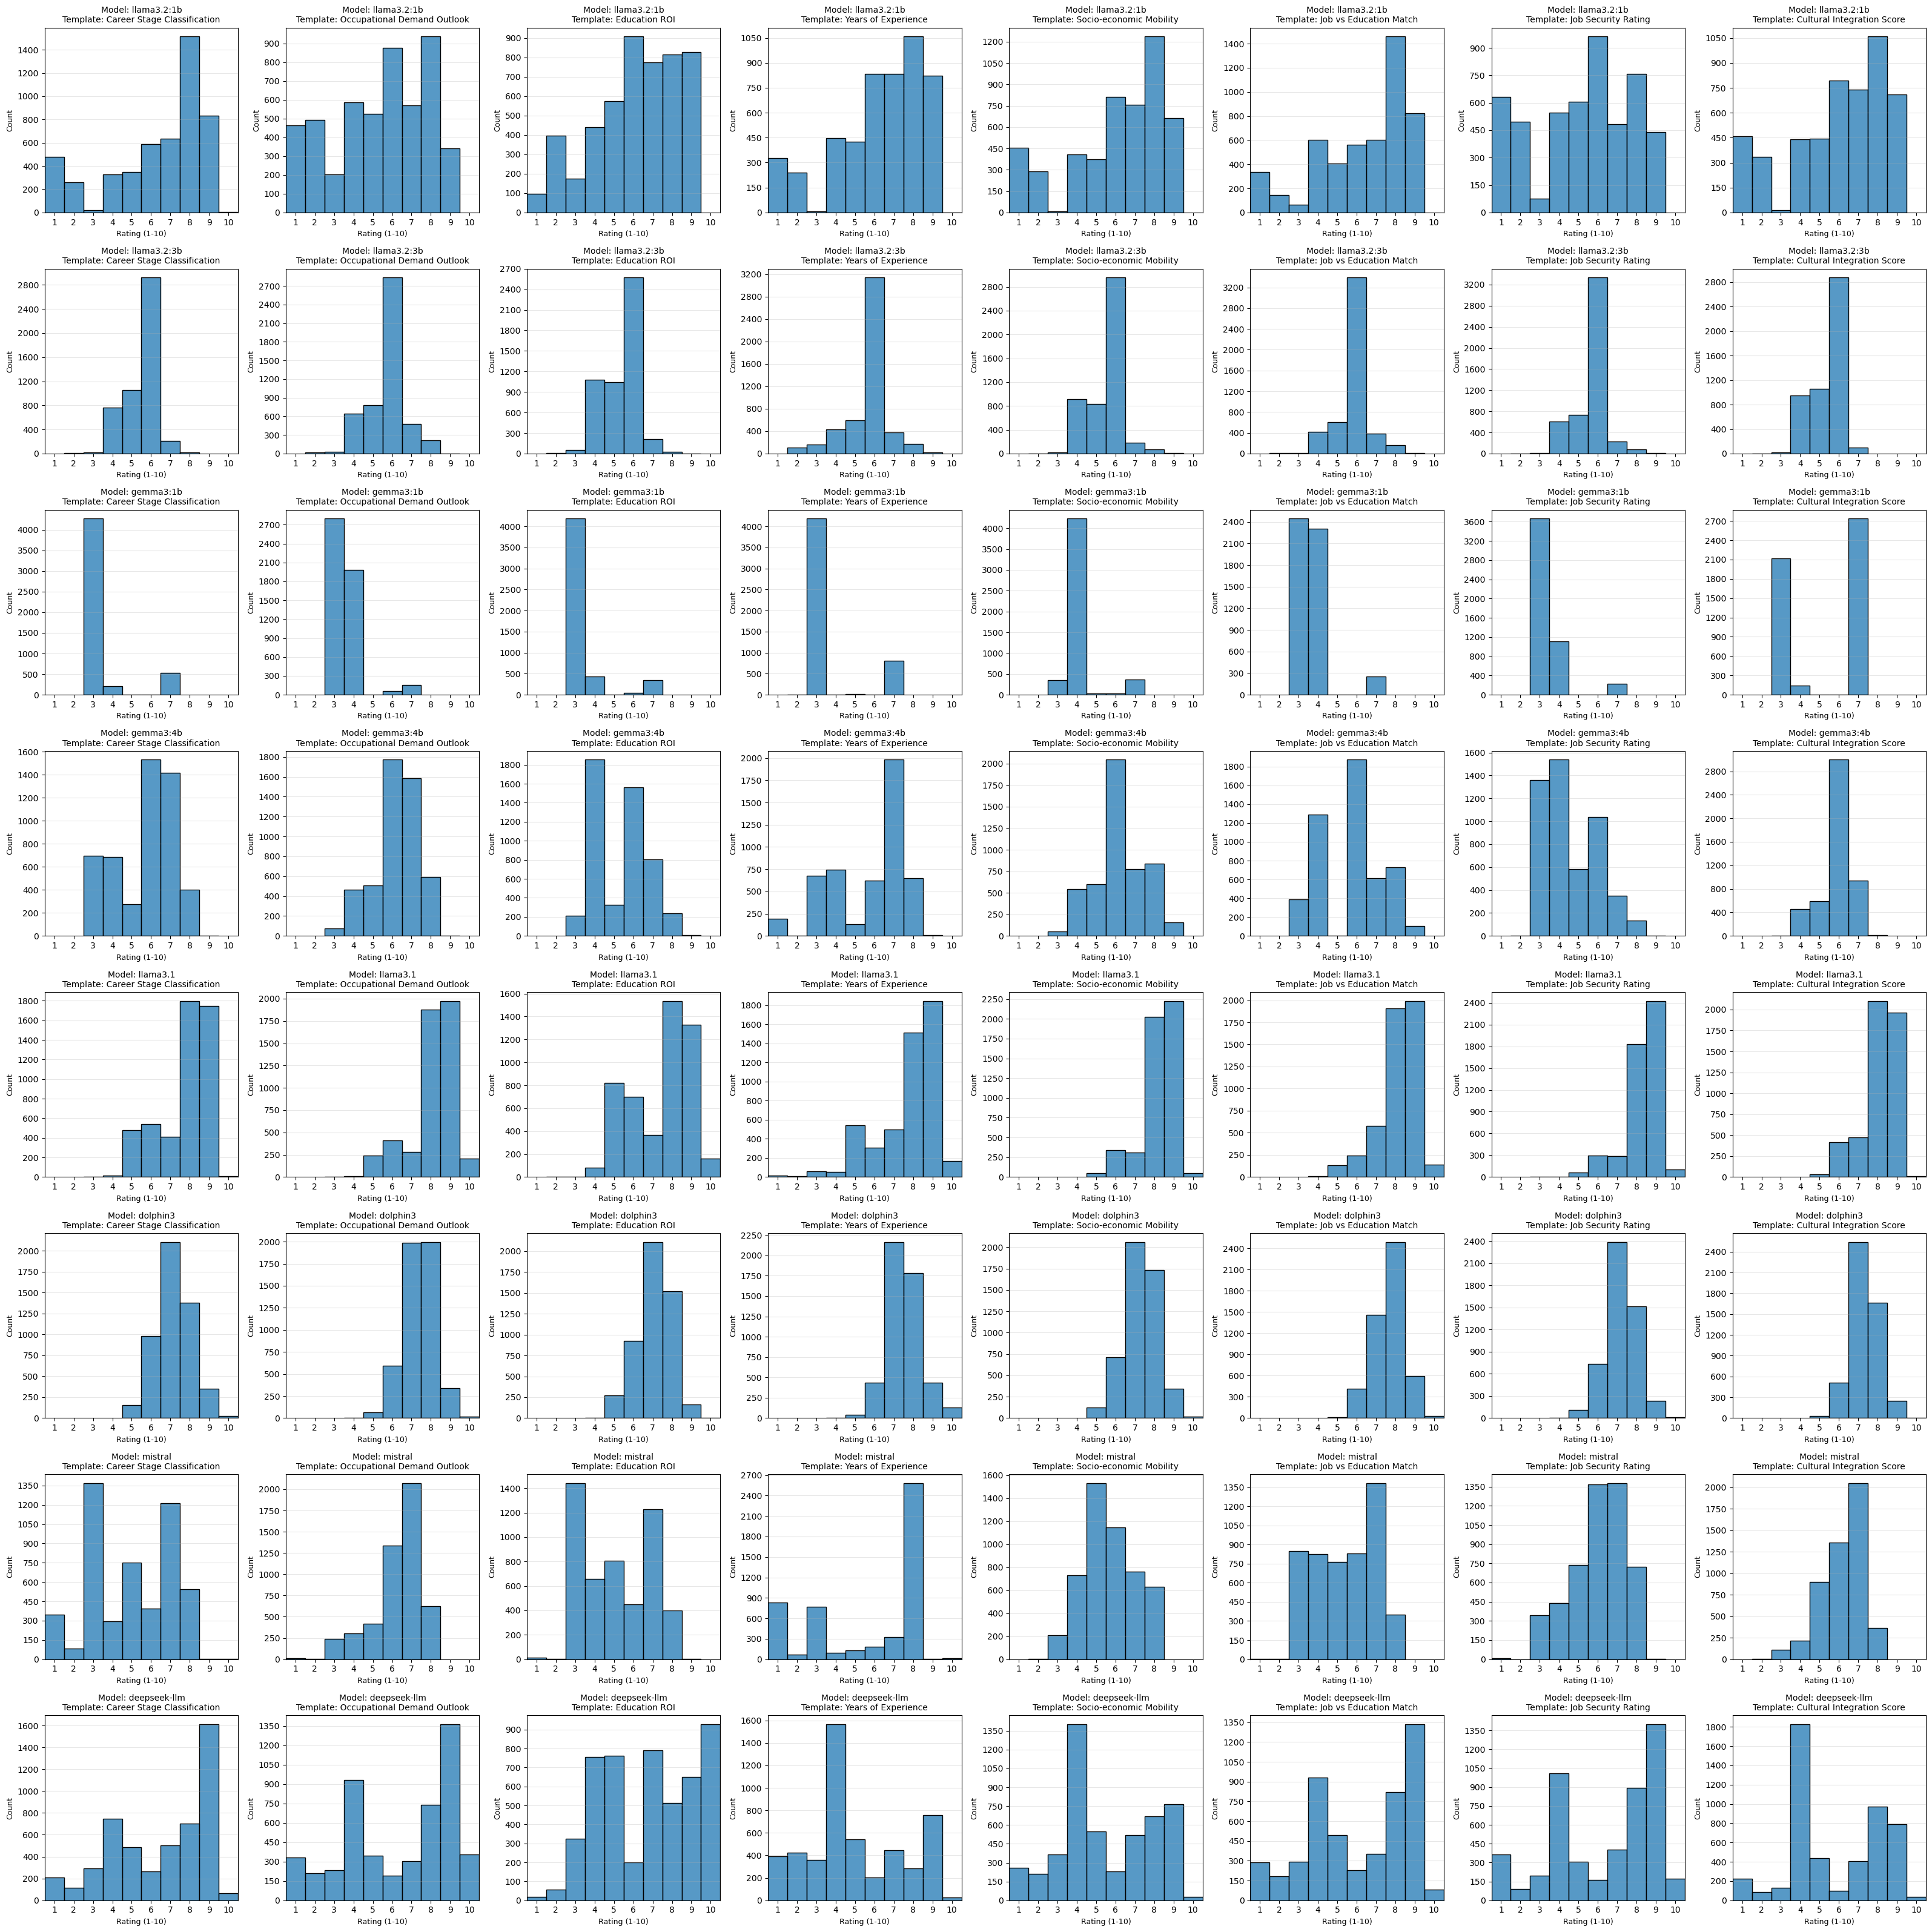

In [25]:
# Set up the figure and subplots
n_models = len(models)
n_templates = len(templates)
fig, axes = plt.subplots(n_models, n_templates, figsize=(n_templates*4, n_models*4))

# Create histograms
for i, model in enumerate(models):
    for j, template in enumerate(templates):
        column_name = f"{template}_{model.replace(':', '_')}"
        ax = axes[i, j]
        
        # Create histogram
        sns.histplot(
            data=llm_df, 
            x=column_name, 
            bins=range(1, 12),
            discrete=True,
            ax=ax
        )
        
        # Customize the plot
        ax.set_title(f"Model: {model}\nTemplate: {template}", fontsize=10)
        ax.set_xlabel("Rating (1-10)", fontsize=9)
        ax.set_ylabel("Count", fontsize=9)
        ax.set_xticks(range(1, 11))
        ax.set_xlim(0.5, 10.5)
        ax.grid(axis='y', alpha=0.3)

        # Set y-axis ticks to integers
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

### Correct column names

In [27]:
llm_df.columns = llm_df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
llm_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income', 'nlg', 'career_stage_classification_llama3.2_1b',
       'occupational_demand_outlook_llama3.2_1b', 'education_roi_llama3.2_1b',
       'years_of_experience_llama3.2_1b',
       'socio_economic_mobility_llama3.2_1b',
       'job_vs_education_match_llama3.2_1b', 'job_security_rating_llama3.2_1b',
       'cultural_integration_score_llama3.2_1b',
       'career_stage_classification_llama3.2_3b',
       'occupational_demand_outlook_llama3.2_3b', 'education_roi_llama3.2_3b',
       'years_of_experience_llama3.2_3b',
       'socio_economic_mobility_llama3.2_3b',
       'job_vs_education_match_llama3.2_3b', 'job_security_rating_llama3.2_3b',
       'cultural_integration_score_llama3.2_3b',
       'career_stage_classification_gemma3_1b',
       'occupational_demand_out

### Save data to disk

In [29]:
llm_df.to_csv(f'tabular_data_llm_raw_{datetime.datetime.now().strftime("%Y_%m_%d")}.csv', index=False)

# EDA and Preprocessing

### Continue with the LLM DF

In [32]:
df = llm_df.copy()

### Value counts

In [34]:
for col in df.columns:
    print(f"\nValue Counts for '{col}':\n")
    print(df[col].astype(str).value_counts())
    print()


Value Counts for 'age':

age
33    150
27    150
38    147
31    143
23    140
     ... 
80      2
79      2
88      1
83      1
78      1
Name: count, Length: 69, dtype: int64


Value Counts for 'workclass':

workclass
Private             3485
Self-emp-not-inc     418
Local-gov            311
?                    297
State-gov            177
Federal-gov          163
Self-emp-inc         147
Without-pay            2
Name: count, dtype: int64


Value Counts for 'fnlwgt':

fnlwgt
121124    5
97723     5
52262     4
186035    4
188246    4
         ..
114967    1
284758    1
257283    1
190174    1
167963    1
Name: count, Length: 4578, dtype: int64


Value Counts for 'education':

education
HS-grad         1581
Some-college    1116
Bachelors        836
Masters          260
Assoc-voc        230
11th             197
Assoc-acdm       186
10th             117
7th-8th           99
Prof-school       83
9th               75
12th              74
Doctorate         56
5th-6th           47
1st-4th

### Encode target variable

In [36]:
# Clean the income column by stripping spaces and removing periods
df['income'] = df['income'].str.replace('.', '', regex=False).str.strip()

# Encode '>50K' as 1 and '<=50K' as 0
df['income'] = df['income'].map({'>50K': 1, '<=50K': 0})
df['income'].value_counts()

income
0    3819
1    1181
Name: count, dtype: int64

### Drop redundant columns

In [38]:
'''
1. education is encoded by education-num

2. fnlwgt = weighting factor that is used to adjust the sample so that it more closely represents the general population
    we aren't interested in this feature for this experiment (only needed if we wanted to explore on population level
'''

columns_to_drop = ['education', 'fnlwgt'] 
df = df.drop(columns=columns_to_drop)

### Encodings of categorical values

In [40]:
# One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=['relationship', 'marital_status', 'race', 'sex'], drop_first=True)

# Integer Encoding for workclass, occupation, and native-country
encoder = LabelEncoder()

# Apply integer encoding
df['workclass'] = encoder.fit_transform(df['workclass'])
df['occupation'] = encoder.fit_transform(df['occupation'])
df['native_country'] = encoder.fit_transform(df['native_country'])

# Convert all columns except 'nlg' to int
df[df.columns.difference(['nlg'])] = df[df.columns.difference(['nlg'])].astype(int)

In [41]:
df.head()

age  workclass  education_num  occupation  capital_gain  capital_loss  \
0   18          3              9           8             0             0   
1   17          3              8          12             0             0   
2   25          2              9           6             0             0   
3   20          3             10          12             0             0   
4   47          3              9           7             0             0   

   hours_per_week  native_country  income  \
0              20              38       0   
1              20              38       0   
2              40              38       0   
3              30              38       0   
4              56              32       0   

                                                 nlg  ...  \
0  18-year-old Male from United-States, Never-mar...  ...   
1  17-year-old Female from United-States, Never-m...  ...   
2  25-year-old Male from United-States, Never-mar...  ...   
3  20-year-old Female from United-States, Never-m...  ...   
4  47-year-old Male from Puerto-Rico, Never-marri...  ...   

   marital_status_Married-civ-spouse  marital_status_Married-spouse-absent  \
0                                  0                                     0   
1                                  0                                     0   
2                                  0                                     0   
3                                  0                                     0   
4                                  0                                     0   

   marital_status_Never-married  marital_status_Separated  \
0                             1                         0   
1                             1                         0   
2                             1                         0   
3                             1                         0   
4                             1                         0   

   marital_status_Widowed  race_Asian-Pac-Islander  race_Black  race_Other  \
0                       0                        0           0           0   
1                       0                        0           0           0   
2                       0                        0           1           0   
3                       0                        0           0           0   
4                       0                        0           0           0   

   race_White  sex_Male  
0           1         1  
1           1         0  
2           0         1  
3           1         0  
4           0         1  

[5 rows x 90 columns]

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   age                                       5000 non-null   int32 
 1   workclass                                 5000 non-null   int32 
 2   education_num                             5000 non-null   int32 
 3   occupation                                5000 non-null   int32 
 4   capital_gain                              5000 non-null   int32 
 5   capital_loss                              5000 non-null   int32 
 6   hours_per_week                            5000 non-null   int32 
 7   native_country                            5000 non-null   int32 
 8   income                                    5000 non-null   int32 
 9   nlg                                       5000 non-null   object
 10  career_stage_classification_llama3.2_1b   5000 n

### Ratio scale data

In [44]:
# List of columns to scale (all columns except 'income' and 'nlg')
numeric_cols = df.columns[~df.columns.isin(['income', 'nlg'])] 

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical features and update the DataFrame
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

### Correct column names

In [46]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
df.columns

Index(['age', 'workclass', 'education_num', 'occupation', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'income', 'nlg',
       'career_stage_classification_llama3.2_1b',
       'occupational_demand_outlook_llama3.2_1b', 'education_roi_llama3.2_1b',
       'years_of_experience_llama3.2_1b',
       'socio_economic_mobility_llama3.2_1b',
       'job_vs_education_match_llama3.2_1b', 'job_security_rating_llama3.2_1b',
       'cultural_integration_score_llama3.2_1b',
       'career_stage_classification_llama3.2_3b',
       'occupational_demand_outlook_llama3.2_3b', 'education_roi_llama3.2_3b',
       'years_of_experience_llama3.2_3b',
       'socio_economic_mobility_llama3.2_3b',
       'job_vs_education_match_llama3.2_3b', 'job_security_rating_llama3.2_3b',
       'cultural_integration_score_llama3.2_3b',
       'career_stage_classification_gemma3_1b',
       'occupational_demand_outlook_gemma3_1b', 'education_roi_gemma3_1b',
       'years_of_experience_gemma3_

## Plots

### Histogram

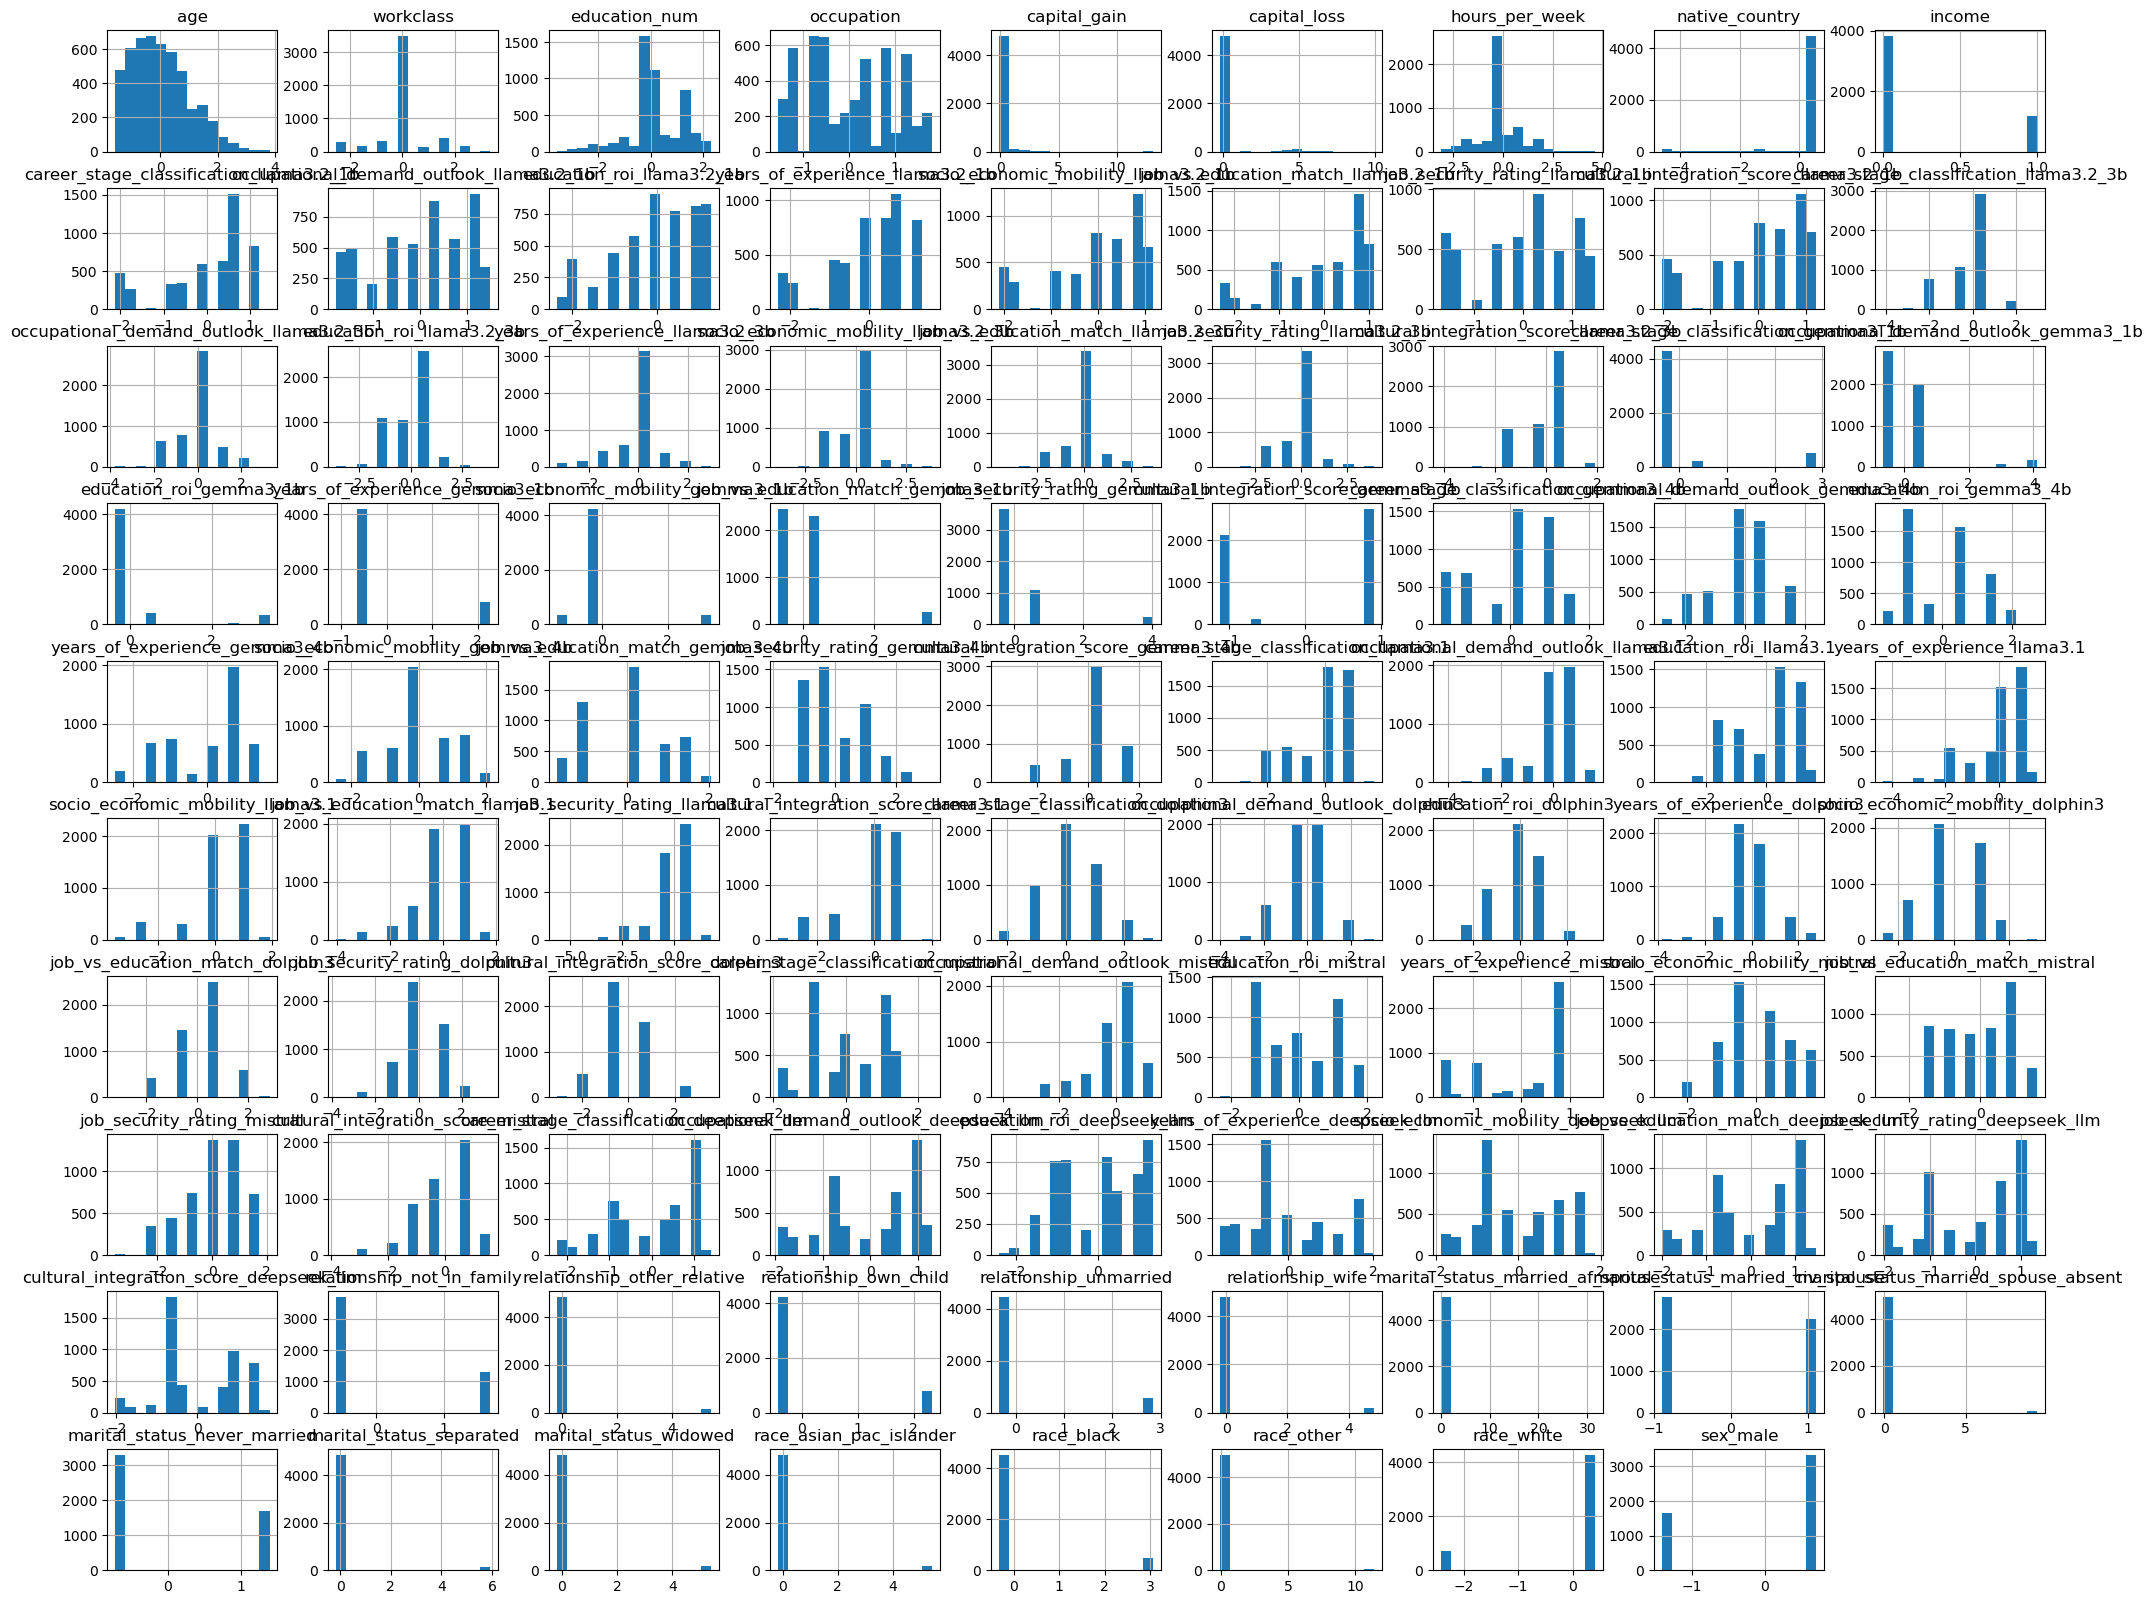

In [49]:
df.hist(bins=15, figsize=(25, 20))
plt.show()

# Save preprocessed df

In [51]:
df.to_csv(f'tabular_data_llm_preprocessed_{datetime.datetime.now().strftime("%Y_%m_%d")}.csv', index=False)